# **Timing Analysis**

contact: menglei.zhou@astro.uni-tuebingen.de

## 0. Prerequisites

Installation `Stingray` package using `pip` or `conda`

Note that our recommendation to use `Stingray` is not because it is indispensable for timing analysis, but simply because it is Python-based and easy to work with. In fact, you can always write your own code if you prefer. 

## 1. Extract a light curve (with Energy filtered) from an event list

In [1]:
def gti_extraction(gti_info):
    gti_str = "["
    gti_sum = 0.0
    for gti_element in gti_info:
        gti_str = gti_str + "[{0:0.1f}, {1:0.1f}], ".format(gti_element[0], gti_element[1])
        gti_sum += gti_element[1] - gti_element[0]
    gti_str = gti_str[:-2] + "]"
    return gti_str, gti_sum

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum, Crossspectrum, AveragedCrossspectrum

In [3]:
# Some basic FITS file reading work...

evt_file = fits.open('ni2596010601_0mpu7_cl.evt')
evt_file.info()

Filename: ni2596010601_0mpu7_cl.evt
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      32   ()      
  1  EVENTS        1 BinTableHDU    289   504165R x 14C   [1D, 1B, 1B, 1I, 1I, 1B, 1B, 8X, 1K, I, J, 1I, 1I, 1E]   
  2  FPM_SEL       1 BinTableHDU    122   3387R x 3C   [1D, 56B, 56I]   
  3  GTI           1 BinTableHDU    254   2R x 2C   [D, D]   
  4  GTI_MPU0      1 BinTableHDU    253   2R x 2C   [D, D]   
  5  GTI_MPU1      1 BinTableHDU    253   2R x 2C   [D, D]   
  6  GTI_MPU2      1 BinTableHDU    253   2R x 2C   [D, D]   
  7  GTI_MPU3      1 BinTableHDU    253   2R x 2C   [D, D]   
  8  GTI_MPU4      1 BinTableHDU    253   2R x 2C   [D, D]   
  9  GTI_MPU5      1 BinTableHDU    253   2R x 2C   [D, D]   
 10  GTI_MPU6      1 BinTableHDU    253   2R x 2C   [D, D]   


In [4]:
# Select the photons within 0.4 - 10 keV range
# Recall that for NICER, PI ~ 100*Energy (keV)

idx = np.greater_equal(evt_file['EVENTS'].data['PI'], 40) & np.less_equal(evt_file['EVENTS'].data['PI'], 1000)
print(idx)
print(len(evt_file['EVENTS'].data[idx]))

[ True  True  True ...  True  True  True]
500828


When **creating a light curve from an event list**, always remember to explicitly set the **GTI**, **T_start**, and **T_stop**. This is essential—otherwise your products may show incorrect count rates, or you may not be able to ensure that light curves from different energy bands are **strictly simultaneous**. 

In [5]:
photon_event_time = evt_file['EVENTS'].data['TIME'][idx]
delta_t = 0.001953125
gti, gti_len = gti_extraction(evt_file['GTI'].data)

t_start = evt_file['GTI'].data[0][0]
t_stop = evt_file['GTI'].data[-1][1]

lc = Lightcurve.make_lightcurve(photon_event_time, dt = delta_t, gti = eval(gti), tstart = t_start, tseg = t_stop - t_start)
print(lc)

Lightcurve
__________
time           : [1.66323159e+08 ... 1.66330209e+08] (size 3609600)
time (MJD)     : [1925.03656251 ... 1925.11815971]
counts         : [0 ... 0] (size 3609600)
dt             : 0.001953125
err_dist       : poisson
high_precision : False
input_counts   : True
low_memory     : False
mjdref         : 0
notes          : 
tseg           : 7050.0
tseg (MJD)     : 0.08159722222222222
tstart         : 166323159.0
tstart (MJD)   : 1925.0365625
gti            : [[1.66323159e+08 1.66324638e+08]
 [1.66328690e+08 1.66330209e+08]] (shape (2, 2))
gti (MJD)      : [[1925.0365625  1925.05368056]
 [1925.1005787  1925.11815972]]



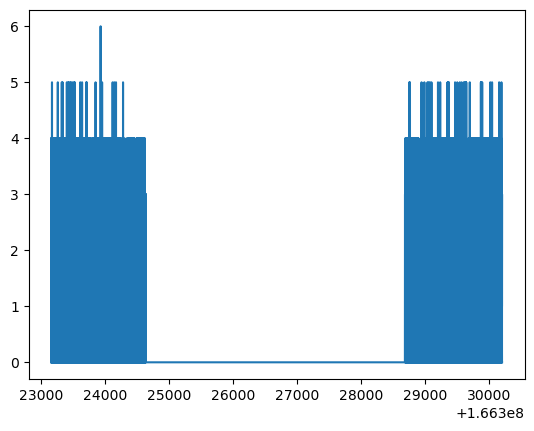

In [6]:
plt.plot(lc.time, lc.counts)
plt.show()

## 2. Some basic knowledge on Fourier Transform

Better refer to [**Wikipedia: Discrete Fourier Transform**](https://en.wikipedia.org/wiki/Discrete_Fourier_transform), [**van der Klis (1988)**](https://pure.uva.nl/ws/files/2212461/47104_Fourier_techniques.pdf), or the PhD thesis of [**Katja Pottschmidt (2002)**](https://publikationen.uni-tuebingen.de/xmlui/handle/10900/48443). 

In brief: we have a light curve $x(t) = [x(t_0), x(t_1), x(t_2), x(t_3), \dots, x(t_{N-1})]$, 
the **discrete Fourier transform (DFT)** can be computed with

$$
    X_j = \sum_{k=0}^{N-1} x_k \exp\left( -\frac{2 \pi {\bf i} j k}{N} \right) \, ,
$$

where $x_k$ denotes the $(k+1)$-th component $x(t_k)$. 

The corresponding Fourier frequencies are given by 

$$
    f_j = \cfrac{j}{T} = \cfrac{j}{N \cdot \Delta t} \, , 
$$

The flux decomposition as a function of frequency can be expressed as 

$$
\begin{align}
    x_k & = \cfrac{1}{N} \sum_{j=0}^{N-1} X_j \exp\left( \frac{2 \pi {\bf i} j k}{N} \right) \\
        & = \cfrac{1}{N} \sum_{j=0}^{N-1} X_j \exp\left( 2 \pi {\bf i} \cdot f_j \cdot \Delta t \cdot k \right) \, , \\
\end{align}
$$

which defines the **inverse discrete Fourier transform (IDFT)**. 

We notice that $\exp\left( \frac{2 \pi {\bf i} j k}{N} \right) = \exp\left[ - \frac{2 \pi {\bf i} \left( N - j \right) k}{N} \right]$, which implies that frequencies corresponding to indices $j > N/2$ are typically considered negative frequencies. Since each pair of positive and negative frequencies results in DFT components that are complex conjugates when $x_k$ is real, we discard the negative frequencies and focus solely on the positive ones. 

Practically, we prefer to set $N$ as a power of 2 to enable the **Fast Fourier Transform (FFT)**. In this case, $N$ is even. The minimum nonzero frequency is given by $f_\text{min} = 1/T = 1/(N \Delta t)$, while the highest physical frequency, known as the ***Nyquist frequency***,
is $f_\text{max} = 1/(2\Delta t)$.

## 3. Produce the power spectrum from a light curve

The **power spectral density (PSD)** is a real quantity to represent the squared magnitude of the complex products of DFT of a time series:

$$
    P(\nu_j) = X^{*}_j X_j = {\left| X_j \right|}^2
$$

The uncertainties of the PSD are on the same order of magnitude as the PSD values themselves. However, these uncertainties can be reduced by averaging over more samples (as the mean value of the power scales with $1/\sqrt{N}$, in which $N$ is the sample
number). We can average the PSDs not only across multiple segments of a long light curve but also within different frequency bins to reduce the uncertainties of the PSD.

Three commonly-seen norms in the power spectrum:

$$
    P_\text{Normalized} (\nu_j) = 
    \begin{cases}
        1 \cdot X^{*}_j X_j \, , & \text{unnormalized} \, ,\\
        \frac{2}{R \cdot T} \cdot X^{*}_j X_j \, , & \text{Leahy norm} \, ,\\
        \frac{2}{R^2 \cdot T} \cdot X^{*}_j X_j \, , & \text{fractional rms norm} \, ,\\
    \end{cases}
$$

where $R$ is the mean count rate and $T$ denotes the length of the segment.

**Q**: Why the normalization of power spectrum matters?

**A**: The expected power and Poisson noise levels differ under each normalization. For convenience, we often choose different normalizations for different tasks—for example, comparing power spectra between two sources or subtracting white noise. 

$$
    \langle N_\text{Poisson} \rangle = 
    \begin{cases}
        R \cdot T \, , & \text{unnormalized} \, ,\\
        2 \, , & \text{Leahy norm} \, ,\\
        \frac{2}{R} \, , & \text{fractional rms norm} \, ,\\
    \end{cases}
$$

Leahy normalization and fractional rms normalization each offer distinct advantages. Leahy normalization allows for straightforward estimation and subtraction of Poisson noise. In contrast, fractional rms normalization makes the power spectral densities (PSDs) independent of the
source’s mean count rate, enabling direct comparison of timing properties across sources with different luminosities, masses, or spectral states.

In [7]:
ps = AveragedPowerspectrum.from_lightcurve(lc, 16384*delta_t, norm = 'leahy')
ps_rebin = ps.rebin_log(f = 0.05)
print(ps_rebin)

93it [00:00, 7608.75it/s]

AveragedPowerspectrum
_____________________
freq           : [3.1250000e-02 ... 2.5390625e+02] (size 124)
k              : [  1 ... 133] (size 124)
m              : [   93 ... 12369] (size 124)
power          : [14.83058  ...  1.986109] (size 124)
power_err      : [1.53785951 ... 0.01795936] (size 124)
unnorm_power   : [39659.28322723 ...  5311.16511857] (size 124)
unnorm_power_err: [4112.47609543 ...   48.02613017] (size 124)
df             : 0.03125
dt             : 0.001953125
err_dist       : poisson
gti            : [[1.66323159e+08 1.66324638e+08]
 [1.66328690e+08 1.66330209e+08]] (shape (2, 2))
mean           : 0.32643504809307794
n              : 16384
norm           : leahy
nphots         : 5348.311827956989
nphots1        : 5348.311827956989
save_all       : False
segment_size   : 32.0
show_progress  : True
type           : powerspectrum



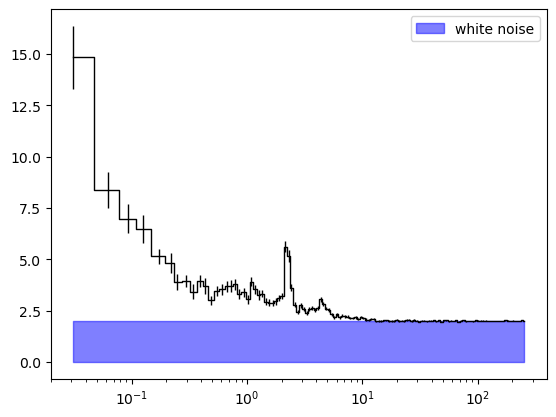

In [8]:
plt.errorbar(ps_rebin.freq, ps_rebin.power, yerr = ps_rebin.power_err, ds = 'steps-mid', \
             color = 'black', linewidth = 1.0)
plt.fill_between(ps_rebin.freq, 0.0, 2.0, color = 'blue', alpha = 0.5, label = 'white noise')
plt.xscale('log')
plt.legend()
# plt.yscale('log')
plt.show()

### 3.1. Fit the power spectrum in XSPEC

In [17]:
# Create an identity matrix as the response matrix for the power spectrum

psd_spectrum_filename = 'psd.dat'
psd_pha_file = 'psd.pha'
psd_rsp_file = 'psd.rsp'

f = ps_rebin.freq
power_sig = ps_rebin.power - 2.0
power_err = ps_rebin.power_err

with open(psd_spectrum_filename, 'w') as file:
    for i in range(len(f)):
        if i == 0:
            delta_f = 0.5*(f[i+1] + f[i]) - (2.0*f[i] - 0.5*(f[i+1] + f[i]))
            file.write('{0:0.8e} {1:0.8e} {2:0.8e} {3:0.8e}\n'.format(2.0*f[i] - 0.5*(f[i+1] + f[i]), 0.5*(f[i+1] + f[i]), power_sig[i]*delta_f, power_err[i]*delta_f))
        elif i == len(f) - 1:
            delta_f = 2*f[i] - 0.5*(f[i] + f[i-1]) - 0.5*(f[i] + f[i-1])
            file.write('{0:0.8e} {1:0.8e} {2:0.8e} {3:0.8e}\n'.format(0.5*(f[i] + f[i-1]), 2*f[i] - 0.5*(f[i] + f[i-1]), power_sig[i]*delta_f, power_err[i]*delta_f))
        else:
            delta_f = 0.5*(f[i] + f[i+1]) - 0.5*(f[i] + f[i-1])
            file.write('{0:0.8e} {1:0.8e} {2:0.8e} {3:0.8e}\n'.format(0.5*(f[i] + f[i-1]), 0.5*(f[i] + f[i+1]), power_sig[i]*delta_f, power_err[i]*delta_f))
file.close()

cmd_flx2xsp = 'ftflx2xsp {0} {1} {2} clobber=yes'.format(psd_spectrum_filename, psd_pha_file, psd_rsp_file)
print(cmd_flx2xsp)
# os.system(cmd_flx2xsp)

ftflx2xsp psd.dat psd.pha psd.rsp clobber=yes


```
XSPEC12> data psd.pha
XSPEC12> model lorentz + lorentz + lorentz + lorentz
```

<img width="1000" src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAABrsAAAKQCAIAAACgs1aiAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAgAElEQVR4nOzde1xU1f4//oUZFUN1CGbAOolYftRoPMdIxS9HESwNNe+idNHM/OAlummJJtpRSuxDesy8Fd4zFdGQFBIDROUhcpHHcUDr4U8Bz6mDDHz4SAMmgvP7Y+V2t2dmzZ7Zs2fPDK/nHz6G2bd12wv227XW9jqYGDkvtfC2n/rJZ8YsXprQN+j+Lu23VX4BBAAAAADcjfGPOjo6Ojo62tvbOzo62trabt261dbWdt999wmOCgsLUyi9AAAAAOCKvH799ddLly7dvn1bo9F4e3srnR4AAAAAsB8ihgAAAAAgXde6urqOjo7HH39c6ZQAAAAAgFReXl70g9FopD9S3GelEwgAAAAAbqDLzz//HBgYqHQyAAAAAAAAAAAAwCV0eeSRRzAZGQAAAAAAAAAAAKguDzzwgNJpAAAAAAAAAAAAAFeBiCEAAAAAAAAAAADc1aVr165KpwEAAAAAAAAAAABcBcKF0Bl16dLFy8vr9u3bXbp0UTotABbRJmo0Gm/fvq10WgAAAAAAAKATQcQQOhGj0djR0fHggw/ec4fSKQKwoqOjo6Oj49atWzdu3PDy8vLy8lI6RQAAAAAAAOD5EDGEzuLWrVv33nvvI488gpn44EZoaNvb29vb2/vXX39tb29HAwYAAAAAAAC5YUomdApGo9HLy8vPzw/RFnBT9957r5+fH23MSqcFAAAAAAAAPBwihtAp/Pbbb4888ghmdIJb8/Ly+tOf/vTbb785+brNzc0OPyduRgAAAAAAAFeGiCF4vo6OjgceeACjC8EDeHt7P/DAA2ZfhOJeYw9pat0rzQAAAAAAAJ0HIobg+W7fvn3//fcrnQoAx/D29u7o6DD93h1H7bljmgEAAAAAADoDRAzB8926dcvb21vpVAA4xn333dfe3i74EqE3AAAAAAAAcCAHzdPsuNV+Lp8YSddnoknXex1zTgAHsen1soacnc3p6zoa6wghXf2DHpz8lu/o12ROIIANunbtahoxxPReAAAAAAAAcCCpEcO23R/f+uEbcmd4y01CiNF47/Bp3tOTHJE8AOcxfL+7aeMHhNwdq9XeWNe0ZUnTlsV+c1J8R81QNHUAv/Py8kJ8EAAAAAAAAGQlYVZyx62W156+lbeX/HE2nLHtt1v5+1tee5q0tzkggQBO0bByRtPGRfxwISHEeLvjsfV5XQODmzYvblgep1zqABypqqpK6SQAAAAAAACAS7M/Ytgyqz//R2P7LWP7rS4P+T2Rb3hsfZ7pDgAuy3Bsz43S49yPXR72949P9p/zsXePvvc92e+xz48TQm5UFBqydyqaTOsaGxurq6uVTgWYUVRUdP78ecGXjY2N6enpzk9McnKy8y8KAAAAAAAAbsTOiGHr3PC7P9y+HXLkP08c/78njv/fPQ93I4S0nP6OEEK8vFrjBzoqoXaLi4s7e/as2U2JiYnx8fFOTxGIcvbsWdORUE1NTZmZmQ6/VtOGhfSDsb29W8q3j3129OHx8Q+P+++g5bt/fvvFmgk9ft9tU6LDL22roqIixltc3nrrrfDwcEtbQUEPPvhgbGwsP2jY2Ng4ZswYRRMFAAAAAAAAYJ49EUOj4f+MNwz0s+pvL/Y81li3/JXGLUsbN3/45015bbU/tV+7+vueN1uN1xscmmBHmjBhQmxsLPdjU1PThg0bwsPDg4KCgoKC4uPj+RGruLi4oDtGjhzJxa3Onj0bxEOjk6tWrerdu3dQUFB4eDj9Ji4ubsOGDfSQxMTExMREwYFBQUFxcXGEkLy8vJEjR5qmYcOGDdye8fHxTU1Npjni0h8eHk4P5F9l5MiR3NmqqqronnFxcfRU3HV79+7N5Y47Njw8nB+q4yebvafdfH19Z82axa+CpqamadOmST+zgCF7JzcZueeRXx74y9+uTv/rlRf8r7zg/58lUx5b913PHP3vu3p5Gb5Lc3gCHGjRokU7duzgfmxsbExNTe3Tp4+3t7e3t/fLL79cVFTEbU1NTfW+IzAwMCEhgRuf6M2TmppKCDl//vyYMWO483C70a2NjY2DBw8eM2YMDWgK0B0SEhICAwO9vb379OlDjxJci6ahsbFRkKnq6uqXX36Z7jNmzBi6Az/xffr0ycnJ4bJM09mnTx86fK+xsXHZsmXcpWnMjp/OwMBALj2C9JuWhtkUitGvX7/09HQuaEjT+e677/K7IDdVX18v8ksAAAAAAABwF/ZEDNu2/v5WE2Pbb4EfbmuruXijPO965pbrh7+sHtPN2N6mWbTF2PYb3edm2ocOTbAjDRo0aPjw4fQzjUY1Nzfv37+/rq7u4sWLMTExs2bNysvL4/ZPSkqqq6urq6v74IMPUlJSuAggIaTujkGDBmVmZp4/f764uLiurm7r1q3/9V//xb9oYmIiISQlJWXQoEH0kKioqMOHD9fV1e3duzczM3PevHkffPABTUNERMTEiRNra2vpsVFRUfR7Pz8/eh6Bxx57LCcnp66ubt68ee+9954geWPHjp01axbN7MSJE9etW1dXVxccHLx69Wq625dffllXV3fo0KE5c+ZwEUmatnXr1s2ZM4dLCT/L3Dd0z8TExEWLFkmuHBIaGrp161YuaEgraO7cuePHj5d+cr5fD6yjowvveSTQ674H/jVrkJf3/cSrC/Hq0n7t6tXXwry877vnkUC6c/OB9Y69umP169cvJiaGfqYxqYqKivT09La2tra2tnHjxk2cOFEwDbagoKCgoCA5OTk9PT08PJwLh8XHx9NNkyZNIoTQwFZBQcHhw4f79xcuOPDWW28RQnbu3NmnTx96VFhYGHcGmpLjx4+vX7++oKDgjTfeWLJkybJly7jD6Z7JyclbtmzZvn274OQ//vjj9evXDx8+fPjw4dLS0o8++kiQeD8/v9dee42fkra2tgULFrzyyiuNjY3Nzc3cpf38/PgRug0bNhQUFMTGxi5ZsoQ/+q/gDkEKN2zYsGXLlkOHDtldOzRoWFRU5DHhQkLIzJkzv/zyS/43X3755cyZM5VLEQAAAAAAAEhlT8Swo7KIGG/7v/H3ruruhJB/vT6Av/Xfs/8fIeShF2f9vvMF8zOC+YKCglatWsWNbqOj+cLDw2l8qqmpKTExkW5dtWoVd8iGDRt69+7NHxCXl5fHjZsbOXKkYDJyVVUVd2Z6yIYNG7io3+rVq19++eXFixcfOXIkLi5u8+bNhJD9+/d/+umnpgkePnz4unXrPv/8c7PZaW5ufuihh/z8/GjYi36gdu3aRcOFlopi0aJFu3btonFMPz+/6dOnT5gwYdOmTfx9/Pz8JkyY0NzcbHr4+PHj6eUiIyNramoEW1966SX65blz55555plBgwYRQubOnfvtt9/STAUHB9M09+jR45dffuEfO2jQoL/85S9cfLBHjx6WsvDzzz8/88wztMB79+5taTcxuKDh2bNnZQoX0hcid7lf9cTxJr+X3yeE3Pr5//vD1rra27/+38Pjf5+93vF/egunucvb23vZsmV0ZN+yZctSU1MDAwMDAwO5UB39hj9ibsyYMQkJCXRwHPclHZdHR8bRQXaCC+Xk5NCrcEPnUlNTuYmuM2bMePbZZ/fs2ZORkTFmzJjU1NTKysrjx48LRslFRERERETMnj37+PHjTU1NXDgsODiYbgoJCSGEXLlyZdiwYRERETExMQsXLuQnY9myZT/88MM333zj7+/v7+9Pj/L39+fOcOjQofLy8pycnNjY2IiIiIULF37yyScpKSnckEa65+zZs0eMGHHixAlBNmNiYo4cORITExMTEzNgwAD+Qo30/JMmTeIC3AcOHJg/fz4hZOLEiYSQkpKSkJCQM2fO0EtPmjTpypUr3OFPPfVUREQEHbj666+/0i9HjBgRcYcgJdevX/fz83vuuecaGxsDAwOttgRT/fr127p1a1RU1KRJk5wZLqS9H+fcuXP8HyUOCt6+ffuuXbu4oOGXX365a9cu08gvAAAAAAAAuBG7ZiXfartfG/HwpHmPfXGcEOLlfT9/q9d9918e4decfWdqZEe7mHM+9NBDdXV1b7311pw5c6ZOnVpXV/eXv/yFRso2b978+OOP19XVFRcXnz9/npum2tzc/NNPP23cuJGOaGtqapo3bx4dN/fOO+/885//FFzivffee+edd+rq6vbv328asztx4sT06dM3bNhw/vz5d955p6am5ueffw4ODu7fv7/ZZRAHDRp0/fp1LjH8Kbovvvhic3NzeHj4rl27+HOHs7Ky9uzZwwgXVlVVXb9+nQbyOM8//zx/ZB/N6bZt2/r168coz02bNnGjrjirV6+Oioqig7a4w4ODg69fv87fLTMz8+GHHw4NDRV8WVNTQ8dL1tbW1tTU0Bguf6DluHHjgoKCdu/e/c477xBCHn300Q8/lDrCNDQ0dN26dePGjRs7dqwc4cLf0fd9d+lqdqOxo50Yb9t0vsuXL//4448bNmxISUlpbm6+du3ac889l5CQQAhJT09PS0srLi5ua2t7+OGHuRFzdBxcWVlZbm4ujbZ89NFHx48f/+mnn4qKivhxLqq6unrcuHFbt26l4+kE4afq6urc3NyPPvooNTX1+PHjixcvrqiooBGrAQMG/Pjjj6Zp7tevX1hYGBewq62tLSoqKioqohG6xMTEJUuW9OnTZ9myZfyY3cGDB1NSUo4fP04Di2YdPnx4xIgR/B0GDx5MCOGi0vRaqampubm548aNs3Se8+fP5+bm0oAgVVRUlJOTc/DgwREjRtAfaWdCCPH39xe8FLixsTEtLY0/OPfChQtFRUUbN2708/Pr06cPIeTMmTO5ubn8Sc3Uli1boqKilixZ8txzzz300EP+/v7PPfecpXQyNDY20oBpWlqa6YtQ5BMaGrqX55lnnuH/KPHO0mg0hw4dokFDGi48dOiQRqNxXPIBAAAAAADA2ex688k99/6mK7p++Kuf54+gc5P5G403f3sit+mh0a/f2dl8FEaARgGeffbZHj160MfX119/nUbKDh8+vHLlyqCgoL59+xYUFHARjcWLF9ORcTTgVVhYyI2bGzRoEA2NcWpra//5z3/SkNagQYNqamr4ccCzZ88OGzaMEHL69Gk6X7hfv36PPfYYIeTxxx9nJNvX15d+4E/R9fPz27t379atWy9cuMCtJ0jH5dXU1Ji+zUO8goICOkbSz89vzpw5/Egll52mpib6OhdaPhQXzdy4cSP9hkZVTG3YsGHTpk379u3jvqGFtmnTptzcXDqAMTg4mGZ2165dn3/+OXdpbv7y9OnTa2tr6RhJuzPLZWfZsmVJSUm7d++WUnQMXf2Dbt8wXH7+T01fpxBCunb7Q+Srq+bxe/4UcD1rK/3xnocDxJxz3rx5dAgbIWTkyJH0Gxo+Pnz48JUrV3r37u3t7X3gwAEu+vbGG2+EhIT069ePBr9obJF+6e/vT6cG8/3www90orq3t/f8+fMFIcVffvllxIgR/v7+aWlpqampERER/fv3t1TpnKampkceeYR+pjGyqKiogwcPEkJWrFhRVlYWGxtLJy9zyaaBudzcXDHFYgm9Vlpa2ieffDJ79mz+YoLcPl999dXzzz//ySefcNOuafbHjRvn7++/c6eV11gXFRVFRESEhYW9/fbb3Jfz58+Pior64YcfiouLaUYmTZrEzap+5ZVXuKDeJ5980tbW9tNPP/3www80yLtnzx5bs8mtXbhw4UL+moYegAsaIlwIAAAAAADgGeyJGHbVRhCvLo2bl7Q31BJC/pxWzN/65y2nCCHNWV/RH+/pO8jCacwzO1KJhqIo/ggjPsEs3f/93/813aeORzCUjzp37hwNiv3rX//q1q0bHRjIvdyD7+zZsz169KDTeM0KDQ1NSUn58MMPucnL/fr1W7169cSJE82+tIQe8vDDDwuGNB4/fpwbD0jXMfzpp59SUlJoOgXZqaqqmjZtWmxsrGAkY11dXV5e3okTJ+iorscee+z06dN0U21tLZ1i3NTURF+9cuzYMf5M6sOHD1+8eJEQQgep8Q0aNGjChAllZWWCL5955hn++oZ249YunD9/Pn9NQ8d6cHICIcSr670djXXGtpvdt5cZ234jRiMxGu8JeLT7rgrjrbaOxv/c2flNiZe7fv36iBEj2u44cuSIpT0ttRPuPHTBPg77JDTU3tjYWFpa+uijj5ruSUcyDhkyhP5IY2RtbW3cHOR+/fqtWLGiqKioqamJxisJIcOGDfv666+XLFkiWB6Rb9y4cbm5ufyRiWfOnKGjUPnX+vHHH+m1IiIiBJlKSEj47LPPDh06JJgQ3dbW9vXXX+fm5paUlBBC6DhB2hXQmdd0qGx6evrEiRMXLFiwZ88eGhmkCgoKaOvlptCGhITQ+cg0IMhNVea2CqZFiyd41YngRSgeQKPRHDt27NixYwgXAgAAAAAAeAB7Iob3zVpJP3h531+fEn9fz6fv/+uwh0bPfGjUayHf/dLF56H61De5qcr3//cnEpM4bNiwbdu2ce/ztbRbZGTkuXPnaLgtMzNTMCs5ODi4R48edAptU1OTICo3aNAgGk+ZMGFCfHz8qlWrKioq/vGPf8THx5uGBZuamjIzM6dPn/7xxx+bTcnZs2fp+ZuamoqKivjTh8ePH//hhx9OmzbNUjDoww8/nD59Onf4rl27vv3225deeklkWSUnJ69YsYJ7nQtfaGhoYmIifR0Kv6w2bdr06quvEkK++eabv/3tb2YDsn5+fmvWrElJSaGjPvPy8rgXMX/77bd0eCY/++fOnQsKCqLpF5lyU4JXnQhehOJAvqPvvqLhyujA36qKu+881/P7hp7fNzz6P4f/PX/klRe4cYXGB8f9t8TL0fAZnT9bVFTECBhNmTLl4MGDjY2NjY2NdKAfHx2KSF/yW11dzb0smOrTp09ubm5jY2N8fPysWbMGDx788MMPp6WlRURExMfH8+PydOpxamrqxIkTw8LCuNnN3Kzk8+fPNzY2vvzyy+np6UVFRTS4xg+4x8bGxsfHJyQkWMrLxIkT/fz8YmJi6BlSU1OXLFmSmJjImMjMl5OTs2XLlrVr13Kp5W+lV3/ttdcaGxv9/f1HjBjx9ddfE0IOHTrk5+c3cODAxsbGV1555f3333/qqafo4fxlHPv167d+/fqUlBR62vT0dBoQ/Oqrr/gxTVoaX331VW5uLm3w3AujRcrLyxO86oQGDTMyMmw6jytTqVQqlUrpVAAAAAAAAIAD2DUr+UE/rwd+fyw0FB668kLAox/vD3jz04CE//n3/BH3PtbzHj813ep13wPkIX/muaxbtGiRn59f3759g4KC6MsZzO5G3/k7ffr0oKCgixcvCmYlE0K2bt16+vRpOqtXMCyOxiV37dq1aNGiiIiIxx57bN++fTExMREREVu2bOH24SZH5+TkcO8nofizg//zn/8sW7aM7unn5yeI902fPr1///6WgobTp0/fuHEjd3hRUVFubi5jJKNAQUEBnUQsmKpMjR8/noZN/fz8uLKib0ShM7JpBin+AoU0YDdv3jy6BtzPP/88a9asoKCgt99+e/Xq1dyKh/TS9Mvg4OBffvnFUlBVjMLCQsGrTmjQMCsry+5zWuI39/c36nh1vfeXhS/+smhC89HtzUd3XFv28p83HOtx6PcxZX+anSz9WrNnz05MTJw4caK3t/fChQsFo9j4kpOT/f39u3XrFhER0bNnT8HWfv36ff3112lpad7e3jExMf/+97/5W/39/RMTE8eMGfP2229v3bp1y5Yte/bs2bp1a3p6+ooVK/h70qnHaWlp77//Pn/AIzcrecmSJXTUXkJCAt3z66+/FiyjuX79+p49ez7//PNmx9/5+/sXFxc///zz3Bk++eQTQTIYaIx43LhxUXcIdqDThOm/n3zyyfXr1729vT/77LPjx4/7+/vTRRuXLFnCHS5YxjE2NnbEiBH0NeKVlZXh4eH08MOHD3MxTVoa8+fPT0xMnDlzZmNjIzfKUqTY2FjTV53QYZs2ncchpk6d6vyLAgAAAAAAgBvxsnv2aMuM0N/fF0EIIcTY3kYI6fpIt+D9P7Zdrvz3m1GEENWOSscl1Tbh4eFbt24VvL6DgY5oe+SRR6ZOnUrnIxsMBrOD9cDtNDc3M17uTDUsf+lGhfAtvcaOjse/LKpbMaP9P9X39YvQJB+QM5ksqampaWlpZt9YwpCQkECnvtKgc0VFRXJyssiRfeDKampqrK5K6UD0/e9OuxwASGc0Go1G4+3bt+m/HR0d7e3t7e3tt27dunXr1s2bN++77z7BIWFhYQolFgAAAABckf0RQ3KrrWX2M6ZfG9t+o1OSVV+WkT++RlluZ8+epZMld+3atXHjxuLiYhEH/UFmZmZOTg4dURUTE/Piiy/yV/QDNyUmYkgIMRzd3rRlCSFeppv+9MaKB8e+IU/qLKLj9UJCQs6fP//888+///77glX8RJ7khx9+oIseDh48OCIiQp7EglMhYggAbIgYAgAAAIBEEiKGhBBC2rZ/dOvEAf5gQ2I0do2ceN/rKx2QOhvFx8cfPnyYTrRcunSp+AGG4NlERgypX7O++vXgFx1NekLIPX9SPzRpvq/ktQvtk56evmzZsitXrvj5+dkXLgRPhYghALAhYggAAAAAEkmNGFLGtt9ulx4zGo33DHzBy7njCgGssiliCOD6PCli6OXlZTQaZTo5QKeFiCEAAAAASNTVIWfx8r7/nohxDjkVAAB0HggXAgAAAAAAuCC73pUMAAAuxh1Db+6YZgAAAAAAgM4AEUMAAE/g5eXF/esu3Cu1AAAAAAAAnQcihuDhbt++fe+99yqdCgBHuueeeyyNzpNj1B5eewIAAAAAANDZIGIIHq69vV2lUimdCgBH8vHxaW9vVzoVAAAAAAAA4LEQMQSPdfv27ba2to6ODoyQAg/j5+d369attrY2rAMIAAAAAAAAcuja3NysdBoAZHHPPffcf//9Go2mSxdExsGjdOnS5dFHH21oaGhtbe3o6CCE/Prrr0onyn4PPvig0kkA8DTGO27f0X5HW1vbrVu37rvvPqXTCAAAAAAurWuPHj2UTgMAANimS5cuGo1G6VQAgIsShAs7Ojra29tv3XHz5s0bN24onUYAAAAAcGkYewUAAAAAAAAAAAB3IWIIAAAAAAAAAAAAdyFiCAAAAAAAAAAAAHchYggAAAAAAAAAAAB3IWIIAAAAAAAAAAAAdyFiCAAAAAAAAAAAAHchYggAAAAAAAAAAAB3IWIIAAAAAAAAAAAAdyFiCAAAAAAAAHLx8vKy+o3pDpRNpxV5cvE7e/2R+NNKvzQAgOK6Kp0AAAAAAAAAgD8wGo3KJsDLy0uQBtNvAAA8GMYYAgAAAAAAAFiBcCEAdCqKjTHMzsktLDx9priEEHLyxPfiD9TrGzIOZublF9bX6wkhg8MHxk6ZEBbWn9th6LAXBIckr0waOiRC4nWtKi+vSD/wLT2zIFU0zcVnS6urawkhISHBU2MnjYoZ4cCrWyIlv+XlFS2trbToNm1O27svgytJq7WQnZO7P/2gHPl1zXJmtzoxTp4qKig4eaW6prq6ll9T7BpUpJytplkmpoVMJbw5Z8rk8XYcLmjPjJbDuBckcsFylq9/Zpez1V5FChcsZ4n5ldIzSO+vLGGXs3zXZZP4e9BSjqz2SEr1G/S6Q/72/wghW77ctm9/xvJliweHD5R+XQAAOQhm5tKQHP2S/sv/hr8P+zxmv+cOFDkd2Gg08tNgNdkiv+dOyx+0aLoD/6JmdxOcCgFNAHA4ZSKG9E9nQoivr8pgaLHp2IUffFhdXRsSEhw3bXJ9vT4vv1BXWbVz+xa1OoDbR6NRD4+O5H7sFhQk/bpsen1D0vJkg6Fl7NhRhJCsrGx+qjZu+iovv5CmuaW1NT+/MGX1mkCN2lEPw5ZIzO+q1WsIIWYfb9i1kJ2Tm7J6jUaj5ueXECI9mOWa5UxZanVW6fUNqZ99Tp/9tNrQuGmTL1263KvXE1ZrUKlyZqdZVoJCpoUzLPJv9h3O1ZHVlsO4F6RwzXKWr39ml7OYvt0+rlnOUvIrvWewu79isFrOMl2XTUp7tpojdo+kVL9Br0sjhgAAbsE0rGYaMhPsxp4sbBqPM/1RZPSQH6djpIf9Pf+6gjAo/5wi432WcoRVEQHA4ZSJGAYEBLw+89XRo0Z+tGKVTldl07FjRse0tLS8NuNl+qNGo967L6O07Bz/WSgwUDN3zhuOvS5bxsFMg6Hl9Zmv0oQF+Ptv2777aPYx+uO8ubMHDAjjUhjcvfv6LzaXlJbLHcmSkl+9vqG+Xm9pVAK7FvanH/T1Va36+CP6yB0VOeTdBYuPZh+THslyzXKmLLU6q2ioYnh05Ly5swXBAnYNKlXO7DTLil/I5eUVe/dlDA4fKD4BluqI3XLY94IUrlnO8vXP7HIW07fbxzXLWUp+pfcMdvdXDFbLWabrsklpz1ZzxOiRlOo35LsuAICCpKweaPalK7aejRE35Mc3+UMjLV0OwwABwI0oEzEUM4VQ5LGhoX0JIbW1V+mPen2DlOvyZ/potaGvv/aKyGBTZdVFQgj3FDF61Mht23eXlp2j36jVAfxHtYaGBkLIc8OjxJxZCinlfPHHnwghPXp0F3NmQS1UV9dqtaHcCJ2wsP5abSj/Uc3Dypnd6thOnio6U1wyOHzg8mWLTbeya1Cpcman2WkKCk8RQp599hkxO7PriN1y2PeC55WzfP0zu5zZx3p8OZvmV/yxAuyewWp/JVM5S+knpZDSntk5EhD0SEr1G1avCwDQ2TgwQieYAiz35QAAFOf270q+cqWGEBIc/Psfx/RvZYPBMD9hgU5XpdWGDoscIvKBoby8Iml5MiGEzvTJzy9MWp68bu2nYuam0WsRQi5dukwI6dXrCY1GLRjOoNc3lJadKy0t11VeSFz0nhOmcEpRVXWRe4i1SlALpq5dqwk+UUwAACAASURBVOc+e145S2l1BQUnCSFvzJpxICPzwoWLKl/VwAFhds9ic045OzbN4sVNmxwQcHf8V3FxqfgpyWLqyFLLYd8LnlfODmS2ZxB5hwqO9fhyttqLSsHvGdj3gnzlLKWfVAo7R+weSal+w6bf3QAASrF1lJ/ZScp2X1f82WzdTXBms5fD25YBwI24fcSwtOwcIWSAyTgjjTpgcPhAXWWVTlfFn/nFcOTo9wZDy9rPVtH/56czuQ5/d3The2+dPFW0NGml2aP4C5lfunR51uz5vr6qdWs/DQzU0PXsOTNmxtNFlIZHR/Z60qXDhYSQmpqrhJC+fXqL2VlQCyEhwTpd1clTRbRkduzc09rayu3sduUsMlX2tbor1TWEkMPfHc3KytZo1PX1+qysbJGv8lCqnKWkWQr+ZMby8go6887WOaSMOrLUctj3gueVswOZ7Z9F3qGCY92unMX3G2bzKwW7Z+CYvRfk7p/t6ycZbC1nO1jKEbtHUqrfsOl3NwCA0zjkBR38VQ7Z5xdzXTGr/pmeVswZTNPJGJzInulsNYUAALJy74jhgYxMna5q7NhR3N/oQ4dE8N+ESP8b/8jR78U8k+gqL2i1ody0oLCw/hqNmr5rsltQUNy0yWaP4i/c3tzcTAixtLZ69pGDen3DicLT23fsPltSJnI0gVIuX6nWaNRiwjGmtTA1dlLK6jVLk1ZqNOrW1tbo6Ei6Shfd6nblbDVVUlodzbjKx4eeoby84t0Fi/enHxQTrVCqnKWk2VFsmpIsso4stRz2veDZ5SyFac9AiblDTY91u3IWmSrKUlnZh90zsO8F+cpZSj/JYFM524f9G4cy7ZGU6je462IACwC4Gkv9kqU1/iy9ZkTMsTYdyMbY06Yz25F+MefHCokAICs3jhiePFW0fcfukJDgGa++ZGmfsLD+ISE9RC52Xl+vr6/XDx32Av/LwEANnfUjJuoUFtZ/7Wer6P4Gg8F0B7U6YMrk8YGB6qVJK+loAjEJcz66dLpGo960OY1+QxdOKig42S0oiF8UZmthVMwIX19VSWl5i6Hlqaf6/vUv2qysbO3ToXSr25WzyFTxkye+1dE3eHJjVUzXImRQsJztTrOj2DQl2ZSlOjJtOVbvBc8uZ7ux+2f2HWr2WLcrZ/H9hpjfZTZh9wwCgnvBCf2z2evazdb+2Q5iciTokZTqN/jXpc+N9LqFhac1anVw8OOSCwMAAAAAOhF3jRju2Lln2/bdISHBqZ9+zP8/fPrXuX2vYqRDMN5KmMP/UuXjI+ZYOguM/hFP/2qna8+b3ZlOF6KjCVwTXXCqvl6/d18G//u8/MKoqKHcw4ylWqDDSbjJU6lrPieERN55lPK8cpbS6nx9VVJGFSlSzhLTLJ0dU5JtqiN+y7F6L3hwOduN0TPwmb1DLR3rqeUssqxsxegZ2PeCfOUspZ9UisjfOKY9klL9hsl1fx9uUnDi1JAh/w8RQwAAAACwiUtHDA9kZKpUPvx3a9K1e/7x+Uadrmp4dOS8ubMFj1iVVRd1uqrnhkfRqJZe31BdXcPNxmLTPv1UXn7htWt6OyajabWh1dW1BzIy6bFHs48RQp62sPQ43RoSEmzrVWRiWs6C6WP0YW/vvgxuESV2LXD0+oadu7/JysrWakO583teOYtsdWbbMx1lU15ewXv2E9tiOU4uZ4ekWQr2lGSz5WxTz8BvOVbvBQ8uZzY7+mcBwR3KPtbzyllkWZktZ5HM9gzse0G+cpby29kJzJazyN84pj2SUv0G/7p0rf1Nm9P27c/4aPniweED29vbbb0WAABYginAANAZKBMxPHmqiL7Oj77AkQ49CAgI4P/pXF5esf6LzYSQQI2aW+uHEEIfsTQatUajzjiYyX1PRy6MHjVSp6t6+90PoqMjVT4+efmFBkPLzNdeFXPdl+Jiz5aUrf9ic1nZuR49utP/qH8pLlbM/KAZr76Un1+4fcfu2qtXCSFZWdm+vqrJk37PzqbNaTU1V+k5a2quniku8fVVjXtxtEML1Qwp5czGrgV6rcqqi9XVNQZDy+DwgQsX3J116HnlzG51lKVypscmLU/mH/vm/Hi61WoNKlLO7DQ7AWNKMrucLdWRlJbjeeUsX//MLmf2sZ5XzlZ7UUY5S+kZ2PeC3OXM7iflIKU9s3PEsWORBPnKGQAAAADAUZSJGFZVXeRP1aGftdpQ/l/w3bs/rtGoVSqf7t3NzKMxnexDn7LoAIH96QezsrLp6JXERe9xowbY1+3V64l1az/9Zm+6rvLCmeISOlttzOgXTC5uhlodsPLvS9MPfEuvOzh8YOyUCdyYkZbW1stXqrlzDo+OFPlgIJH0cmazVAv0WiEhwYMGPhsVNVTwtkrPK2d2q6MslbOUFqtUOYvJr3zYU5LtK2cpLcfzylm+/llMOVs61vPKmWL0ooxyltIzsPPreeUspT2zc0TZ9952+coZAAAAAMBRvNra2pROAwAAAAA4DJ2VfPuOjo6O9vb2W3fcvHnzxo0bgkPCwsIUSiwAAAAAuKIuSicAAAAAAAAAAAAAXAgihgAAAAAAAAAAAHAXIoYAAAAAAAAAAABwFyKGAAAAAAAAAAAAcBcihgAAAAAAAAAAAHAXIoYAAAAAAAAAAABwFyKGAAAAAAAAAAAAcFdXRa6q1zdkHMwsPltaXV1LCAkJCZ4aO2lUzAiRh2fn5O5PP2j22KHDXjB7SMKbc6ZMHs/9ePJUUUHBySvVNdXVtSdPfO+IPJHy8or0A9+eKS4hhAwOHxg7ZUJYWH+6ieY3L7+wvl5vulU+EsvZtDCTVyYNHRJBPyuVX5ctZ/uu65AW6+T2TLe2tLbSxrBpc9refRn8tiGf7JzcwsLTNFU25dRqHbHPzOhzJLLanu2+f6Wwu5zZ/YbVHLFbnRTsM7P7OvlIKWdGjti9isg+xz6u2Z6l9FeMOrLaq8jXrkSXs7FHj+6TJ00Y8Xy09IsCAAAAQGejTMRw46av8vILQ0KC46ZNbmltzc8vTFm9JlCjFvNwmJ2Tm7J6jUaj5h9LCOEePDQa9fDoSG7/vfsyCCHDIv9Gf9TrG1I/+5z+na3VhsZNm3zp0uVevZ6QmCO9viFpebLB0DJ27ChCSFZWtq6yauf2LWp1ACFk4QcfVlfX0vzW1+vz8gv5W+UjpZwpQWF2CwqiH5TKr2uWs8TrSmmxirRnQsiq1WsIIU4IqfDRR31CiK+vymBoselYdh2xz0z7HF9fFS0N0z7Hbuxyln7/2kdKOVOW+g12jqy2OruJObOlNMtHSjlbzRG7V2FvtZtrtmcp/RW7jsT0/HK0K5HlPG3qJFrO/5P6D3WAf79+T0u/NAAAAAB0KspEDOfNnT1gQBj3vB3cvfv6LzaXlJaLeXLYn37Q11e16uOPaFgkKnLIuwsWH80+xp0tMFAzd84b9HN5ecXefRmDwwdyf8HT8Mrw6Mh5c2c7MJCUcTDTYGh5fearr814mRAS4O+/bfvuo9nH6I9jRse0tLTQz/QRYu++jNKyc3IPr5BSzhS/MPmUyq9rlrPE60ppsYq0Z72+ob5ePzh8oKMuJ1JAQMDrM18dPWrkRytW6XRVNh3LriP2mQsLTxNCEhe9RyMOAweELU1aWVh4Wu72LP3+tY+UcqYs9RvsHLFLQwoxZ7aUZvlIKWerOWL3KuytdnPN9iylv2LXkZieX452JbKcjUaj0Wh8/M9/3rBxS2nZOUQMAQAAAMBWyqxjqFYH8P+kbmhoIIQ8NzxKzLHV1bUhIT24UVRhYf212lBLj1sFhacIIc8++wz98eSpojPFJYPDBy5fttjs01F5ecWixGVDh70wdNgL8xMWlJdXiMxRZdVFQgj35DB61EhCSGnZOfrjlMnj+Y+moaF9CSG1tVdFntxuUspZr29gbJWYXw8rZwde16YWq1R7vvjjT4SQHj2625FBKWg52xfXYNeRmDNzA5T69ulNCPHxeYDbJFM5S7l/pZBSzux+g50jdmnIV87sNMtHSjlbLSs+Qa9idauHtWcp/RW7jti9itV25ZxybmxsJIRER0VaOBkAAAAAgEXKjDGk9PqG0rJzpaXlusoLiYves3sq5bVr9dznuGmTAwLu/nFfXFzKn2xVUHCSEPLGrBkHMjIvXLio8lUNHBDGX5gvaXkyIYSbe5i0PHnd2k/FJEynq9JqQwkhly5dJoT06vWERqO2FMe8cqWGEBIc7KSAi33lTJ+yDAbD/IQFNHfDIodwq1xJya+nlrN915XSYpVqz1VVF7nHYzdlUx2NHj1SV1n19xWr5s2dTSf9+fqqxoz+fYUyuduzo/pJ52D3G5SlHLFLQ75yFpNmV8POEbtXYW/1vPbstP5K0Kuw25UTyrmktJyW8/sL33nyyZ4dHR3y5BsAAAAAPJYsEcOTp4qWJq00u4m/7PeMmfF0YaDh0ZG9nhT72BASEqzTVZ08VUTPs2PnntbWVm4rf/pPeXkFnYvEDRC4Ul1DCDn83dGsrGyNRl1fr8/KyuaWez9y9HuDoWXtZ6voJCk63/nwd0cXvveWyBxdunR51uz5vr6qdWs/DQzU0NXQTdGxAAMsjPgQT9Zy5mjUAYPDB+oqq3S6Kv4MLLvz66nlbN91pbRYpdpzTc1VbqidA9lazlLYVEdDh0SofHxWrV4zacordO7hyr8v5aZSyt2eJd6/ppxTzox+g50jS6XhhH6DkWbXZClH7F6FvdXt2rNVMvVXpiz1KmbblbPK2Rg1bOiTT/SULdMAAAAA4MlkiRh2CwqKmzbZ0ibuc/aRg3p9w4nC09t37D5bUibyf9enxk5KWb1madJKjUbd2toaHR1Jn+FN9zSdbEVf0ajy8aFvPCwvr3h3weL96QdphEVXeUGrDeUCAWFh/TUaNT1EZI6am5sJIew17A9kZOp0VWPHjpK+aJSs5Tx0SAT/vZB0QMSRo9/zn6Lty6+nlrP069raYpVqz5evVGs0aoe/T8amcpbC1jqijd/Hx4cmLy+/MGl5Mhc0lLs923f/MshazmL6DXaOLJWGfOUsJs2uSUxPaOuUZLdrz1bJ1F8JmPYq7HblhHKur9dz5Zz66cchIcEOzTEAAAAAeD5ZIoa9ej0h8hlArQ6YMnl8YKB6adJK+r/rVg8ZFTPC11dVUlreYmh56qm+f/2LNisrW/t0qOmegslWlK+vihthIVgDsb5eX1+vHzrsBf7+gYEa8TkKC+u/9rNVdH+DwWC6w8lTRdt37A4JCZ7x6ktWz2aVrOUsEBbWPySkh2Dek3359eBylnhdW1usIu2ZvkZAo1Fv2pxGv6GLahUUnOwWFCTl4V98OUthRx2tWr3Gx8dn04a1NBYwedL4GTPjP/9i887tW5zTnqXfv3zOKWfKbL/BzpGl0nBCObPT7ILE5Mhsr8LY6nbtmU2+/opPTK8iaFfOKefJk8ap1f7Llicfyf4+YX68XZkDAAAAgM5LyXUMOXS6EP3fdTGGDongJuakrvmcEBJp8jhkOtmKhlcYAw3oQMW3Eubwv1T5+IhJEp0rTf+Ip08p1dW1dKUhzo6de7Zt3x0SEpz66cdyj3cwy6Zyps9Xll7yKCW/nlrOEq9rR4tVpD3Txbnq6/V792XwD8nLL4yKGuriq+zZV0f19XqtNpTbX60O4D/5y92eObb2k4pg9xsCghyxS0O+crYpzS5CZMsx26uwt3pYe3ZCf2WpV2G3K6eVc5/e/8VNzQYAAAAAsIlLRAyPZh+jfwQLvj+QkalS+fDf+sen1zfs3P1NVla2Vhtquo/ZqVj0Ob+8vIL3d3YNN6NZ+/RTefmF167p7VjzXqsNra6uPZCRSY+lOXr6zlLrly5d/sfnG3W6quHRkfPmzlYkXGhrOVdWXdTpqp4bHkWfqYRlJSG/nlfOIq/Lbs92tFhF2rNgqh19MN67L8PhSw3azWw5S2kbvr6qa9fq9foGepTT+g0BS/evUuzoNwQEOWKXhnzlbFOanc9sOYtsObZOSfa89iy+v2L3z2axexUrv0OdVc453x9X5NX2nZCXl5fSSQAAAAArjEaj0klwM8pEDDdtTqupuUr/hK2puXqmuMTXVzXuxdH8fcrLK9Z/sZkQEqhRc2v9cIdXVl2srq4xGFoGhw9cuMDMnCazU7FGjxqp01UlLU+Ojo5U+fjk5RcaDC1v3pmq81Jc7NmSsvVfbC4rO0fTVl+vfykuVswwhBmvvpSfX7h9x+7aq1cJIVlZ2b6+qsmTfn8SoA8VGo1ao1FnHMzkjpJ7VIuUcqZl9fa7H/DLauZrr0rPr+eVs5jrMtozZUeLVao9K+XkqSL62lP6enQ6hCcgIID/yG2pnNl1xD7zi2Ni9u7LmDv/3eHRkXR0ksHQ8uKYGHoG+cpZzP0rBynlzO432Dlil4Z85cxOs3yklLPIO9TWKcke2Z7FsFTO7Dpi9yrsduWEcjYajbScVSrVmFEvWDsrOICtDyFeXl6OfW6x+4Q2HShyZ/ZujK2WNpn93uFlKIXrVKgcdYoKVfacTq5Q1KncJ0Sv6xB2JAb/vWcHZSKGLa2tl69UnykuoeN3hkdHmv6h3L374xqNWqXy6d79ccHhe/dlhIQEDxr4bFTUULPDmixNxaLDB/anH8zKyqajGxIXvceNKejV64l1az/9Zm+6rvICl7Yxo0X9na1WB6z8+9L0A9/SMw8OHxg7ZYLg6qYTo+SOZEkpZ3ZZScmv55WzmOsy2rPdLVbZ9ux8VVUX+SVMP2u1ofwIC7ucLdUR+8xz57zxwAMPFJw4Sb8PCQnmXkgtazmLuX/lIKWc2W2SnSN2achXzuw0y0dKOYu5Q+2YkuyR7VkMS+Uspo4s9SpK9c/8clapfKKjhk6NndSzZ4+Ojg5phQQAAAAAnY5XW1ub0mkAAAAAAIcxGo1Go/H2HR0dHe3t7bfuuHnz5o0bNwSHhIWFKZRYT2DfSAeMdhG/ySNHu8h3QowxlA5jDFGn8p0Qva5DuMJv3s6gi9IJAAAAAADoXBz+0GL3CW06UOTO7N0YWy1tcv1nPNepUDnqFBWq7DmdXKGoU7lPiF7XIVw/hZ4BEUMAAAAAAAAAAAC4CxFDAAAAAAAAAAAAuEuZN58AAAAAAHgM7g2MmCflNChqD4MK9TyoUw/jphWKVyRLgYghAAAAAIAkbvocBQAA4Nm4X9AIHdoBs5IBAAAAAAAAAADgLkQMAQAAAAAAAAAA4C7FZiWXl1e0tLYOHRJBCNm0OW3vvozklUn0R6uyc3ILC0+fKS4hhJw88b3p1v3pB6urawkhISHBU2MnjYoZ4ZDrWs1R+oFvaaoGhw+MnTIhLKw/3aTXN2QczMzLL6yv15tulQ+9bvHZUkulIcbJU0UFBSevVNdUV9dypW01R+xakMJly9m+6w4d9oLZ7xPenDNl8njuR7O1oFQ5y3ofsbHvfQb2vcCuQZF1ZB+r7Vni/WsfmcrZaotVqj2bVrFbtGdGn8PIkaz9pGu2Z7v7K6v3PuPMsuZXdDkbe/ToPnnShBHPRzvkugAAAADQqSgWMVy1eg0hxI5HMvpHOSHE11dlMLQItmbn5KasXuPrqxo7dhQhJD+/MGX1GkII92e63ddl0+sbkpYnGwwt9LpZWdm6yqqd27eo1QGEkIUffFhdXRsSEhw3bXJ9vT4vv5C/VT4bN32Vl19Ir9vS2kpLI1CjFvlwqNc3pH72OX0m0WpD46ZNvnTpcq9eT1jNEa0FjUbNvy6/FuzmmuUs8boajXp4dCT3I23ewyL/Rn9k1IJS5SzffcTGvvfZ2PeC1Rpk15Hd2OUs8f61m3zlzO6frfbedrPank2ruFtQkMSLWiWlnMX0OZZyJF8/6ZrtWWJ/xb73GWeWL78iy3na1En0uv+T+g91gH+/fk9LvC4AAAAAdDbKRAz1+ob6ev3g8IF2HBsQEPD6zFdHjxr50YpVOl2VYGth4WlCSOKi9+hf8AMHhC1NWllYeJo+c0q5LlvGwUyDoeX1ma++NuNlQkiAv/+27buPZh+jP44ZHdPS0kI/0yeQvfsySsvOyT28Yt7c2QMGhHFXCe7eff0Xm0tKy0U+sdBA1fDoyHlzZwseJtk52p9+0NdXterjj2hgKypyyLsLFh/NPiY9v65ZzhKvGxiomTvnDfq5vLxi776MweEDuQJn1IJS5SzffcTGvvfZ2PeC1Rpk15Hd2OUs8f61m3zlzO6f2VulYJczxa9i55BSzmL6HEs5kq+fdM32LLG/Ytz77DPLl1+R5Ww0Go1G4+N//vOGjVtKy84hYggAAAAAtlImYnjxx58IIT16dLfjWDHTALn/8O/bpzchxMfnAZHX5c/00WpDX3/tFZF/3FdWXSSEcM9go0eN3LZ9d2nZOfqNIM2hoX0JIbW1V8WcWQq1OoD/ENjQ0EAIeW54lJhjT54qOlNcMjh84PJli023snNUXV2r1YbSMBYhJCysv1Ybyn8k9rByduB1CwpPEUKeffYZ+iO7FpQqZyn3rxRSpgCz7wWbalBQR/KVs5T7Vwr5ypmy1D9b3SpTOev1DXbnVwop5cxusewcWW3tHtaeHdhfCe599pmt5tc55dzY2EgIiY6KtHw+AAAAAADzlIkYVlVd5B5UHGv06JG6yqq/r1g1b+5sOj3H11c1ZvQLYq5bXl6RtDyZEMLNiUtanrxu7adcRIZBp6vSakMJIZcuXSaE9Or1hEajtjRs5MqVGkJIcLCTAi56fUNp2bnS0nJd5YXERe+JyQ4hpKDgJCHkjVkzDmRkXrhwUeWrGjggzNKsLqs5unatnvvsqeVs33Xjpk0OCLg7VK24uJQ/5c2mWnBaOct3/8pN5L0gqEF2Hcndnu27f5VlKc3s/pm9Vb5ypnEfg8EwP2EB3XNY5BDpK1Q6k6DF2pQjwbGe156l9Ffse1/MmS3l1wnlXFJaTq/7/sJ3nnyyZ0dHhx0lAAAAAACdmSwRw5OnipYmrTS7iS4KXlNzlRtC4lhDh0SofHxWrV4zacordL7Vyr8v5f7fnn3dI0e/Nxha1n62iu5P53ge/u7owvfespoj+vnSpcuzZs/39VWtW/tpYKCGritvqrTsHCFkAG+Mkn1EpmrGzHi6SNbw6MheT4p9PLtSXUMIOfzd0aysbI1GXV+vz8rKtvSqB0GOQkKCdbqqk6eKaBp27NzT2trK7eyp5WzfdfnTBsvLK+gcN266K7sWlCpnme5fW8vZDiLvBUENsutI7vZs3/3LoGA5s/tn9lYn9BsadcDg8IG6yiqdroo/b9f1WepzxORIcKzbtWerpPRX7HtfzJkt5ddZ5WyMGjb0ySd62pF3cGteXl5Go1HpVAAAAIDbkyVi2C0oKG7aZEubCCGXr1RrNGo53kdB/9/ex8eHJiAvvzBpeTL32Mm+rq7yglYbyj2ghoX112jU9C2HVnNENTc3E0LYa9gfyMjU6arGjh0lPfsiU5V95KBe33Ci8PT2HbvPlpSJHMVAM67y8aFv8Cwvr3h3weL96QdNI4amOZoaOyll9ZqlSSs1GnVra2t0dCR9/qdbPbWcpV/XdLoruxaUKmeZ7l+bytk+Yu4Fdg2a1pHc7dm++5dBwXJm98/srfKV89AhEfz3FNNkHDn6vbtEDE1brPgcmR7rdu3ZKkf1V6b3vpgzW8qvE8q5vl7PXTf1049DQoLtzToAAAAAdFKyRAx79XqC8QxAFwvXaNSbNqfRb+iiPAUFJ7sFBUl8eFi1eo2Pj8+mDWvpH/GTJ42fMTP+8y8279y+xep16+v19fX6ocNe4J8wMFBjNUecsLD+az9bRfc3GAymO5w8VbR9x+6QkOAZr74kJZuUyFTRhY2mTB4fGKhemrSSjmIQc5Svr4obYWG6Rh5lNkejYkb4+qpKSstbDC1PPdX3r3/RZmVla58OpVs9uJwlXlcw5Y1i1IIi5Szf/Su+nKVg3wtWa9C0jpzQnu27fy1RsJwZ/bPVrU4oZ263kJAetr6KRCli+hxLOTJ7rNu1ZzYH9leCe1/8mc3m1znlPHnSOLXaf9ny5CPZ3yfMjxefWQAAAAAAZdYxpEss1dfr9+7L4H+fl18YFTVU4qNsfb1eqw3l/s9frQ7gnpSsXpcOznorYQ5/q8rHR8x16fxQ+kc8fZagb6Xg77Nj555t23eHhASnfvqxHOMrraKTp+goBqt8fVVWE8nI0dAhEdzkqdQ1nxNCIu88aHlqOUu8rumUNzG14PxylvX+dRqz94LVGjRbR3K3Z3aaXZwgzYz+2epW+cqZRnyc/KJkh7DUYsXkyNKxHtaeHdVfmd77tp5ZkF+nlXOf3v/FTaAGuXl5eSmdhLscnhhMcwYAAOiEFIgYCiZM0cebvfsyTJfQOpCRqVL58N/6Z5Wvr+ratXq9voH+Wa/XN1RX19A/za1eV/v0U3n5hdeu6e1Y816rDa2urj2QkUmPPZp9jBDy9J0F0S9duvyPzzfqdFXDoyPnzZ2tSLiQS5Xp1CSz5Uyf1cvLK3jPJDXcjFeROdLrG3bu/iYrK1urDeXO73nlLPK67PZsOuXNai1wnFnO4u9fpYjpNwT3gsgaNFtH8rVndpoVZ0c5M/pnq1vlK+fKqos6XdVzw6NolMfSXaYUs+XMbrHsHLGP9bD27Ki/N0zvfVt7QkF+nVbOOd8fV+TV9p2T68TUsI4hAAAAOIQy70oWo7y8Yv0XmwkhgRo1t9YPnUhFX1BIXwtLB1MEBATQP51fHBOzd1/G3PnvDo+OpP/bbzC0vDgmRswVX4qLPVtStv6LzWVl5+if1/X1+pfiYsUMQ5jx6kv5+YXbd+yuvXqVEJKVle3rq5o86fcnAfp4ptGoNRp1xsFM7ii5R7Vs2pxWU3OV5qWm5uqZ4hJfX9W4F0fz97FUzqNHjdTpqpKWJ0dHR6p8fGhJvnlnWpPVHG3anFZZdbG6usZgaBkcPnDhgrvzzjyvnMVc11I5c8xOSWbXglLlrBT2zsoUUAAAIABJREFUvU9ZKmf2vSCy5ZitI/nKWcz9Kwf5ypndP7O3ylfO9C57+90P+HfZzNdedWihmiGlnNktlp0j9rGe157FsK9/ZmPn1wnlbDQa6XVVKtWYUS9YOyuYibLxh+khAAcAAACdkOtGDLt3f1yjUatUPt27P87/vqrqIn8SEP2s1YbSp6y5c9544IEHCk6cpN+HhARber2vqV69nli39tNv9qbrKi+cKS6hY17GjBb1d7ZaHbDy70vTD3yblZVNCBkcPjB2ygTB2A3T6UtyR7JaWlsvX6nm8jI8OtL0gcRSOdOhFvvTD9IchYQEJy56TzD+gpGjvfsyQkKCBw18NipqqGDAheeVs5jrWipnyux0VzG1oGA5Ox/73qcslbOYe4Fdg5bqSL5yFpNmOchXzuz+mb1VvnIW09fJQUo5U5ZarJTe2/Pasxj29c9s7Pw6p5xVKp/oqKFTYyf17Nmjo6NDfOI7IdM5vIIAophRe5iVDAAAAB7Gq62tTek0AAAAAIDDGI1Go9F4+46Ojo729vZbd9y8efPGjRuCQ8LCwhRKrMJoNJAdIrQaMfTsicCenTsAAOgk8OvMDl2UTgAAAAAAgDLw8AAAAABgFiKGAAAAAAAAAAAAcJfrrmMIAAAAAOAWTJcOVGr0ImZdAQAAuNT6wu4LEUMAAAAAAElcJ0hn6ztbAAAAPI/prz/EEO2AiCEAAAAAgCTcc4hLRegE0UNXSx4AAIDcECiUAhFDAAAAAIC76NuT+T+KOUTmREmF6CEAAHRC3C87hA7tgIghAAAAAHRqprEzz46mYeYyAAAAWIV3JQMAAAAAdFKCAZUAAAAAFMYYAgAAAABI4prrGIqEIYcAAOCp8L9iUiBiCAAAAAAgicdE2cxGD53zuOUxZQgAAK4D6xhKgYghAAAAAAAI0acsftDQpqCeTcMV8SAHAADgahAxBAAAAACQxK1nJYuBVy0DAIA7wv9ISWExYnjyVNHSpJVmNyWvTCKEYCu2Yiu2Yiu2Yiu2Yqurbr07PmxZ0qKOjo6VK1cbjcbbxtvG27fTvvrC7HnAbp0qfIboIQAAuAvMSpbCYsSwW1BQ3LTJljYRQrAVW7EVW7EVW7EVW7HVBbdywUKj8fbt28agwMD29vaJE1/s6Ohob+9ob283exIAOwhihXhxCgAAgMfwamtrUzoNAAAAAOAwxjvBQqqjo6O9vf3WHTdv3rxx44bgkLCwMIUS6wk8O0zmtEEZHlyGAACgOM/+ZS0TrGMIAAAAACCJB69jaHeO8OYTAABQHH6/SIGIIQAAAACAJJ4XKHQsjOwAAABFYB1DKboonQAAAAAAAADr8LwHAADgNIgYAgAAAACAjExfrwwAAAAuDrOSAQAAAADAwWydhiwyksjejX1RTI4GAAAQDxFDAAAAAABJPPjNJw7HX1IKxQUAALLCwHYpEDEEAAAAAJAEkS87GI1GLmgosgDZQUY8FgIAgADefCIF1jEEAAAAAAAF8B/k8CwHAADgUjDGEAAAAAAAlOSoQZpWw45SlkEEAADoVBAxBAAAAAAAV0GDevYF7/DmEwAAAEdBxBAAAAAAAFwFgnoAAACuABFDAAAAAM+BaIsi8K5kmQjGG6J4AQDAJlgkVwpEDAEAAAAAJEEkSyYoWHAFmM8O4L7wrmQpEDEEAAAAAABXJ2Z9Q7z5BAAAwFEQMQQAAAAAAFdnNZwnMd6H4SdgimsVUl7IAwDgproonQAAAAAAAAAbOD+6h3gicNAYAKCTQMQQAAAAAADAYRBR8iR0XCH918vLi1Yu9wEAwIMhYggAAAAAAO4EK9mDM3FBQwrTkwGgk8A6hgAAAAAA4JaMRqMD32PLjj9a2orgUSfBbwAIVQNAZ4CIIQAAAACAJFz4AMEj53NgmTNO5cC4JLgp/shWGqpWOkUAYB1uVSkQMQQAAAAAkASxJFcg/W22GGMIAOBhsIqFFIgYAgAAAACA25MYuWMfbmmMoaU3YJh+icCix0BVAkAngYghAAAAAAB4FIdPImaczXQTpjADAIAHwLuSAQAAAADAoyBgBw7EjRjFrEYA6FQQMQQAAAAAAI+FKA9IxAWgEYkGgE4Fs5IBAAAAAADshHUMAQDAIyFiCAAAAAAAHkvWUJ2l16EIvhcEELHQoVtD9QFAJ4FZyQAAAAAA4PksvdfY4aSHk+xLJ+Zfy0RQsAgXAkAngTGGAAAAAADg+ZQN9JgOM+T/iCCUWRjNBwCgIEQMAQAAAACgc3FyKMp0kjL/G7nHBioVd/OYeJ9n5AIAwFaIGAIAAAAASMJFfBBZcBeoKTl4TIiQrZNkE8AzYLkGKRAxBAAAAACQBOEDkMj0mVbktGXGZGe5m6V8gTN+LuhnBW8xxAcB3Bp3/yJ0aAdEDAEAAAAAoJNyTkDK1oCg6bRlxrMu/3nYM2JbLp4jF0wSAIAcEDEEAAAAAIBOyjnRH3ZA0KbDnbwGotmLWt3Z9LP7RtnYKXfNmCYAgEMgYggAAAAAAKD8BFj7mI3QWdrHau7sCIFZmkTs8GgawnMAAM5kMWJ48lTR0qSVZjclr0wihGArtmIrtmIrtmIrtkrcOnRIhNlN4KbMRivwhA/uwh3bqqXhhzKNPbS0bKJMIUKXhQXRAKAzsBgx7BYUFDdtsqVNhBBsxVZsxVZsxVZsxVbpW8HzdJKQAXg2ZYNf9l2af5TZSCJjPUSRV2TMjxbDdEo1+wyu0JmYTaTRaOQK002HpgIAWOXV1tamdBoAAAAAwDHoU6vRaLx9R0dHR3t7+607bt68eePGDcFRYWFhCqXXE3SecVWdiqzVKuXk0uN0ZncQfzbGa0msBgRtjRhaSp7T7jhGCukm3P4A7gJ3qx26KJ0AAAAAAABwDMGKctyPgsFlLrUbYyU+BZNtdnqv+LMRt2Lk4f9odmevOwSfnZA87jOXEn6qZE0DAEAnhHUMsRVbsRVbsRVbsRXrGIKD4X/ylWJpXqqgOlxqN1dLj2nT5dqz+LPxJwKbjssz3WR2N+6zaXpML804g2Bistl3N1v6kbFAodnJzvzze3AngAAlAHQGWMcQW7EVW7EVW7EVW7GOIQCAeRKXFHR4dNVSOJ5xBkZ6TCOYXMTTUt65TYxzMgJq7HenuAIx0UB2EQEAeAasYwgAAADgOVxkHcNONcawU2W2k3OFupZjHUOrO1s6g9WhkYJYJIPIBQ1NB046fJVD/gKFVtcxlHIhAHAm3LN2sDjGEAAAAAAAANydfA/J4odG8idr86czW3qJM2McpenyhY56A4npSRBfAIDODBFDAAAAAAAA6zwpfmRTiE1ixhlhOLOLOVp9mwpjdUXnwDqGANAZIGIIAAAAAGAGZjCBJVjDzlFM3xhjNiAo+Gz2RSsOxL0Jmn1y01fEAAB4ki5KJwAAAAAAwOVgDBEw8N/74WGcmS/2tcRs5Q9O9LpDfAIs7Wz1Xc/GPxJ/RYdA7wQAzoExhgAAAADgYI5aVkwplt6oAACKsLRCoukwQJFLIvKZLowo/lgAAA+GiCEAAAAAOJ5ggqF7ccc0g1LcOjjuZIz3Dgs+iyxSwW5i3qli9tJ2LIyIegcAj4eIIQAAAADIQvA2A6WTAyALJ7dtKZcTxM5cZxk+s+sVSjkPdyqrSyK6V9ck9wKOAAB8iBgCAAAAgIw6Q9zQdBCTp+YUGFw//GQaUFM0OVLZtAyirfm1OupQkdJT/CXRAO4C64o4BCKGAAAAAFJdunT5P3V1ffv0VqsDlE6Li/LsuKHn5Qjs4O7Ld3oGwSg8s68xET8JGrUJ4KZMb17EEO2AdyUDAACAhzuQkTl02As7du6R7xL/+Hxjyuo18p3f3XHvMPXUN8za8ZJW8Ege2bzdC9fJMF5kLNhk+sE+TugBuH7G64/kvi6A+8JtIgVrjOHQYS8QQrTa0A3rPyOEzJgZX11dSwg5eeJ7Wy9z8lTR0qSVcdMmz53zhpg9uR+TVyYNHRJh01XsO1Zu5eUV23Z8PSxyyJTJ4x175uyc3MLC02eKS+yrGofrhLWg1zdkHMzMyy+sr9cTQgaHD4ydMiEsrL8DL2GrTlsLxWdLaTcVEhI8NXbSqJgRDryErTphLdAzt7S20pxu2py2d1+GozKenZO7P/0gV7/hgwZY/YXiyuYnLNDpqoZHRy5ftph+M3TYC9wvXAUp+DvlQEbm+i82E0ISF71n080rpj2XlZ0jhFy8+JODEmsmDTpd1dixo7gBhidPFW3dtou2WK02dGrsRNfpAZzMUwcVCnh8BsFWGGzoIqwu/Gd3NYmvYsc2BtPZ1o46M4BH4q9bqnRa3I/1Wck6XRV9Gqd/9cqtW1BQ3LTJhJDKqov00s45Vm4tra06XdXToX0de1r6QE4I8fVVGQwtjj05d4mAgADxYYVOWAsLP/iwuro2JCQ4btrk+np9Xn6hrrJq5/YtDpyYhlqwauOmr/LyC2kttLS25ucXpqxeE6hROzB0i1oQY9XqNYQQh0dGTp4qSlm9xtdXNXbsKEJIcXHp3n0Z9fV6Ltzmps6WlOn1Da4zidUJv1MYLly4qNGoW1tbS0vLbYoYimnPCxe8lXEw87nhUY5IqRlHjn5PCBn34mj6I/0PA67F5ucXLk1a6VL/beAcnSRWCGAWWr6L4C/8xx+gZ2nSovilHs1G7tDvAYAnsRIx1GpDq6trsnNyCSEajTowUCP3c2+vXk/06vUEfW6x9VpSjnUXen3D0exjtbVX6XNyQEDA6zNfHT1q5EcrVplm+e8rVgUHdx89aqSUx9G9+zK02lDxUZJOWAtjRse0tLS8NuNlulWjUe/dl1Fado4+8aIWZCKohXlzZw8YEMZFGYK7d1//xeaS0nIaMUQtyERQC3p9Q329fnD4QLM7S6mFqqqLhJA358dzVbxpc9rkSQ4eIOl8BkPLicLTDh/paTf27xS5nS0pGzTw2dbWG7rKCw4/uVodIN+g1EuXLuflFw6PjqS3PCFk67ZdhJCVf19Ku6CoyCHvLli8P/1QZ4sYmq4a5narvLlRUsFluVeb92w2vczEpuFIgrikIxJrHQZMAYDcrI8x1D4deuHij4QQ7dNP1esb+JvKyyvSD3xL5y6ZzsRMXfN5fn6hwdCi1YaOHjVScFr+sVpt6OuvveKcWZyMNNNZ2ISQrV9tOPzd0aysbELI2LGjFr73ltU003EZaz9btWr1mvp6vUajnho7iT4EckM2aMSB+8zN0aZz0wTpNJ3BffJUUUHBybz8Qppy+iX7ObO19ca27bu3bd89PDpyzOgXlJ0ny+fZtRAa2pcQUlt7lf6IWnBOLajVAfxBSQ0NDYQQbjwRasE5tXDxx58IIT16dDebWem14Our4j4L0sMoSZojboKtYK601XK+dOnyN3vTz5aUGQwtvr6qQQOffSkulgsMSfxdNjw68kThKbM9Ofs3rFV6fcPc+e+qVD6pn34sPkSrYOyyvLzCYGh56qm+hJAzxSXl5RX8/FqqBavtWbA4AL8lX7p0edbs+YPDB65OWcHtsChx2Znikq1fbaBVLLJ+f8grIIRERQ3lzlxdXTs4fCC3c1hYf602VKerokNKGXeop+I/Rbtd0FAkwTsWADie2uZl4joFZdN7pU1ft+IE/NdJAYAluEeksB4x7Nu3d8GJk3QgVX3hKe77S5cuJy1Ppk9WhJCsrGxdZdW6tZ9yY2qysrI1GvWLY2Lq6/X70w/yz1leXsE/Nj+/MGl5MnesfNhpjps2mU4ePPzdUZ2uKm7a5OKzpVlZ2cHdu0+ZPF5Mmj//YrP26ac0GvV3R3LWf7G5Z0hwWFj/0NC+3GRVrTaUmzYVeufDsMgh/LlU3x3JMRhagoN/f+TW6xtOFJ4+cjSnurrW11c1PDoyKmqoyEEKq1NW0BWp8vIL6YTNMaNjhkX+TdkZcB5fC1eu1BBCuGNRC86sBb2+obTsXGlpua7yQuKi97gkoRacUwt0JGCohcmhUmohICCAG7dleuuxS5KNXc56fcPb735gMLQMj47UaNSVVRfz8gt1lRcy0nc75HfZgAFhKavXXLp0WXCIlBxRV6/+i66sevXqv1xn1jNDSWk5IeSvf9HSH3WVF7hwG6MWrLZnbnEAug//ir16PRESEnymuISbGK7XN5wpLgkJCebChWLqV69v+O5IjlYbyrXM/9TVmYbOnw7tq9NVXfzxJ646zN6h8pQuOIPrhDnABblm83DNVDmZ9Fed8F/EbDrG0OoqigAgN6xjKIWYMYZPbdu+m/4df4IXMfxmb7rB0JLw5hz6v+IB/v7btu8+/N1ROi7juyM5vr6qTRvW0r+MN21O4y+DeOTo9wZDy9rPVvFn63DHyoed5rlz3qCTB3W6KjooIzS079KklXSwkpg0Rw0bSqemBgd3T1m9hs6IHDokYuiQiJOnivLyC58O7Ws6K4o/rOBARiZ9KKKjpejjCh2nmfDmHDsCHKNiRoyKGXHp0uUf8gry8gvXf7F5+47d3DwpSwSDMnS6Km4YjvRlmDy+FkrLzhFCBjz7DPcNasFptTBjZjxdfG14dGSvJ//wVI9acEIt1NRcJYT07dPbUpbtqwWaqtqrV7OyspcmraTj1vlDStklycYu5527vzEYWl6f+Sq37MCBjMzAQDX9LP132aiYEdu27/4hr0AQhJKSIyosrH/Cm3NUKh93CUIVny3lQnUajbq07BxX5oxasNqeucUB6D6CrVHDhlZX7+YWkThReJp+SbeKrN8ThacNhpZhkUNszbLZO9TWkwCAe8FgQ6dxSDkLAoKCL8Unw9Z6RzsBABdhPWIYFtbf11fl4+MjeJ6hM5S5Z8vRo0Zu276bhgXp3KLh0ZHcw6RgyImu8oJWG8qfraPRqJ3wZhVGmvm02lCa8qFDIriJbGLS3LNnD/qBP3VOvJOnitZ/sVmrDeXW8m9pbTUYWjQa9YBnn5EyHorWXUtra1ZWtsHQ0tLayt6fG5RB53lpNOrh0ZHcJvvSwPHsWjiQkSl4XSYHtSCe3bWQfeQgHQS3fcfusyVlpqOBUAvi2VELl69UazRqqz2VrbVALXzvrYEDwo4ePXamuESnqyotLecSJrIk2cyWMz0JF6gSRFQd8rssPPz/Z+9+g5u47r7hn3TuN7U0fe6ZWGvyohYKt6c1QtNSgQMP9R/sTgJ24iYPhtpp8xDSZAIlcE+AyZ8Gl6SQ4c8kpgESKxOHP0MbE2OuOAIbkqkFssNgbAtf18iyyXhAmDcNWl8z95ORxCRNyPPiV043K2m11kralfT9TKcjr7Tas+fsHmV//M45i/s9XlmoKy1nlEOjXGl1NUrlo3+q7Pd4eeqfcitosez/XnL4yHG+0Aqtp8znUVHZvh92nRIESwpF0niHgtFgVDKogcsjD0gbMVGDSlOZtK+nrJwYlc2ZEwFyEW4QLZJHDOkhPOlnpI+I9PgnCJZEHw6FxFBI5Kk6pKREUFOYNEr0WGsqKordmOky+3xje/a22WzWVyVLf1ZVLnvpxS29fZ/Q5F9Ll1RUV/9yVitIUvTkgneQJiajb0iaGMWTMihKUlIiZG7C+HxqhYHBi0eOHrfZrGufeFy6Ha0wKxpbwWIpXt30aEmJZXvrTmk2EFphVlJoBVr2RBAs7a4O2jIemGSMnT8/cN+cOVSNqbWCtABVlcumpq51vH+s3+MVBEvc5kjtH1fi1rOytLTCrx9pcLv7BgYvKnwmJ4YVa0HJfWJohi4eCpjy1L/MoYHJl4dH6c9LQ8NLl1Tw2lbTvn1nPw2FxKfWPZHRcuYB/kCbx+Py8vKkAPKGmjCf8l5xxQ3zKS+fklr+oJrZMJGZCBAXRiVroSpiqIYoWRSFnrtoBqW4KJi4edN66cYUntY0Er+/kIuyjJZZFGd2721jjG1+br3syZAP4vv4dK/H4700NHzo7XfXrP5/pNkWibS7OmgOMrPZ1NhY/+tHGjI9U2QK8qYVjh772+Ejx202q2ydAbTCbEuSlnuBBsbybCC0wmxLkkIr0LInoZDIV58g/R7v8uVVtEhFWlqhrGzetq2bV63+HUUk45Y/ha9VwJPdZNLSChS0On9+QLkAs/rOnDMxMUkBO1pjhPDUP5KoFTR6uGHlwUOuvrOf0p+LJBNKqGnf3r5PzGaTbHk3SkCmQfocXa4KY/bzHp5jAaTyOHpesBCMAID8k3rEULAU0xhMGonT2/cJY8xms/KBzP7xCf7f94HvP9fRgKNbt8Qsj5lSKHNSGstMzxiJnm+3vfBKKCTu2tmaaA6jsrJ527Zs3rZl88nungveQekETwrGA5M229ya6kpDjU3Lv1aYmrr2lwPv+P2ButrqP2x4RvZMi1aQyc69IDsjtIJMJlpBOpiXyFYl1tIKsrVB/s//+f+k76qpSf57lOis46LVKt5pf2+HJNeSS9dvGQWtpFtUXhsnu3tMpqJEiXjK7xrK5eFRh8P+9sE3+Za16571j0/Qa+VWSHo9K6up/uXBQ66RER//k7+VtH19vrG401CUlc0TBIt0xWf6pM1mzft0UZWQCAOAWyAvxW3WWWVYS1dKwSrbAKC71COGj7esuTw8euTo8embN2klR7PZ9OtHGujd2tpqt7tvw8bn62qrQyGR/3e/dN+Dh1yjo1doMcFQSHy8ZY30gZCW5jxw0EXRxkg0qn7G90T7KpSZZuKn543xwGS7q8NuL5eOlVNTZgVO50Kbzer3BzZu2soXc6TxdG+0HQgGp202ayAwyUOrsqNzq5seXd306NTUNfpzYPAi7XLrVoiez2lRUXq8efVPL2t/OJGFANQrnFagcKEgWATB0n2qh3+MvhmtIJOhVmh3ddy4cZPKc+PGzUtDw9IeCa0gk6FWUKalFf5y4J1bt0K0sGwkGh0aGpHON6f8e7R40S/8/sC2F15Z8sDi8cCk2WSisdKmoqIf/ehHyvXctOrRocsj/R7v9eCNJQ8spuajZZS1twJHQSvpFuUzIj7fGO1VIlhiY7vK7yai/JuSITT38YLvz3fscNjd7j6KuCm3gvL1fLK7hxaxoXEP1MqMsV/VLadmsliKly6p8I9PRKNR6ZBkNe17pvccjSuPPamn1j2xZ29b645dtbXVtM4yY+z3T/2/matGg5M+9ObrAzDmMYSU5etNkevUtEuiwc6JlkxJetBEK6UkCjvK1mLmH8BFBcAh/1eL1COGZWXzdr62vevkR253H01HtWb1Y/w/o+l52OPxdp7odjjsu19/9ffPbJTu+9b+fR90dvnHJ2gIktlserjhe1MF1a98cGLyKn0Dfb/6siXaV6HM//jiCz6SjhbNbGlukj43qimzsu1/fKHj/WP+8QCfwIu208DJYHBaOp+67OgyvJ4DgUnpAEB67XDY6TlK31yGwmkFEjsYk55X0QqxMtEKkWj02vUgL09dbbX0wR6tECtz90IiWlrBZrOGw2G+1q3DYX9q3RM8e0759+jJtb+d+e//pvpvbKyvWOy8NDRM0yDa7eXK9WyxFL+x7/V32t/zj0/wT/JJ67S3Aj9KXW21dCVf5TMipaU/FgSLyVRUWvrj2O9UfjcR5d+UDBke8cWukDa//Kdud59/fMLpXKjcCiTR9cwnzSTUynQ4Xp+LFv2Cmq9akmCYtH2npq71e7x1tdVxr3+6OD/sOkUtaLNZX3pxi8bV1XMaf3zN44fYfD0vgIKl5aZWXsNEFviTRf140FC2Me4/vcSGKREcAZDBPIZa3PP111/rXQYAAACAXCIbdG8o/DHyzl3ffvvtN99888+7vvrqq9u3b8v2cjqdmS5YHocL8/jUAEAjWf8QN64XGxBUiBIqHyjv/3kGIGW4L1LwA70LAAAAAJBjbty4WVdbbcBwoZEh+QVAGW6QnKPQZMozFXwnIc09JJksMgDALCDHEAAAACB/GCfHUOG5N8/+kR9pCwD5R+N9HXd3hfVPYnMMpZTTBmXZhbIdUz4FgDyDH+sUpD6PIQAAAABAIgX13+VY+QQAklKZaq08Ejlp1AOjkgGkkLerBSKGAAAAAACa4OEc0kghEw2yJqP1n8K/MfBPxu4SuwoKAHBY+UQLzGMIAAAAAABgFHx6OzC+1GIQaGIAyAmIGAIAAAAAABgRkmJ0kblqjzvKWPsgYlwnAJAJiBgCQEac7O6pqllx9Njf9C4IAAAAAEBGJIoASl8k/Qb14UJEBgEgm5QihlU1K6pqVmzctJX+XLvuWdqSwmEGBi9W1axod3Wo/CT/38DgxVkdKBfLzBgTxZl2Vwcv7dp1z57s7kmhzLnC5xvbuGlr2s9x46at0oZYu+5ZNc2nuwzVhhZUk9It0ttKpdHRK4yxycnPZdsNeL4K2l0dVTUr+s5+Kt3Yd/ZTNcFQ7T0DAAAAFDiMXdWFlmrnEcAUhh4rBwQVUhGl22cVrwQAUJB85RO/P0AhrWBwOgsFum/OnJbmJsbYeGCSDp2C3CqzKM5se+GVYHBaECwtzU2RaHRoaOTgIVdJiaWqcllmiqyzSDTq9wcW2Msz8eXUFoyxfo+380R3KCTu+NPLmThQumS0NnS0bevm7lM9v6pbLtueW+dbsdjZeaJ7YvJq/coH+caJyauMMceC+cr7pqU3AwCAnIC1kiHTsByKMaV3VWLZMseyb1ZzoNjQIUCBw42gRZKIocNhDwZvUH6NIFhKSoRMP/eWlc0rK5tHqT2pHSvnytx9qicYnK6rreaBLVGcGRm9kq/hwkzbsP5p/mLtumf7Pd7HW9ZQA0E2WSzFvC1yl9O50Gw2ye5rvz8gCBanc6Hyvtp7MwAAyBWI40Cm4RozJlmMTyUewogNBEvXdZ3V1yb6fNzt6Q10AhgZ1krWInmOoWOBnSfUhMQZ6Vs+31jXyY8uDQ0zxpYuqViz+jHpI/QbbQc8Hm84HHE47A31D8m+Vrqvw2F/6snfJX38Vi+3ynz6zFlBsEjz4CyWYmlCk0KZq2pWNDbWDw2NhELiSy9u+bDJ849CAAAgAElEQVTrVDA43dLcRJGadldH54nu/W/uPnDIFQxOm82mRx5eKQ3iKHwz33f33rZQSBQEy2/WrFrd9Kia2lDYl96ij3We6OaveZnTa8kDi4PB6X988QUFbvhIW4fDXlNdKT0d/tb777398elet7uPMdbYWL9ty2bZB+Luq9AKCnWlpjYU6jlpmTNE+doYGLy4vXUn/7D0XLLc+unyQMWifo9XFGcslmLG2NTUNQrx8w8oXBvKNm7a6vcHBi6coz+pfnbtbOX/WpDRfhIAAAAAYs02mpZC6I12SVdMEAAgQ5KvfFJe/hO/P+D3B+bP/94owqmpa607dvnHA42N9Y2N9ZeGhlt37Jqaukbvtrs63O6+oqKiluYmwVL8Ydcp6b4+35h032DwhnRf7XKozD7fWDgcURjeqFxmSnfavGm9IFgOvf3ub9asEgQLD8SQw0f/er9tbktzU1FRUeeJbj61X9JvZowdOORyLJjf0twUjUYPHnL5fGPqayPuvnZ7eUtzE0VbHA57S3MT/c+elTGqdKzGxvpbt0IHD7mksxy2NDc5HHbG2Mene/3+QEtzk81mdbv7+HR7Cvsqt4JCXSWtDeV6TlrmjEp0bdBQXH5eUvq2fsqoGxkZvUJ//ud/+flGonxtpCzT/SQAAADkKGTKZJRBonKyYiQNFxqk2ACQT9TkGM4/fOQ4Y+znP3Nc8A7y7R90doXDkU3PraeEmuJ77z185PjHp3spv+n0mbNms6n97f2UldPu6pBOKXim91w4HNn/5m7Kl1leXfn81pf5vtrlUJkj0SiNnk70AeUyM8bMZnNV5bIPu/6DMVa/8sHevk9CIVH6DQvs5ZTA1bTq0bXrnj195iz9mfSbGWPLa6qeXPtbxpjVWrpnb9vwiI9OX01txN23qnJZVeWygcGL/R4vL1iGiOJMv8fLGCv/6U9oi/RwGzdt5VVBb9HQUb8/8Ma+1y2WYru9fHvrzpmZmaT7KreCQl0lrQ3lek5a5oxKdG3wobh0XtJdstn6afTznzlo7kLK/J2YmGSM1VT/kn9A+dpIWab7SQCATIgbyMBzLEB64Z4qNMguBABdJI8Y0jReRUVFspngaLQvH3/XUP/Q4SPHKcRGeXN1tdUUeqPcIum+/vEJh8POh9c5nQsFwZLGVUpyscyJKJRZJX4iFkuxY4H90tDw1NS1srJ5ar75/vvn0guz2STdrqY2Eu2baZThRQvIhEJiY2M9b1NRnJm8+nkgMFlcXCxYiv3+AB9qyjkcdtpSVbmMDxdVuW9cWq4clfsmKnNG6dW+2VdWNs9msw4NjdCf/vEJm80qbfqUrw1levU5AADa4ckWIDsQSDKCLLQCWhkAdJE8YsgY6ztzKulnpI/HSfPmQiExFBL55F+kpERQUxiVcqXMpqIi+nKVn9cYhpg7t/TS0DCf1y/lb85CC6aMDwe22aw8g5IxdrK758jR4+FwRPrhyaufy06cWkRG5b5xaakrlfvGLTOkkcNhd7v7aERwKCTy9bg1XhvKjHyXAQAkgsdagGxKbdkNUJaFeQxnixdJeclsXAwAkF6qIoZqiJIFRpJGwSgwt3nTeunG7Ec9jFBmSoe8PDyqMilJFDUNOL1x4ybNNKfxmw3SgnHFTbITxZmDh1w2m/WlF7fQshKv/Xm3bMxsIlr21VhXRq7ngjK//Kdudx/NYCjN29V4bShD6wMAAEBSiBAZU4baZbZTGVKEURpnVFimGQFHAJBJPWIoWIopv4ZyuHr7PqGsLh4F849P8ChYIDAp3dexYH6/x3vrlqh+UdG0MGaZaSXWd9rfky6XrKbMKgUCkxTLEMUZ/3jAbDZRgqGWb9ZYGxT1GP9+DWfU5NXPaelkSVVMZGFfNXWlUBt63Slmk4mG6tOQ2IHBi/yC0S77ra9d/coH9+xtm5iYjEZvm80mvpaxxmuD8D5n3Bj9JABAWhTakyd/CC+oswZDKbSbLnMMWI1xi6RyLRT6mKyPSrovLifIG1gqSovUI4aPt6y5PDx65Ojx6Zs3GWNud5/ZbPr1Iw30bm1ttdvdt2Hj83W11aGQKHuKpn0PHnKNjl6ZO7eUkvseb1kjHSprtZYyxg4cdFHkLhKNap/v35hl/sOGZ64Hb/R7vP7xiSVLFpuKimgOvu6u40nLrEa/xxsKiYJg6fd4w+EIH1Cp5ZvV1IYCp3OhzWb1+wMbN21dcDddK6PrYJT/9Cdms+n0mbORaNRUVNTv8c673xYKiefPD5iKin70ox/9vf88xWvGA5Ptrg67vZxHhZT35dPMJZK0rhRqQ2HfqalrCmXWqKHhIVo7+5GHV0aiUY/HyxhbvrxKzb4nu3to6RXK2KWyMcZ+VbecTjn7rZ8WS5dU+McnotGoY4Gdb1R5bSTqGRYv+oXfH9j2witLHlg8HpikQC3fV+NdBgAA2YRHa9AdLkIdIb4GYFj83kToMAWpRwzLyubtfG1718mP3O4+epxes/ox/ihLz8Mej7fzRLfDYd/9+qu/f2ajdN+39u/7oLPLPz5xaWiYFk94uOF703XVr3xwYvIqfQN9v4bTNHSZLZbiN/a93n2qZ+jyCBXMbDY5FthpfRLlMqvxcMOKkdEr/R6v2WxqbKznoRkt36ymNpRt/+MLHe8f848H/P5AutpXgcVS/NzGZw8fOU6B0dra6orFzktDw/0eryBY7PZyPvshLT3c0tzEo2/K+yaNGKqpq0S1obDvP774QqHMGlVVLnvpxS0fdp2iQ9hs1uc2Pqvyyy94B+kspGWjkbz86spy66dFeflPqAkWLfoF36jy2kjUMzy59rcz//3ftL2xsV62r/a7DAAAAABmJZuxP40HijsGGYFLAEije77++mu9ywCZ0u7q6DzRvWtna7oCSQAAAGBw9Lj43Xff3bnr22+//eabb/5511dffXX79m3ZXk6nM73FKKgH14I6WTA+XJBaGLD21BRJujSK7MN8VHLSKQulGw1YDwAa4apOwQ/0LgAAAAAAAACkBx6JtTBg7akpEv+MwofvuWtWR8dAToBChoghAAAAAABAvkGsJ2uMU9WJYoLf3aVHoQAgVyFiCAAAAAAAkG+kK+RC4ZhtWFCae5hCEmKi79T+JQCgO8xjCAAAAJA/DDKPYUHB1EgA+cGA9/JsixQ7F6FsisPYaQ1jPyD7TuUCJJ0SEcAgcFmmADmGAAAAAJBZ/BEUiScAusCtp4YBowmzLVLs5+OG85KOX5a+AICC9T/0LgAAAAAA5DNp3krskp0AkAW46QpQ3EaXrZic3RIBQI5BjiEAAAAAZANiFgCQr4wcfUvX7IQAUGgQMQQAAAAA0ES6dACAkeFCTURjtWTiX0RSK1LciQjTWzxcQpBD8AOtBSKGAAAAAACafHeX3gUBSAIXaiJ5Uy1JFyqJ/TNRMEU242G6IpgA2YQfaC0QMQQAAACADIpdrFPvEgEAQyjH+DLRW0pXQ04aRklhCRRpeBEXGECuS33lk3ZXR+eJ7v1v7j5wyBUMTpvNpkceXrlh/dP8A1U1K+iFw2Gvqa5c3fRo7Fvvv/f2x6d73e4+xlhjY/22LZs1nMu/TE1d+6Cz6/LwaDgcMZtND1QserxlTVnZPHrX5xvrOvnRpaFhxtjSJRVrVj/mdC7kpWpsrB8aGgmFxJde3PJh16lgcLqluYlOKun5AgAAAEBc/GkT4UIAyFe58i8iGS0k/nEIIJ9ozTE8fPSv99vmtjQ3FRUVdZ7obnd18LdamptampsaG+tv3QodPOSSveVw2BljH5/u9fsDLc1NNpvV7e472d2jsTyiOPO/n3+h3+N9oGJRS3OTzTa33+N9+ZVX6d2pqWutO3b5xwONjfWNjfWXhoZbd+yamrrGd/f7A5s3rRcEy6G33/3NmlWCYOk80a3yfAEAAAAAAHIFYjqcAbPhtBRJ5b7Sj6WQGIh0QoC8l3qOIVlgL6c8u6ZVj65d9+zpM2d52p00/27jpq2yt9pdHX5/wO8PvLHvdYul2G4v3966c2ZmRmN5jh3/IByOPLXuiSfX/pa2nOzuKSmx0OsPOrvC4cim59ZTwmPxvfcePnL849O9PLfRbDZXVS77sOs/GGP1Kx/s7fskFBJVni8AAAAAAEDOoXAPAogaGacCZzWIWLaL+tgf0gkB8p7WHEO7vZxeWCzFjgX2cDjCU/ZEcWZg8GK7q+Nkd49gKQ6HI6IoDwg6HHaLpZgxVlW5bODCOe3Rt2BwmjHGw4WMsdVNj1ZVLqPXIXGGttCfDfUP8V1UUjhfAAAAAACAnINlAQx4+plY3ViWDIh2BwBlWnMMpebOLb00NPyPL74oK5t3srvnyNHj4XBE+oHJq59TfJAzFRWlsQCzJSvMbEnPN32FAgAAAAAAgBxj5Gw76QpUat417IkAQDalc63kGzduMsbumzNHFGcOHnJZLMW7drYOXDg3cOFcXW11Gg+UVGwyo5aPJcLPV8uXAAAAAAAAGEFhTkhnwFPWXqTZfoM0RHiPhMZiAEBO0xoxDAQm6YUozvjHA2azqaxs3uTVzxljSx5YTMOBRXHGPz6RjtImt8Bezhh7p/29uO8KlmKa2ZD+7O37hDFms1nVf3/c801HwQEAAAAAAPSEYapa5E3VfXdX3Hex2glA4dA6Krnf4w2FREGw9Hu84XCkpbmJMVb+05+YzabTZ85GolFTUVG/xzvvflsoJJ4/P2AqKvrRj3709/7z44FJxth4YLLd1WG3l/OpBjVqWvXo0OWRfo/3evDGkgcWM8Yi0ai1tJTmLny8Zc3l4dEjR49P37zJGHO7+8xm068fadB4vgAAAAAQl5GH6QGAgsK5eQ14mtqLlPI3JN1RYYCzbDsPKRbOtQSQZ7TmGD7csCIkznSe6I5Go42N9bR0icVS/NzGZ4uKitzuvtNnzi5Zsrih4SEKtw2P+P7xxRedJ7r9/gBjzO8PdJ7o5ol72lksxW/se72utjoSiXae6O480e1290Ui/5pOsaxs3s7XtjsW2N3uPre7b+mSip2vbZ9VkmDc8wUAAAAAjGUDgAKXT12fNN7He/VZde88URHhQoAcdc/XX3+d2p7tro7OE927dramKz3Q4ArtfAEAACAX8cezO3d9++2333zzzT/v+uqrr27fvi3by+l0pr0klFRSCKklhXCOAPkqvfevoXqD2Iw/NYmBsrekSYX8k9Jd4r5O9AH1pQVIO1xjKUjnyicAAAAAAIQeL/UuBQBohRtZvbTEI4xT4SnPa4m4DEB+QMQQAAAAANJDNmDNsA+NKgfWGee5HUBH+R39N2A3la4ipffUMrTgSR5fWgB5ABFDAAAAAEiP2IQUAz6N07ikpEEQPMcCcAa8kSGb0jIjITpVgJyT+jyGAAAAAGA030noO4+hMc1qYi9MvwUgg6s9KUNVkZr5BNUXmHeMfIusn4z7VbGTGyad+hAgE3CNpQA5hgAAAACQZrmeS4KHCoC48uzWyERPld9ZeLyE/DTz7JIAAClEDAEAAAAAAKDgGC3alfbyZOILjVZpAJA5iBhCwTnZ3VNVs+Losb/pXRAAAADIE/fE0LtEAJmF6zxvaEyKRKcHxoTf5bT4H3oduO/sp17vZ5eGhhljAxfO6VUMmeyXamDw4vbWnfzPXTtbqyqXZeG4avh8Y4eP/rWmunJ106N6l0WVjZu2+v2BpA03OnqFMTY5+Xl6jxu73VCtOSsqazJWu6uj80T3Sy9uqV/5IN/Yd/bTPXvbnlr3xJNrf5vukmaJzzfWdfIj6hmWLqlYs/oxp3NhFvaFWFNT1z7o7Lo8PBoOR3L6LgOAPIOkGyg0uOYVFM50adLpCPUuC8D3xJ1SU6ey5DB9IoYUVmCMmc0meuozAl1Kdd+cOS3NTYyx8cBk3KiTjiLRqN8fWGAv17sgabZt6+buUz2/qlue3q+ldpS6b86c9B7C+CoWOztPdE9MXpVGDCcmrzLGHAvm61q01IniTOuOXeFwpLGxnjHmdvf5xwPHjrxrsRRndF+IJYozL7/yaigk1tVWC4KlMO8yAAAAo8nFAJkBy5yhImXuTI1WgQoM2NwAOUGfiGFxcfFT655oqH/o1T/vNk6YTJdSlZXNKyubR/FK41RFfrNYijesfzrtX5uJ78w5TudCs9kku5L9/oAgWHI3sa77VE84HOE5ksX33nv4yPHevk/UpExq2RdiXfB+FgqJLc1NuN0AIGXSlT1l63VqeQCOXQ0AAIwso7dqal+e6bhe5k6ZOkD+/+gGwVCQWqiFPhFDY45yNWaplEc1VtWsoBfvv/f2x6d73e4+xlhjY/22LZtj93U47E89+Tu+L+VU7n9z9+69baGQKAiW36xZRZXA0y0ZY50nuvlr/qAedxyuwR/jZQPAZaVVqA2iUJOFoKpmhc1mPXbkXfpToTYeqFjU7/GK4gyl0U1NXQsGp+tqq3UtvibjgUnGGI/xNdQ/dPjI8ZHRK2qiflr2hVgTE5OUyirbPqueUNaLJu3NUutFAcDIT4wUNJQVkm9M+TvTVDqA3IPrv8Bp7D8BMgpj57XQbR5DUGlq6lrrjl309MtHNb61fx9lJrY0N9Fw5o9P9/r9gZbmpqHLI253n7W0dHXToz7fmHRfj8fbumMX35ccOORyLJgvCJbTZ84ePOS632Z1Ohfa7eUtzU2hkNjv8Tocdj4w2X73RU11pXS08ukzZ8PhiNVamvXqmQU+AJzOK+5n4tYGhQyS1mQe8/nGGGNzSkr4nwq1MX9+eb/HOzJ6hQYm/+d/+Wmj3ieROr8/4HDY6WakvGBBsKjMCNayL8QKiTOUyirbrtwTKveiyr1Zyr1otqoEAFIUN8ARuxFxEIBZQX4Zl99Vkai3zKeITH63IIBKiBga3QedXeFwZNNz6ylvhUY1fny6l3JnNqx/moYz+/2BN/a9brEU2+3l21t3zszMMMbO9J4LhyP739xNj6/Lqyuf3/oy35csr6midCertXTP3rbhEZ/TubCqcllV5bKBwYv9Hu8Ce3ls5qA0ieZkd084HKmrrZZOXWdAfAA4nVfcz8StDZU12e7q4K+Li4vzKc9oeMTHGFu06Bf0p3Jt/PxnDpq7kK4HSgqrqf6l3ieh1dTUtd8/s9FsNr21f19JiRAKidnZF+ieDQQmGWO3boWk9xq/0ZR7QuVeVLk3S7kXzXolARha7DNk/j2GYVQyQA5d/0YLBmW6PFk+X2mf/91336k5tHRcs6GaBvJAPgWysw8RQ6OjnBr+TEujGoPBadnHHA47DQKtqlzGl7j1j084HHb+7Op0LhQEi2zf+++fSy/MZlMKxRsYvHjwkMvhsO/408sp7G40iWpDTU3ysdvUHHkTMRTFmdNnzprNJh71U66NsrJ5Npt1aGiEf9hms+bBQh9ffvklYyy1NZG07AuMsUBgUnp/8dexN1rcnlBlLxq3N8tCLwpQIPL+CTDvTxAgn2Thhp3VIfKpA5Gei/pIjXSGWX0pF8MghYRZwahkLRAxzDGJIi+moqLYjaGQGAqJfIYvUlIipKswPt/Ynr1tNpv11bwIFypQU5M8PJE32l0dkWjU4/GGw5GXXtzCr72kteFw2N3uPhqHS+tUZL3s6ed0Ltz/5m4KiYbD4aztC5RCKJ1BVeFei9sTysTtRRP1ZpnuRQEAAPISksUMJV0NMavvQXQGIA8gYphjRHFG/YcFwcIY27xpvXSjmidqlSXZvbeNMbb5ufV5kEGmLKM1aVjSrK4SwcJfJ62N+eU/dbv7aAZD6fSXOcpms9LMg5RoJoozweA0zU6Y0X0hQ2J7UYXerDDvfQBIAUYlA0jhRkA+GqUNKvSN/C3EFiGjcIFpgYih0QmWYppdi4bU9fZ9QmEINfs6Fszv93hv3RJTGyFLT8W02GusbS+8EgqJu3a2FsKMXRprMkdRJlff2U/37G07cMjFF0pOWhv1Kx/cs7dtYmIyGr1tNpuqKpdlt+Bp5nDYg8Fp2T24ICYMerK7x2Qqks3mqXJfyKikvahCb1aY9z5A2sUuo5l/T9H5d0YA6WKowJmhCpPN8uhy4sqjQfliKfm3agoYCkYla6FPxDDuNPa6Lxahb6loac4DB11Uhkg0SjPrP96y5vLw6JGjx6dv3qRVPs1m068faaDlFP7ef54ieuOByXZXh91eLo3O0L4HD7lGR6/MnVtKI+web1mjcoVfp3MhZUht3LSVxzhobOAbbQeCwWmbzRoITAbuhhRlR9eLdAUS8qu65WVl805299AyCLTuBNUYf1f5O9XUZKLjpu/M9FG/8kGv97NLQ8Ptrg5qfTW1sXRJhX98IhqNOhbkfD7d2ice93i8snuwadX3ugWfb+zgIRclY0qjTmr2BY1U9oRxe9GkvZnGXhQAiNEe0QGgYGWzL1JzLPSNAGBk+kQM405jr/tiEfqWqn7lgxOTVz0eLx136ZIK2l5WNm/na9u7Tn7kdvfR9jWrH6OH1X988QUvMC0S2tLcJH1OLiub99b+fR90dvnHJy4NDdPE/A83rEhQhDi2//GFjveP+ccDNLKSl4om/g8Gp6UrAMiOrhdpIxK7vbysbN4F7yCdBaEa4+8qf6eamkx0XM0npL9tWzevXfds54nuisVOp3OhmtooL/8JvcVXWM5dFktx7D0oG7taWvpjQbCYTEWlpT+e7b6gkZqeMFEvmrQ3096LAgAAFDgExYxA91aQroas/aukWWO6nxpAHrvn66+/1rsMAAAAAJAe30ncuXPnzp0733777TfffPPPu7766qvbt2/L9nI6nZkrUt4/0UmfgfP7TAG0wHIoeS/pQsP8dWzIT/0vRQoRwxS+PO4uef9zlpfwG63FD/QuAAAAAABAbuNRWr0LAmBc+t4jukxhpnBQ6aoguhcm+7J/+vkBlZYC/EBrgZVPAAAAACCz8n7lEwAwOF26HYWDFmY3KE3fQ/BLPeQ2gl4QMQQAAACADMJzDgDIIAKSfYaq8KyFC/mBMCgeIAWIGAIAAAAAAED2IHBT4CjHMI3LoSgcCBFqgJRhHkMAAAAAyCxZlkf+uecuvQsCAHL63pixR9e3rzBON8WnljNaLE8ayjROdUHK8AOtBSKGAACQb6amrg0MXhTFGb0LAgBMltyRr3NXYWJ1gNRkoUPQ98aMPTr6Chmj/ShIQ5loqTyAH2gtEDGEgnOyu6eqZsXRY3/TuyAAkCl/OfDOnr1tepcCAAAAksBjfJYZsMJ5kZAIlrX4KeoZVNJnHkNRnOk+1dPv8YZCImNs6ZKKNasfczoX6lIYqb6zn3q9n10aGmaMDVw4l4UjDgxe3N66k/+5a2drVeWyLBxXDZ9v7PDRv9ZUV65uelTvsiS3cdNWvz8Q22pVNSscDvvbB9/kW0ZHrzDGJic/V/g2apeW5qYN65+mLQq10e7q6DzRbai20yhRZSZFVfHSi1vqVz7IN/ad/XTP3ran1j3x5NrfprukWeLzjUWiUWrf2TZ3Vc0K2Ra+L/WEQ5dHgsFpxpjNZv3NmlW86mJ3JJueW08XoXKptJQ51/l8Y35/oLGx3mIpzsKxuk5+RL8as/otU259unE+7DqV6F017TswePH8+YHrwRvB4HTs7ZzoXeXjAgAAZEgmZpoz2ux1RiuPceiSfm6E5jBCGQAU6BMx3PbCK8HgtM1mbWluCoXEfo/XPx44duTdLDzdKaCHLsaY2WwKhyPZOeh9c+a0NDcxxsYDk35/IDsHVSkSjfr9gQX2cr0LoorZZEr0lvD962rb1s3dp3p+Vbd8Vt+fW7Whl4rFzs4T3ROTV6UhhonJq4wxx4L5uhZNk9172xhjKYfbBMFSV1vN/7xvzhx68U77e/0eL/WEkWjU4/Hu2dtWIlh4yEm2I3VQNdW/VFMqjWU2rHZXR3FxsfI/Y5zpPccY+/UjDZkujCjOtO7YFQ5HGhvrGWNud5/63zLl1qc4uyBYpO8yxvidpdy+ojjzxpsHKI7pcNhbmpumpq6Vlc1L+m7S4wKkhh4FMf08ACiQdhT5J49PLY2ky6HwLbqW6N+ks/HmxLVq/BJCTtAnYvhww8pIJMITjgTB0nmie2T0ir7PJMXFxU+te6Kh/qFX/7w7a8G7srJ59JzW7uowWsQwt8ydW3ppaNjnG5Mm+AwMXqQLTPpJi6WYZw5CejmdC81mk+xK9vsDgiQKlnNEcSYUEpcuqUj5G0pKhLiX3B82PLN4sZP3e9bS0oOHXMMjPl5X0h19vrHOE91Ll1RQNEq5VNrLbFidJ7odDrtCxHBq6lq/x1tXW80DZJnTfaonHI7w/Nnie+89fOR4b98natJplVv/w65TZrNp9+uv0lksr658fuvLvX2f0OeTti8FBOtqq/+w4ZnY8KXCu8rHBdCC54/gAQYAEkl7/2C0Dscg5TFyLElaMIoeZq2osphg3IIZueoAMkGfiKHsYc9uL2eMTU/f1KUwnGHH3iqMeuPjFt9/7+2PT/e63X2MscbG+m1bNsfu63DYn3ryd3xfyqnc/+bu3XvbQiFRECy/WbOKKoGnW9LzOX/NR+nSqFVZOaVjePUSiUYZY/UPryoqKuruOk4bf/jDH8YOAI8t7RttBzwebzgccTjsDfUP8e1Ja4Ncv37jwEGXrCbzRlXNCpvNeuzIu/SnwnX1QMWifo9XFGcoEjE1dS0YnJYmyuWcyaufU0g6hX2VV96wWIqlgZiZmRnGWKLs1/PeQcbYokW/UFMqLWXOdX/vP88YW768KgvHGg9MMsZ4fLCh/qHDR46PjF5REzFUbv1gcNrhsPOgp9O50OGw815XuX0HBi9eGhpeuqRix59enu27yscF0Ci/n7L4o2Z+nyZAduRfXMZQp2OowiSS8iDllC8exAQV5HS1YNJGLfSJGMpcv36DMWa1FuLDbVJTU9dad+yiOCAf9fbW/n30RNfS3ETDmT8+3ev3B1qam4Yuj7jdfdbS0tVNj/p8Y9J9PR5v645dfF9y4JDLsYelhLMAACAASURBVGC+IFhOnzl78JDrfpvV6Vxot5fzAeMOh50PxbXffVFTXSkdn3v6zNlwOKJvC9ol5QmHIzSu/NYtkTF2//1zpQPA6bxku7e7OtzuPkGwPPLwylBI/LDrlPSblWuDnOk9F1uTGT7pLPH5xhhjc0pK+J8K19X8+eX9Hi9PGf7P//LTRr1PInWBwGRsc6tEkZ1wOExBdofDHjsVpijOjIxeGRnx+ccnXnpxC789W5qbiov/nf81NDQiHZKsXCotZc5pojhz+sxZh8OeneHY1KbUUVPOuCBYZhVfS9T6sW7dCvHXyu17/vwAY+zp36892d0zMTFpMpsqFjt5hSi/q3xcAFCQu49SAAak/YYyWoDDaOUxPp6Zjvx00Ei6tI7eZck9hogYjoxeYYwtvps7A1IfdHaFwxG+1gGNevv4dC9lEW5Y/zQNZ/b7A2/se91iKbbby7e37qR0lTO958LhyP43d1PoisaX8X3J8poqSoexWkv37G2jMXFVlcuqKpcNDF7s93gX2MtjMwelIY+T3T3hcKSuttoIw9boQdpms0YiUZ9vjOqB8AHgdF6yHU+fOWs2m9rf3k+Zce2uDpr4n2YKU64NUldbTW9JazKT55o9wyM+aXab8nX18585aO5Cuh4mJialca5cdOPGTcZY+U9/ouVLBEvx0iUV/vGA3x+QzsnAGFu77lkKcNfVVpf9r38HjKRXms83RqNQ+RhS5VKlpczGIUsQ9vsDPL1attzHBe9n4XCkproy0b5S6VoKZmrq2u+f2Wg2m97av6+kRKAVvVRK1Po2m9XvDwwMXqQSHj32t2g0yt9Vbt/rwRuMMco6FwRLKCS63X38R0T5XeXjAgAAQMoQNJwtPl0gAj0AetE/Yniyuydri1rmopA4I43Q0ag3HsziHA47VWBV5TK+6qV/fMLhsPO4ldO5UBAssn0p/47We0mheAODFw8ecjkc9rgD3LKJPzyHwxGz2Ww2myN3H3STBgV8vjEKevKLMIXkLL5LajVpWJS0ZTabeNRP+boqK5tns1kpIY4+bLNZc/ruvnY9KAiW1E5Bej/y9MwzveekEcO+M6dEceaC97MjR49fHh6VZQET2ZDkpKXSUmYD4gnCNDOAdEEYvowM+bDrlCBYpP+kId039mvTUrwvv/ySep4U9k3U+r9Zs2rP3rbtrTsFwRKNRmtrq6VTsiq3L92MpqIiuvZ8vrHnt778Ydcpqhbld5WPCwAAkGUp55cZLTZntLBXDoUvDVVv+kLSJWSfzhHDgcGLR44et9msa594XN+S5IpEj4imoqLYjaGQGAqJPBmHlJQI6SqMzze2Z2+bzWZ9Ve9wIa+ZSDQ6PX3TZrNGwpFAYJIycZKi2CKeimXaXR20WGo4HHnpxS382kt6XTkcdre7j8ZphkJionhNTqAlJgTB0u7qoC00dd358wP3zZkz27U1nM6FNtvc2FGrFkvx6qZHS0os21t3yrKAiWxIsnKp/uf//L/SWGYj4AnCFDFMtJJM39lPQyHxqXVPJNo3Q5zOhfvf3E3HCofDs909buvXr3zQbDYNj/gi4cj8+eU//5nD7e5zLLCrvCbNZhOvoti5CBXeVTguAABA9uVTWMRQ52KowiiTLaCcQyVPO41rNOdQmBiMQ8+I4dFjfzt85LjNZqXhtDqWJIcoL6QgQyGwzZvWSzfGjS2mVpLde9sYY5ufW2+Q5qNMN8FSLAgWU1FRJBoNRyI2mzXpjlQnsxpLWAj4Gi+MsRJJODXpdTW//Kdudx/NYJjrs+nRRIShkCitDcZYv8e7fHlV0lAUxXRUrghEebKxGcSxQ5KVS/WPL77QUubc1dv3idlski5blGk0hpfibtQr0sohKXxVbOvTfAj0+o22A4yx6upfqrkmzWaTQp+s/K7CcQEAAPSlJt5htJiI0cqTo/iaJHoXJAk0N+QffSKGU1PX/nLgHb8/UFdb/YcNzxgk3mRMgqWYxm7TkLHevk/oMVXNvo4F8/s93lu3xNTW7aUYEGWvxNr2wiuhkLhrZ6txZuujNLeQODN/fnkkEqGSm83mpDs6nQvNZpN/fIKv8BuIOWvl2shLNGix7+yne/a2HTjk4gslJ72u6lc+uGdv28TEZDR622w2ZWcNigyRDSvma2fHToF3srvHZCqSzeZJCxP9qm45xelEcSYYvJEomzXR3R07JDlpqVSWOZ/4fGPZn+DC4bAHg9Oy/nlBTIg87rUhk6j1RXHm2PEP3O4+h8NO35C09SmP1ecbk8Qx/33VKb+rcFwAAADjM1q8RlYeRJQKRBobmsdJjR8whbykT8SQwoWCYBEES/epHr5dZSZOhgwMXqQ4ES0NSclBxcXFqYXbZosWGj5w0EVliESjNDbt8ZY1l4dHjxw9Pn3zJq2VbDabfv1IAwVe/95/nmJY44HJdleH3V4ujQjQvgcPuUZHr8ydW0ppKY+3rFGZZOR0LqQMmo2btvJnYGqjN9oOBIPTNps1EJjkwTXZ0bPPbDJdux5kjJWUWBiznL8wEAxO8/nOTnb30EIolEtINcYYo2hObW212923YePzdbXVoZDoH5+QfblCbeS3+pUPer2fXRoabnd10Pmqua6WLqnwj09Eo9ECGc/o840dPOSiZExpDL2h/iG/P/C/n3+htrbaVFTU7/GGw5F1T/5r2Gy7q+PGjZtUhzdu3Lw0NMzvbinZkOQCJwuWcWd6zzHGYmsvo9Y+8bjH45X1z02rvveTkejaSNr67a6O8cBkMHgjHI4sXVKxbat8rHoidNW17tglveqe2/ismne1HBdAGX98wgMzAKQGXUfa5WKHXGhz+cl+OgstbpiLl2ie0XNUcuygKn3jL4HApLQ89NrhsGcnYli/8sGJyasej5eOu3RJBW0vK5u387XtXSc/crv7aPua1Y9RaOYfX3zBC0zLJbc0N0ljdmVl897av++Dzi7/+MSloWEaj/Zww4oERYhj+x9f6Hj/GC3wKi0VDZ0LBqelY+hkR8++uXNL6TTvmzPnyy+/pLLx3JkL3kHpTF5UYxToLCubR/FZqn+Hw7779Vd//8xG2fcnqo28t23r5rXrnu080V2x2Ol0LlRzXZWX/4TeWlQYa6CXlv5YECwmU1Fp6Y+l2yk568OuU3T/2mzWl17cwjO2ItHotetBXod1tdWxAf3YIckQa2rqWr/HW1dbneUx1xZLcWz/LGupRNdG0tbvPNFts1kfqFi0fHnVrLpW5atO+V0txwVQIAsX5uUDAObYAsiauH2IoTqWRPEs45SQGK08SRVm1Aw0wgWjxT1ff/213mUAAABIXSEMuwZQ7zuJO3fu3Llz59tvv/3mm2/+eddXX311+/Zt2V5OpzNzRZIFCg31YJ8W+XdGALkF92BOiPsroPzToPBJaRhIuqP6gLLyxrS/q1wnWkqVwjfP9pbR6xZL73HRUaTgB3oXAAAAQJMbN27W1VYjXAgAAFCYcisKgIynuGbbiPQPY/xP1CpAJug5KhkAAEC7vXv+rHcRAAAAINsMOJldziUx5VyBsy/tVaRvnUuXUknj8iy4ivIVcgwBAAAAILOw2iMApF2OBilytNhGxpdDkf3E4BcnFs/NxHUIaiDHEAAAAAAySPpYgkcUAEijlOdlyxAjlGFWcq7AsbAcCkDmIMcQAAAAAAAAIEWzDVchvFWA0OhaoPb0goghAADkm6mpawODF0VxRu+CAADjI8Wk9C4RAOS22G5E34nhcj1TLz+6ZWnCaX6ckUqxY7H5MO20fHmiQd9QCBAxBACAfPOXA+/s2dumdykA4N+++z69iwMAuU2hG8l+UCOFPg3doHZx42KpVaxxAmFpic2ld6ZC6bfhui1A+sxjKIoz3ad6hi6PBIPTjDGbzfqbNavqVz6oS2Gk+s5+6vV+dmlomDE2cOFcFo44MHhxe+tO/ueuna1VlcuycFw1fL6xw0f/WlNdubrpUb3LAqCnqpoVsi0qb1Xq6/o93lBIZIwtXVKxZvVjTudC6buJesKk/aTPNxaJRqkY7a6OzhPdvFTKx817Pt+Y3x9obKy3WIqzcKyukx/Rr8as6llN6yu0YN/ZTz/sOpXCvlquKwAAAOP77rvvspb0lwfZhSQXz4JPXxhbeLoGePQth84um1dvapSLZ/DCQwr0iRi+0/5ev8drs1lbmpsi0ajH492zt61EsOj7QEuPRowxs9kUDkeyc9D75sxpaW5ijI0HJv3+QHYOqlIkGvX7Awvs5XoXBEB/gmCpq63mf943Z46avba98EowOE19XSgk9nu8/vHAsSPvUiRLuSdM2k/u3tvGGIsbylE+bk5rd3UUFxcr/zPGmd5zjLFfP9KQ6cKI4kzrjl3hcKSxsZ4x5nb3qa9n5fZVbsG+s5/u2dtmNpvouLQvY4wCf1quOuXrCgAAQEcUAFITj8iVcCHCK5lrLCyHApAW+kQM/7DhmcWLnTypwVpaevCQa3jEp2/EsLi4+Kl1TzTUP/Tqn3dnLXhXVjavrGwePQYbLWIIAFxJibBh/dOz3evhhpWRSOTJtb+lPwXB0nmie2T0CvV+yj2h8ruiOBMKiUuXVKRw3JzWeaLb4bArRAynpq71e7x1tdXUtWZU96mecDjy1LonqKqL77338JHjvX2f8JpXoNy+yi3o9X7GGHvpxS0U16tY7NzeutPr/Yze1XLVKV9XAFrIHtvy7yGZn2D+nRqAQaRwc2U0JJdnN3tOhC95T6s+fAyAwLEW+kQMLZZi6YPrzMwMY+xXdct1KQxn2LG3CqPe+GDJ9997++PTvW53H2OssbF+25bNsfs6HPannvwd35dyKve/uXv33rZQSBQEy2/WrKJK4OmW9HzOX7c0N1HQZOOmrbHxTf6uXhTOiKRck1U1Kxob64eGRkIh8aUXt9BgQN3PF7JDy+oZsl7Fbi9njE1P36Q/lXtC5Xcnr37OGJs7tzSF4+a3v/efZ4wtX16VhWONByYZYzw211D/0OEjx0dGr6iJGCq3r5oW5GmA5T/9CWOsqOiHavbVcl0BpKwQHuoK4RwB9JJyMCsTN2YaI2uG6jeMPx5WeSSyAul0h8Y5QWn00zilykvSJXH0Lkvu0SdiSERxZmT0ysiIzz8+8dKLW7KQD5KLpqaute7YRdErPurtrf37qLpamptoOPPHp3v9/kBLc9PQ5RG3u89aWrq66VGfb0y6r8fjbd2xi+9LDhxyORbMFwTL6TNnDx5y3W+zOp0L7fZyPpzN4bDzgcn2uy9qqiulo5VPnzkbDkesVkM8ZMY9I401yRjz+wObN60/cNB16O13n9v47OEjxztPdCNiWAgohhIOhylQ7nDYU57c8/r1G4wx2Z2i3BMmejcQmJTekikcNy+J4szpM2cdDnt2BtXS9UDdC+WMC4JlVtniKn8HZS3Y0PCQfzzw2p93/2HDMzTQ2Gw2Pdwgn20z7r7Kx53VdQUAAJAFiKdkTV7Wc+zwZINcUalFPwuHmogqai8L9IwYrl33LE0XWFdbXfa/EC6M74POrnA4sum59RShoFFvH5/updy3DeufpuHMfn/gjX2vWyzFdnv59tadlDZypvdcOBzZ/+ZuCpktr658fuvLfF+yvKaK0mGs1tI9e9tobFpV5bKqymUDgxf7Pd4F9vLYuJg0XHKyuyccjtTVVhtkwGPcM9JYk4wxs9lcVbnsw67/oMnCevs+oVUFoHAIluKlSyr84wG/PyAd9aneyOgVxtjiRb+QblTuCRO9e+PGTZ5cltpxc4hshSi/P8CTgmWLclzwfhYOR2qqKxPtK5WuBT2mpq79/pmNZrPprf37SkqEWfUMKn8HZS1YVbnMVFS0e2/bqtW/o3HHO1/bnmhaj1lddbO6rgBmy2j5HQCQE9LSaeRrYiCoR0mUepcir2Rh1D9igrrTM2LYd+aUKM5c8H525Ojxy8Ojstw3ICFxRhqho1FvtMallMNhp1ntqyqX8VWe/eMTDoedP0Y6nQsFwSLb9/7759ILs9mUQvEGBi8ePORyOOw7/vRyCrtnQqIz0lKTUMhkVwKl7p7pPTfbiOHJ7p64C/gq94SJ3r12PSgIFjUrbCQ6bg7hK0TRPAnSVWhkS9B82HVKECzSf9KQ7hv7tWkp3pdffskYS229LDW/g7EtSBdhUVERnVq/x9u6Y1fcoOFsrzr11xXArEhjhYgbAoAa6Y0UaP+qDEUujNYl5n2AJhcXUAbQkZ4RQ5pQaXXToyUllu2tO2W5bxBXogc5U1FR7MZQSAyFRJ6MQ0pKhHQVxucb27O3zWazvmqYcKF6s6pJAM7pXGizzZ3tOkUDgxePHD1us1nXPvF47LvKPWHsu7Q8hSBY2l0d9BmaUO/8+YH75syRhpyUj5sr+ApRFDFMtApN39lPQyHxqXVPJNo3Q5zOhfvf3E3HCofDs91dufXjtuDuvW1FRUXtb++nfqxp1aNr1z174JDr2JF3k+6rcFz11xVACvizGbI8AECNDAV0DDUloqFihYUACygDzJbOEUNCA6Bis70g1qwWYRAEC2Ns86b10o3pioiJ4szuvW2Msc3Prc/FhBQty1lAQaHoiZY5K48e+9vhI8dtNisNeE/0MeWeUPouTa0YCol8VSLS7/EuX17FIzsqj5s3evs+MZtNDfUPZe2INpuVYsd8oeFgcJpmNpytuK2fqAVDIZFnQ1PsLzaKncJVp/K6AgAAyF2zWt+jADPRCud8pcuhxFU4VQGgwBARw96+T+jRS++CGJFgKaaRZTTOblZ15Vgwv9/jvXVLTG2VBootUo5JrG0vvBIKibt2tiaaPMtotNQkFDJaEudXdcspYiKKM8HgDQrHS53s7jGZimSzeU5NXfvLgXf8/kBdbfUfNjyjHLZTvial78YOmaeFwvnEfLM6bn7w+cayP/ja4bAHg9OyXmVBzLIhca8NGVnrK7eg2Wy6dSskijO0XXZNpnzVJb2uAAAAMio7Q3QNGAkqwNBklsmqVzpHXoGkHBpzwWgwPn0ihu2ujhs3bs6dW0rzrF8aGjabTb9+pEGXwnADgxdpmchbt0I8sai4uDi1cNts0UKWBw66qAyRaJTGpj3esuby8OiRo8enb96kFX55XU1NXft7/3mK6I0HJttdHXZ7ufS5jvY9eMg1OnqFajsUEh9vWaMyVcTpXEgZNBs3beXPwJRp9UbbgWBw2mazBgKTgbshRdnRjUZLTUIha6h/yO8P/O/nX6itrTYVFfV7vOFwZN2T3xv66vONHTzkYoyVCBZpDJ0CN4JgEQRL96kevp3uI+WeUEs/qXzcnJZodtEzvecYY1n+HVn7xOMej1fWqzSt+t5PRqJrQ7l9lVvwkYdXdp7o3rDxeZrPka7JRx5eqWZfY/7+Qt6TPZLhWQUA4spy55A0TlewnVXhRDDzLFyo0HCzyq4F4PSJGEai0WvXg5eGhilXoq62Wn0YK3MCgUnpUCx67XDYsxMxrF/54MTkVY/HS8dduqSCtpeVzdv52vaukx+53X20fc3qx6iu/vHFF7zAtMhvS3OTNM5VVjbvrf37Pujs8o9P8Np+uGFFgiLEsf2PL3S8f4wWh5WWioawBYPT0jF0sqMbjZaahEJGqWEfdp2iK8dms7704hZZvlhp6Y8FwWIyFZWW/jj2G2KHeVLsRrkn1N5PJjpu/pmautbv8dbVVmf5d8RiKY7tVWQ5fYmuDTXtm6gFN6x/+oc//OH5CwP0rs1m5avAJ93XmL+/UAjwlAIAcemY9BT3oLqUBz2kXvg/aCH5DiCue77++mu9ywAAAJA6DJ4FkPpO4s6dO3fu3Pn222+/+eabf9711Vdf3b59W7aX0+nMWgnzL80h/84IACDteFeZ2lSScXeP3Rj3XeVi8EzDuIl4si+UfZv0w8onqLKE6vfV8s2z/dlKofLTQuWJz/bbQL0f6F0AAAAATW7cuFlXW41wIYBh5dmwLwDQzlDdwj333GOE8hihDAVLfSCJ/kFO+gKMAzdR2hli5RMAAICU7d3zZ72LAABxSP/DHf8RDwBShgq1GKowxlGACVl8hLJhT9ywBYN8hYghAAAAAKRfyqOfACAvGa0rUDkgNGsMVTmZKI/RTlBGNkJZ4TMAhQOjkgEAAAAgP6kZbKjwGaRGAqSR0aItseWRLewOetG9Fe6R0LckhQNVbUzIMQQAAACADNIrTKBmLnaFz+DpBUA74+cVyuheWqPVWAGSLWaia1mMjtdP5ipKdgjcHVmGHEMAAAAAyKzs52tIn7oT5Q0pfAYP7QBpYYT7SHprqy8PQkWkkOuhkM9dpSysA4OlZvSFiCEUnJPdPVU1K44e+5veBQEAACgIFH3jsvAMpj3eh8cSgJQhzqKF0Tofo5Unm6Sz8eKqhsKk26hkn28sEo1WVS5jjLW7OjpPdO/a2Up/6kUUZ7pP9fR7vKGQyBhbuqRizerHnM6FGT3owODF7a07+Z+6V4KUzzd2+Ohfa6orVzc9qndZVNm4aavfHxi4cE75Y6OjVxhjk5Ofp/e4sdsN1ZqzorImY9G9/NKLW+pXPsg39p39dM/etqfWPfHk2t+mu6RZ4vONdZ386NLQcAo9g5Z9IdbU1LUPOrsuD4+Gw5GcvssAAADyiSxjV+/ipKE8RjgL0B39KxcmuISCpVvEcPfeNsaYoZ70tr3wSjA4bbNZW5qbQiGx3+P1jweOHXnXYinO3EHvmzOnpbmJMTYemIwbddJRJBr1+wML7OV6FyTNtm3d3H2q51d1y9P7tdSOUvfNmZPeQxhfxWJn54nuicmr0ojhxORVxphjwXxdi5Y6UZxp3bErHI40NtYzxtzuPvU9g5Z9IZYozrz8yquhkFhXWy0IlsK8ywDAmGIfJhFuANBRGm9AXWZPw8QIGZWF2fdyV95ce2jctNAnYiiKM6GQuHRJhS5HT+ThhpWRSISnQQmCpfNE98joFWnsI+3KyuaVlc2j5CyjRQzzlcVSvGH902n/2kx8Z85xOheazSbZlez3BwTBkruJdd2nesLhCM+RLL733sNHjvf2faImZVLLvhDrgvezUEhsaW7C7QYAynhWSDaPmLVjARiEkfMK08gIp6a7vIkiEdmCVypDS/xj+VQVeSy2mRBDTIE+EcPJq58zxubOLdXl6InIxt7a7eWMsenpm/qV6F8URjVW1aygF++/9/bHp3vd7j7GWGNj/bYtm2P3dTjsTz35O74vDSDd/+bu3XvbQiFRECy/WbOKKoHeoo91nujmr/mDetxxuAZ/jJcNAJeVVqE2iEJNFoKqmhU2m/XYkXfpT4XaeKBiUb/HK4ozlEY3NXUtGJyuq63WtfiajAcmGWM8xtdQ/9DhI8dHRq+oifpp2RdiTUxMUiqrbPusekJZL5q0N0utFwUAKdl4LjxrAeQuQ0UJZdl/upcnjYx2LkYrT/ZJ5zTUuywA2aNPxDAQmOQhOcO6fv0GY8xq1TmsOTV1rXXHLnr65aMa39q/jzITW5qbaDjzx6d7/f5AS3PT0OURt7vPWlq6uulRn29Muq/H423dsYvvSw4ccjkWzBcEy+kzZw8ect1vszqdC+32cj402+Gw84HJvMlqqiulo5VPnzkbDkd0rytlfAA4nVfcz8StDQoZJK3JPObzjTHG5pSU8D8VamP+/PJ+j5cn5/7nf/lpo94nkTq/P+Bw2OlmpLxgQbCozAjWsi/ECokzlMoq267cEyr3osq9Wcq9aLaqBCBnZP9pU5pmKI1xSEMMiT6TAuSeQIHQ/QqX3cLZP7ruNQCQCXl8bSPIq4U+EcMbN24yxsp/+hNdjq7SyOgVxtjiRb/QtxgfdHaFw5FNz62nvBUa1fjx6V7Kndmw/mkazuz3B97Y97rFUmy3l29v3TkzM8MYO9N7LhyO7H9zNz2+Lq+ufH7ry3xfsrymitKdrNbSPXvbhkd8TufCqsplVZXLBgYv9nu8C+zlsZmD0iSak9094XCkrrY6o8O3teMDwOm84n4mbm2orMl2Vwd/XVxcnE95RsMjPsbYorv3gnJt/PxnDpq7kK4HSgqrqf6l3ieh1dTUtd8/s9FsNr21f19JiUDrI2VhX6B7lv6d6datkPRe4zeack+o3Isq92Yp96JZryQAiIPnNsqegqR/JvpMCsfSsjuAYekyi1/cYugVJZTCbIZpkesnRTeFQW4NSAr5oVroEzG8dj0oCBYjz/1/srvH7w80NtbrXkjKqeHPtDSqMRicln3M4bBTUasql/Elbv3jEw6HnT+7Op0LBcEi2/f+++fSC7PZlELxBgYvHjzkcjjsO/70cgq7G02i2lBTk3zsNjVH3kQMRXHm9JmzZrOJR/2Ua6OsbJ7NZh0aGuEfttmsut9H2n355ZeMMVqfN5v7AqWlS+8v/jr2RovbE6rsReP2ZlnoRQEKgY6rgsQeSM0WNW8B5DF98/ikxUhLCnAmGLBIWVCYZy0zq6kP03vQXIfrJxfpEDGkZU8EwcLzRGiqr/PnB+6bM8cIwzwHBi8eOXrcZrOufeJxvcsilyjyYioqit0YComhkMhn+CIlJUK6CuPzje3Z22azWV/Ni3ChAjU1ycMTeaPd1RGJRj0ebzgceenFLfzaS1obDofd7e6jcbi0TkXWy55+TufC/W/uppBoOBzO2r5AKYTSGVQV7rW4PaFM3F40UW+W6V4UoHDk/UMCRiVDrjNIlFBaHiNPUJid5ZWMduJGK4++6BpA5298SC3UQoeIIS17EgqJ0pwRxli/x7t8eZXuEcOjx/52+Mhxm81KQ9v0LUwsUZxR/2FBsDDGNm9aL92o5olaZUl2721jjG1+br0BKyq9MlqThiW9Q0sEC3+dtDbml//U7e6jGQyNP2NpUjablWYepEQzUZwJBqdpdsKM7gsZEtuLKvRmhXnvA0AK8KwIucgIUTnZNKO6l0c945cQMg3DXXMCmkkLHSKG0sFihJab3LWztapyWfbLw01NXfvLgXf8/kBdLLIpJAAAIABJREFUbfUfNjxjkCiYYCmmUdI0pK637xMKQ6jZ17Fgfr/He+uWmNoIWXoqpgzQWNteeCUUEnftbC2EGbs01mSOovu07+yne/a2HTjk4gslJ62N+pUP7tnbNjExGY3eNptN+t7X2jkc9mBwWnYPLogJg57s7jGZimSzearcFzIqaS+q0JsV5r0PAAB5TPeonDSZUZaml4sxuCxMZme0sZxGKw+kAC0IKukzj6ExUbhQECyCYOk+1cO3x677kQm0NOeBgy6a4D8SjdLM+o+3rLk8PHrk6PHpmzdplU+z2fTrRxooxPn3/vMU0RsPTLa7Ouz2cml0hvY9eMg1Onpl7txSSu18vGWNykROp3MhZUht3LSVxzioNt5oOxAMTtts1kBgMnA3pCg7ul6kK5CQX9UtLyubd7K7h5ZBoHUnqMb4u8rfqaYmEx03fWemj/qVD3q9n10aGm53dVDrq6mNpUsq/OMT0WjUsSDn8+nWPvG4x+OV3YNNq74XP/L5xg4eclEypjTqpGZf0EhlTxi3F03am2nsRQEKnPQf82X/sJ9/zyoYmAZGI50EUHpl6h4lzPUQoUwWTiEPaqkQSJdDAUNBo2iBiKFc7HDp7EQM61c+ODF51ePx0tGXLqmg7WVl83a+tr3r5Edudx9tX7P6MXpY/ccXX/Ci0iKhLc1N0ufksrJ5b+3f90Fnl3984tLQME3M/3DDigRFiGP7H1/oeP+YfzxAIyt5qWji/2BwWroCgOzoepE1Hz38l5XNu+AdpLMgVGP8XeXvVFOTiY6r+YT0t23r5rXrnu080V2x2Ol0LlRTG+XlP6G3Fum92rh2Fktx7D0oy0EuLf2xIFhMpqLS0h/Pdl/QSE1PmKgXTdqbae9FAQpZQT3lFtTJgjEZbXivEcoAmZDfrZna2emyHAqohFHJWtzz9ddf610GAAAAAEiP7yTu3Llz586db7/99ptvvvnnXV999dXt27dlezmdTp3Kmw8wRg90kYXxsLMqgxHKoy90BekSd5lslRsThc4Vvly54ZS/JHZjohtBZQlTuIrS8s3KtaGm8qXxuLgH0lLPsncTHSuFQ4Ay5BgCAAAAQEZgrC6Adomiclm7rWQRkETJg7jNMZshcAUYQM/OAuL8WLgIs+MHehcAAAAAAPJQbJgDABK55557Ek39SSnDsa8zUYa45ZEdFI/oSWWix0O154osB/QBMgo5hgAAAACQEfzBKe8jhsimBJVkY/oSxRcyHRZMuigKrmQtsplspZf8Prt0wU+DEeT9f4FkFCKGAAAAAACa4GkQEoUCsxaVUzgoxhFnX4bqNu8Dkfkk0wtuZPNiyOmrDiufaIFRyQAAAAAAAPElGqsrG0csi8RpHEes8qAqBy/n9NN+rsvvIEV+nx3IUHPLeqGMQt+lO0QMAQAg30xNXRsYvCiKM3oXBAAAdKYy3Jb2UGB2DorH6UJjtBY3WnkMK/uxtkzgUyig3QsHIoZQcE5291TVrDh67G96FwQAMuUvB97Zs7dN71IAwL+ejqRPSrn+vARZkCimlvbMO43lUS6bmhhf1pY0AR2hWQuB7JdO9i6/u3ExQM7RbR7DqpoVsi27drZWVS7TqTiMMSaKM92nevo93lBIZIwtXVKxZvVjTufCjB50YPDi9tad/E/dK0HK5xs7fPSvNdWVq5se1bssyW3ctNXvDwxcOCfbXlWzwuGwv33wTb5ldPQKY2xy8nOFb6N2aWlu2rD+adqiUBvtro7OE92GajuNElVmUlQVL724pX7lg3xj39lP9+xte2rdE0+u/W26S5olPt9Y18mPLg0Np9Az9J391Ov9jPaNrdKk737YdSoYnGaM2WzW36xZJatYhXeVy6y8b67z+cb8/kBjY73FUpzRA2n81VBoo9ifSLLpufXUBSm3r5pf2IHBi+fPD1wP3ggGp/m1R/d+7HFV9m8KpdLlFxZ0V1CPRjk9vb3K+e8y97GMTsiVwpSCCouQpPAxACK7/DR+Fa4xQ+E9jLSriYV/MNMFql0LPVc+EQRLXW01//O+OXN0LAxjbNsLrwSD0zabtaW5KRQS+z1e/3jg2JF3M/rMed+cOS3NTYyx8cBk3Oc0HUWiUb8/sMBerndBVDGbTIneEr7fgtu2bu4+1fOruuWz+v7cqg29VCx2dp7onpi8Kg0/TUxeZYw5FszXtWipE8WZ1h27wuFIY2M9Y8zt7lPfM1AIlTFmNpvC4cis3qVIq9lsouN6PF5KmqO6VX5XuczK+xpcu6ujuLhY+Z8xzvSeY4z9+pGGTBdGy69G0utK9hNJl0pN9S9VXpMKv7CiOPPGmwcorudw2Fuam6amrpWVzeMfoF8lKTU/0Mql0uUXFiCbjPP0nkLwLgVpj6llJ3hnnGaCApTGy89oazGnMRia36jhUGNZhpVPtNAzYlhSIvAELiN4uGFlJBLhaVCCYOk80T0yeiWjT9FlZfPoOa3d1WG0iGFumTu39NLQsM83Jk1aGRi8SE0p/aTFUmyoCy+fOJ0LzWaT7Er2+wOCYMndZKLuUz3hcITnSBbfe+/hI8d7+z5RkzJZXFz81LonGuofevXPu2NvcOV3vd7PGGMvvbiFcrsqFju3t+70ej+jHkn5XeUyK+9rcJ0nuh0Ou0LEcGrqWr/HW1dbLQ2BZYiWX42k15X0J9LnG+s80b10SQXF19Rckwq/sBQurKut/sOGZ+IG7FLrIZVLpcsvLEBhQt4cQCEw1P1oqMIYHI/2InqVGkPFyguBPhFDY85GL3sEtdvLGWPT0zf1K9G/qBm59v57b398utft7mOMNTbWb9uyOXZfh8P+1JO/4/tSftP+N3fv3tsWComCYPnNmlVUCTz1iZ7P+Ws+SjfuyDXpGF69RKJRxlj9w6uKioq6u47Txh/+8IexA8BjS/tG2wGPxxsORxwOe0P9Q3x70tog16/fOHDQJavJvFFVs8Jmsx478i79qXBdPVCxqN/jFcUZikRMTV0LBqeluU45ZzwwyRjjkY6G+ocOHzk+MnpFTcRQ+TJQc5HwoaDlP/0JY6yo6Idq3lVTZuVvzl1/7z/PGFu+vCoLx9LyqzGr6+q8d5AxtmjRL9Tsq/wLOzB48dLQ8NIlFTv+9LLqE1VFuVSG/YUFAADIMuSXAeH5hrgYwLD0iRhOXv2cMRYOhynw5HDYDThZ3vXrNxhjVmupvsWYmrrWumMXxQH5OK+39u+j9JmW5iYazvzx6V6/P9DS3DR0ecTt7rOWlq5uetTnG5Pu6/F4W3fs4vuSA4dcjgXzBcFy+szZg4dc99usTudCu72cDxxzOOx8KK797oua6krp+NzTZ86GwxF968ouKU84HKExnrduiYyx+++fKx0ATucl273d1eF29wmC5ZGHV4ZC4oddp6TfrFwb5EzvudiazPBJZ4nPN8YYm1NSwv9UuK7mzy/v93h56tB//pefNup9EqmjPopuRsoLFgRLFjKCGxoe8o8HXvvz7j9seIYx9k77e2az6eGGFWreVS6z8r45TRRnTp8563DYdZlUdFa/Gspt1NLcVFz87+y/oaERPiQ56b7Kv7Dnzw8wxp7+/dqT3T0TE5Mms6lisTMt1TWrO8Ugv7AAAADZl8bwkNGCTUYrjy5UjjtWnvEQwCD0HJVME8wtXVLhHw/4/QHpeCUjGBm9whhbfDenQy8fdHaFwxE+2z2N8/r4dC9lEW5Y/zQNZ/b7A2/se91iKbbby7e37pyZmaEYVjgc2f/mbgpdLa+ufH7ry3xfsrymiqrdai3ds7dteMTndC6sqlxWVblsYPBiv8e7wF4emzkoDe+e7O4JhyN1tdVGGFwWCEzSSg6RSNTnG6N6IHwAOJ2XbMfTZ86azab2t/dTZly7q4MWhaBULOXaIHW11fSWtCYzea7ZMzzik+Y3KV9XP/+Zg+YupOthYmJSGunIXVNT137/zEaz2fTW/n0lJQKt3pBRVZXLTEVFu/e2rVr9OxrFufO17f/OL1Z8V7nMavY1FFmCsN8f4OnVshU5Lng/C4cjNdWVifaVSvtqRSn8aiRqI2k/4/ONhUIiH5KcdF8u7i/s9eANxhjlpAuCJRQS3e4+/hND2l0d/DWfNVJlTaq8UwzyCwsAAKCv9M4oCkaQwiyTiLSCYekTMayqXCZdFZRSls70njNOxPBkd092ltpMKiTOSCN0NM6LB7M4h8NORZXWrX98wuGw80CA07lQECyyfSn/jtZeSKF4A4MXDx5yORz2tA9wmy0aWUkJhmaz2Ww20whl6ejLRHy+MQp68ua2z36FE75LajVpWJS0ZTab/p3fpHhdlZXNs9mslBJFH7bZrLrfR9p9+eWXdHVl7YjUMRYVFVFubL/H27pjFw/tKb+rXGY1+xoKTxCmmQGka3rIVuT4sOuUIFikwS/pvrFfm8ZCpvaroea6kg1JTrqv8i8s3aqmoiL6jM839vzWlz/sOiWtND73Av240Fsqa1LNGRnnFxYgjXJ6rWQAgLRAB5gyJBtyaY+fom610DnHkDidC222ucZZ92Ng8OKRo8dtNuvaJx7Xuyxy/z979xvcxHXvj//Q+T2JpWeV1uRBLRSupzVC07oKLgzXNrY7AeyEpIMhmFuGQJMJhMCdABPILS5poGOcSUxjSKxMXQxDE4Oxv3UMloGJBbJhcGwL3zuy7HQ8RjZPbtH6UUZS5hJIfg8+zelWf1Zr/duV/H5NpmNrfXbPnj062/3wOXtiPV/p8vIiP/T7Rb9f5Mk4JD9fSFVl3O6xE41NZrPpbbXDhbxlgqHQ7Ox9s9kUDAS93smZGUUvyaLYYtgCKdBibw2GQvRux8OH9vO+F7dfWa2Wnh4HzUz0+8VYUYbsYrMVn3y/gUKigUAgA0dsaGzKy8vjea+1G1/YvuPV5tN2epuk/Fb5Oispqyk8QZiCWbHW9HD0Xff7xZ07tsUqmz4J3zWU9KuwKcnzKhv1DqvX63gD2mzFVqsl7P4rDThyClsybq20fIcFSAaekwEgARg6QNoHENtKB6yVnAx1IoY040n1VTKiOnvukzNt581mE03yVbs64ea1aAyFwPbt3SX9MGpsMbGaNDQ2Mcb2vb5LIw1FmW6C0SAIRl1eXjAUCgSDZrMpbkFqkwzMM80u0jyjfEk4NW6/Wlb0k54eB73BMLGETU0xm00UT6EUPFGc8/lm6X1taeX3izx3mGLi0riP/Fb5OsuXzV69jmt6vU66bFFmJHbXUNivok5Jli8rf4fV63VpGrGVnJHG77AAAABqSWY5FK3NadVafQAgYT9Q5ajj3sn2C52UgvT9c8WM6hleU1PTe/YeONN2vqqyXDsPM4LRQHO46NdexzV6MFNS1rp8md8vPngg0pv46D/lEw8pBkTLX0Y6+OZv/X7x8KH92pnJSGlufnHOYDA88cQTNPlOr9fHLWizFev1Os/4BA/IeiPOWr41ctLAzasDN68ePrSfVsjhn8ftV/wNhqOjd/V6nSprUKQQhTzCvoPLI8Kglzq7HX3XU3hcvV734IGf98mwcVJ+q3yd5ctmKbd7zOPxVkreLZABCu8aUfuGwn4VdUqyfFn5O6zZvMTnm6XljFJ79eVrpc07LAAAgEZ89913CUfZtBae01p9ss6iRYuQDQcaoU6OYU31Wo/H+59vvFlZWa7Ly+t3ugKB4I6XtikomkZ/bP7I4/EKglEQjJ1d3fzzzORC0pKRzafsFKsKhkK0jsTWus1fDI+2nT0/e/8+rZWs1+uef66GHsA+779BMaxx72SLvdViKZJGZ6jsqdP20dG7S5YUUG7R1rrNCufo2WzFlDOyZ+8B/tRHrfFeU7PPN2s2m7zeSR5cCzt65ul1uul7PsZYfr6RMeONmwM+3yx/39mlzm5aCIVyCanFGGO/rKooLFxaWVne0+PYveeNqspyv1/0jE+E7VymNXJb9fpnXK5bd4aGW+ytdL5K+tWqlSWe8YlQKGRdnvZcvHTbvm2r0+kK+w7WbvyXtd3d7rFTp+2UjCkNng4M3qYvyIMHfp78JV1KQmbrc8+ub7/QSX2S3jYYCASfe3Y97Vl+q3yd5ctqXNQJs7QgD2OMxsaMUXLXiNU3lPSrWFOS5cvK32Fpa/3R49Ktr+95Vbp/6conhMZJ+daQr5W6d1gAAAAA7eOrpiBiCBqhTsSQUpAudnT19DgoY+7wof1aWGmXYh/SyZgZe56pXv/MxOSXTqeLjr5qZQl9Xli49Njvj3Rc+iu11aqVJZs3/Yqe3P7373/nVaXlkuu21EpjdoWFSz84+e6n7R2e8Yk7Q8OUW/RszboYVYjiyH+92frnc7TUprRWlL7n881K11EJO3rmLVlSQKf55OLFX331FdWN587cdA1K511Si1Ggs7BwKcVnqf2tVkvDH97+zSt7wvYfqzVy3sED+7bveLX9QmfJCpvNVqykXxUV/Zg2RS7XkHWMRkPkdzAsQ6qg4EeCYNTp8goKfiT93OudlI4n9DNfSkJ+6+5dLz/xxBM3bg7Q52azSbqgrfxW+TrLl81GU1PT/U5XVWV5Bl5ZGEn+rhGrbyjpV7FWSZYvK3+HVXL/DTsdPk7Kt4OSM1LrDgsAAJBFEpvVq8G5wBqsEgDMy6KHDx+qXQcAAIDEtdhb2y90Hj9Wn+1T4AFS4juJb7/99ttvv338+PGjR4+++d7//d//ff3112GlbDabSvXNBXgqBgAt0NpYlHB9eEHpHhR+GHWr/M7l6ym/k7jVVnhSYX8mzTGMVbf5nrvC01TeGilpSYUVSO05gnKaWCsZAAAgYTMz96sqyxEuBIiKRw/5r2rXKDfxpzu0MACkynwDHFobf7RWnywiDYohzpUkTPFOBiKGAACQ3RpPvKN2FQBgocPjHACkA6JFgH+USpI0/Kp2XbIPIoYAAAAAAAAA2pLklF6N0Fp9sou06RDwgsz7gdoVAAAAAAAAAIDo5hUqQngO0A0gVRAxBAAAAAAAANCosKUwsgtCVym06HtqVwQWCkQMAQAg10xNTQ8M3hbFObUrAgAAAJAC8427IaiUe8KWMgPIAEQMAQAg1/yx+aMTjU1q1wIAAAAgxRSGAjWYlqi1+mQ1NCZkhsornwwM3r5xY+Ceb8bnmx24eVXdyojiXGdXd7/T5feLjLFVK0s2b/qVzVac1oMODN4+Un+M/3r8WH1Z6eq0HlE5t3vszNm/rCkv3VT7gtp1AVCTo++6y3XrztAwY2y+I5V8WUff9YsdXT7fLGPMbDa9uHlj9fpnFG51u8c6Lv2V9hw5XslvzW1u95jH492wodpoNGTgWAm3s3zfiHt9g6EQ3S9a7K3tFzr57SPuvSyZfgUAAADqUp5iprVkNK3VJwdgVRlIN9UihqI49977zfRMYrVa6rbUTk1NFxYuVas+jLGDb/7W55s1m011W2r9frHf6fKMe8+1fZzWZ84nFy+u21LLGBv3Tno83vQdKAHBUMjj8S63FKldEQA1UTiGMabX6wKBYArLOvqun2hs0ut1GzZUM8acThelxVH4Rn6rKM7VHz0eCARpa0+PQzpeyW/Nai32VoPBIP/PGFd6rzLGnn+uJt2VSaad5ftG3D03NDYxxqL+C5P8vYz6lSAY67bUBkOhefUrAAAAAFAdRQkpzRDJhpBWqkUMKVxYVVn+2u5XNPIo8mzN+mAw+NL2/6BfBcHYfqFzZPSuNPki5QoLl1KctMXeqrWIIQAwxgwGw84d22qq1779TsN8v6TyZV2uW4yxw4f2U9ynZIXtSP0xl+sWjTnyWzu7ugOB4M4d22jIMvzwh2fazvc6rtGv8luzWvuFTqvVIhMxnJqa7ne6qirLM/BPUMm0s3zfkN+zKM75/eKqlSVR9yx/L7vY0aXX6xr+8Da1T0V56RsH3up1XFPSrwAAAEA7KFQUN8VMa2loWqtPbsi6uCG6QbZQJ2I4MHj7ztDwqpUlR3/3lioViCrsEdRiKWKMzc7eV69G/yAzR6xszTr64c9/+vCzy709PQ7G2IYN1Qf374ssa7Vadr70a16WMlxOvt/Q0Njk94uCYHxx80ZqBJ78Qs/n/Oe6LbW7d73MGNuz90DkIy7fqhaZMyIJt2TZmnUbNlQPDY34/eLhQ/tpQp/q5wuZkcysfCVleZpY0U9+zBjLy3tCydZx7yRjjMdxaqrXnmk7PzJ6lz6R35rbPu+/wRirqCjLwLGSaWf5viG/58kv/8YYW7KkQMmew+5lPt+s1Wrh4VSbrdhqtfDxfCH3HAAAgOyiMOCitbgMvWBRa7XKUjzZUIOvrcw8adIlOliqqBMxvHFjgDH28m+2X+rsnpiY1Ol1JSts2nl/H7l3b4YxZjJFfyTLmKmp6fqjxyl6xeeIfXDyXXreq9tSS9OZP7vc6/F467bUDn0x0tPjMBUUbKp9we0ek5Z1Ol31R4/zsqT5tN26fJkgGC9f6Tt12v6U2WSzFVssRXw6m9Vq4ROTLd//sKa8VDpb+fKVvkAgqHpbkahnlGRLMsY8Hu++vbuaT9lPf/jx63tePdN2vv1CJyKGkIyamrWece/v32l4bfcrjLGPWv6k1+uerVmnZKvH47VaLdSxKVtZEIw87iO/NYeJ4tzlK31WqyUzN5T0tbP8nr3eSemALC/uvezBA38Gzggg5/FHNTylAEDmZVcMLouqClkkVjAasdRkqBMxvOebYYxRJpcgGP1+safHsff1XZpaYWNk9C5jbMXTP1e3Gp+2dwQCQd44NEfss8u9lPu2e9fLNJ3Z4/G+9+4fjEaDxVJ0pP7Y3NwcvcwrEAiefL+BQmY0+4yXJRVryih5xGQqONHYNDzittmKy0pXl5WuHhi83e90LbcURcbFpFfqUmd3IBCsqixP6/Rt5aKeUZItyRjT6/Vlpasvdvw/euFXr+MarSoAkLCy0tW6vLyGxqaNm35Ns0eP/f7IP/NeZbeSqanp37yyR6/XfXDy3fx8IaxPym/NImErRHk8Xp4UHLZa1E3XrUAguKa8NFZZqVStNJW+do6155mZ+zztNK6we5nZbPJ4vAODt+ncz577JBQKZeyMAHIYHoABQOOyK6oIiclMhh2PwWVFp+I1ROgwAepEDGmJRl1eHq0O6XaPvXHgrYsdXdqJGF7q7M7YUpvy/OKcNEJHc8SoAaWsVgtVtax0NV9z0zM+YbVaeIjBZisWBGNY2aeeWkI/6PW6BKo3MHj71Gm71WrRzgTzWGeUTEsCpANlAefl5dHyR/1OV/3R4zwsKL+VfPXVV4yxWOuxyG/NInyFKHpPgiAYqyrL+SbpX17s6BIEo/RWIi0buduUVC997Rxrz9P3fIJgVHJ7iryXvbh544nGpiP1xwTBGAqFKivLKR6t5LgAAACgTdqP2kTKimBTFuEZdhmIi0lnQ6f7WKAu1VY+0et1PHMt7D1KqhsYvN129rzZbNq+bavadQkX6xFRl5cX+aHfL/r9Ik/GIfn5Qqoq43aPnWhsMptNb2smXKjcvFoSIB0aGpvy8vJaPjxJvbF24wvbd7zafNp+ru3juFuJzVZ88v0Gmj0aCATC9i+/NYvwFaIoYpifL0R9IYCj77rfL+7csS1W2TRJXztH3TMteyIIxhZ7K31CLx+8cWPgycWLpScb9V5Wvf4ZvV43POIOBoLLlhX97KfWnh6HdbklM2cEAAAAaSUTxNFacEdr9ckliOVBqqgTMdTrdarn7sVy9twnZ9rOm80mmpqqdnXCieKc8j+mtJF9e3dJP0xVREwU5xoamxhj+17fpcGGimteLQmQDn6/yHNaKYptNi/h/3Yiv5XmllJwh/ozrWihZGuu6nVc0+t1NdVrM3bE9LWzzJ5p2RO/X+RrUpF+p6uiooxHDGXuZfTeCfr5vaZmxlh5+b+n+4wAAAAgAxAnAoIFQCAlfqDKUc3mJT7frNs9Rr+K4pzPNxM2Kyrzpqam9+w9cKbtfFVluXbChYLRQDPL6NdexzV6qFNS1rp8md8vPngg0vMh/Rf2HjQZFFuk7JVIB9/8LS0crHyH6kqmJQHiutTZ7ei7Pq8ier3uwQM/D16HjYTyWymIE9af+XpE8ltzkts95vF4KyvLMzl0K2znBPqGzJ7phQnS/2jaNX8to8J7mSjOvdfU3NPjsFot/C20C7DnAAAALCiLFi3S1NvctFafHPDd9/DmPkieOjmGNdVrPR5v/dHjlZXlury8fqcrEAi+vudVVSrD/bH5I4/HKwhGQTB2dnXzzzOzHi4tZNl8yk6LYAZDIVqRY2vd5i+GR9vOnp+9f59W+NXrdc8/V0OPhZ/336CI3rh3ssXearEUSV/kT2VPnbaPjt5dsqSA0lK21m1WOEfPZiumfJM9ew/wJ0Zqjfeamn2+WbPZ5PVOer8PKYYdXWuSaUlYyAYGb1MnpyVlaSqowWCQvizP7R47ddrOGMsXjNIYunzZ555d336hc/eeN+itfDQSPvfseiorv3X7tq1OpyusP9dufEHJ1qwW6+2iV3qvMsboG50xSto5sb6RzBWMey9rsbeOeyd9vplAILhqZcnBA/9cCyuHew4AAMCCEivFTGtJZ1qrT+5B0BCSoU7EkNIZLnZ09fQ4KM/r8KH9GllpN3KqV2YihtXrn5mY/NLpdNHRV60soc8LC5ce+/2Rjkt/pbZatbJk86ZfUcjvf//+d15VWuS3bkutNM5VWLj0g5Pvftre4RmfuDM0TFlLz9asi1GFKI7815utfz7nGffSPDVeK1owxOebla4cEnZ0rUmmJWEh83onpWMC/Wy1WqQRw4KCHwmCUafLKyj4kfKyu3e9/MQTT9y4OUCfm80m6ZLx8luNRkNkf5ZOYZbZmnumpqb7na6qyvJ0v7IwjJJ2TqxvJH8FZe5l7Rc6zWbTL0qerqgoCxvoFlrPAQAAyFWIxIG0DyBuCIlZ9PDhQ7XrAAAAkLgWe2v7hU4+LRdggftO4ttvv338+PHjx48fPXr06NGjb7755uGWsWFgAAAgAElEQVTDhw8fPvz666/DStlsNpXqmwvwjnkA0LKoY5TWBi5pffjPCXwYdWvUA0UtIl8xhR8q3xr5l8qvy7xOJO5rDRNojWRaUubE09d6WuvzWUG1tZIBAABSYmbmflVlOcKFAAAAANkLAZ354pmDClMIsRwKzBcihgAAkN0aT7yjdhUAIJdJn8TwoAUAWSfqwKW10Uxr9ckKkSl+Mn9Jf4bpyTAv6qyVDAAAAACQFfiik3igBYCsFjVahBDSQoMrDsohYggAAAAAIAfPVwCQA7IixUz7NcwBixYtQjuDEogYAgAAAADIoTRDPF8BQLaLzJXWWva01uqTY/jaaAjOghKIGAIAQK6ZmpoeGLwtinNqVwQANCHWRLywzxdFCCuCoCEA5IZcHcrovJBApxzaCuQhYggLzqXO7rI1686e+0TtigBAuvyx+aMTjU1q1wIANCFWuDAybfC7CGHF8VgFADlMa0NcAvXh75xFomJc0jsdQCzqrJVctmZd1M/3vr5rU+0LGa/OP4jiXGdX99AXIz7fLGPMbDa9uHlj9fpn0nrQgcHbR+qP8V+PH6svK12d1iMq53aPnTn7lzXlpSpelHnZs/eAx+MduHlV/s9GR+8yxiYn/5ba40Z+rqmrOS8KWzJSi721/ULn4UP7pV8cR9/1E41NO3dse2n7f6S6pplAI0O/0+X3i4yxVStLNm/6lc1WnHxZJVtjjUjyo6g2x9iMcbvHPB7vhg3VRqMhrQdKsp3d7rGOS3+9MzQctV+53WPBUIjGEPpmSYcU+bKOvusu1y3aGvlFltma5GgmUytV7rAAPDIYmUvIn5H48pGx9hAZVUxnfQEAMiErVk/OSTwLUlMNrrVgMWiHOhFDxpggGKsqy/mv7Rc6GWNryv9drfowxj5q+VO/02U2m+q21AZDIafTdaKxKV8wKgwNJObJxYvrttQyxsa9k1Gf01QUDIU8Hu9yS5HaFUmxgwf2dXZ1/7KqIrW7peso9eTixak9hPaVrLC1X+icmPxSGgiYmPySMWZdvkzVqiXu4Ju/9flmaWTw+8V+p8sz7j3X9rGSaJR8WfmtcUck+VFUg2NsSrTYWw0Gg3w87krvVcbY88/VZKA+CbezKM7VHz0eCAQ3bKhmjPX0OML6VUNjE2MsapxOviyFFxljer0uEAiGlZXfShIbzeRrpcodFiBVz2PaeagDAFg4cvJFEHH/mUpFudfakDzVIob5+cLuXS/Tz273WPuFzlUrS9KdDyLvtd2vrFhh45EOU0HBqdP24RF3Wp9nCguXFhYupac4rUUMc5XRaOB9L4XSsc+sY7MV6/W6sJ7s8XiFbI4LPFuzPhgM8gRJQTC2X+gcGb2rJD1Kvqz81rgjkvwoqsExNiXaL3RarRaZiOHU1HS/01VVWU5Da7ol3M6dXd2BQJDn3hp++MMzbed7HdfoV1Gc8/vFVStLEihrMBh27thWU7327XcaIm8r8ltJYqOZfK1UucMCAADAfGktnqW1+uQe/gqOnAzRQpJUixhK3XANMsaefvrn6lbDaDRIQwBzc3OMsZRnoiVAZp4XnxP35z99+Nnl3p4eB2Nsw4bqg/v3RZa1Wi07X/o1L0uZJiffb2hobPL7RUEwvrh5Iz2H8yQUej7nP9dtqaUnyagz1/hWbQqbAB5WW5nWIDItuRCUrVlnNpvOtX1Mv8q0xi9Knu53ukRxjoImU1PTPt+sNAkr64QFpyyWIsbY7Oz95MvKb53XiCQ/impkjM2Mz/tvMMYqKsoyf+h5tfO4d5IxxuPFNdVrz7SdHxm9S59Mfvk3xtiSJQUJlJVPwEzftHT5Wmn2DguQKlGXSVGpLgAAcciE4bSWBKe1+sB8qXX5EP1MCXUihnVbag2Gf6ZgDA2NaGe6nCjOjYzeHRlxe8YnDh/an5ksFRlTU9P1R49THJDP8/rg5LtUsbottTSd+bPLvR6Pt25L7dAXIz09DlNBwabaF9zuMWlZp9NVf/Q4L0uaT9uty5cJgvHylb5Tp+1PmU02W7HFUsSnSVqtFj4x2fL9D2vKS6WzlS9f6QsEgiZT9IdbjeATwOm8ov5N1NagAFnclsxhbvcYY2xxfj7/VaY1li0r6ne6eKLcf/+Phz5U+yRS5t69GcZYYr1dvmzUrbFGJPlRVMtjbFqJ4tzlK31WqyUzrxBNpp09Hq/VaqFBnvLNBcHI/yXG652UDrnzKqsWJbXS2h0WIIXwNAsAWUR+yNLagKa1+uQ8rb1mMTGR9UcMMQHqRAyluV1u9xjNvdLIdLntO16lVztVVZYX/pv6DzOftncEAkH+Hn2a5/XZ5V7KIty962WazuzxeN979w9Go8FiKTpSf4zSN670Xg0Egiffb6CwV0V56RsH3uJlScWaMkoAMZkKTjQ20RyxstLVZaWrBwZv9ztdyy1FkZmD0iyVS53dgUCwqrJc4++w5xPA6byi/k3U1lDYki32Vv5z3PesZZfhEbc0c0q+NX72Uyu9u5D6w8TEZI7FqkZG7zLGViSUrydfNurWWCOS/Ciq5TE2AWEJwh6Pl6dXh63IcdN1KxAIrikvjVVWKvm1iZJv56mp6d+8skev131w8t38fIHWwGGMzczcZ4wV/eTHCZRNXtTRTGFLytdKa3dYAAAAiAWZfQsQz+hEcA2I+rOStTZdznGlSxTnbrputZ09/8XwqOp5ZH5xThqho3letNaklNVqocfUstLVfO1Lz/iE1Wrh00VttmJBMIaVfeqpJfSDXq9LoHoDg7dPnbZbrZajv3srgeJaE6s1lLQkn7tNlyNnIoaUtKXX63jUT741CguXms0mSraiPzabTdkbqwpzqbM74UV45cvG2qpkRMr5Kck8QZi+aNLFRsJW5LjY0SUIRum3T1o2crcprGRi7fzVV18xxiJXIJm+5xMEo3w3i1U2eVFHM4UtKV8rrd1hYcGSznFL1SMxf7jCAzYA5AYNTgfWWn1yW87c1xD9TIb6EUMNTpczGg2bal/IzzceqT8WlkemulgPkLq8vMgP/X7R7xd5Mg7JzxdSVRm3e+xEY5PZbHo7J8KFMpS0JA/U5owWeystaRoIBA8f2s/7XtzWsFotPT0Ompno94uxogxZZ2DwdtvZ82azafu2raktK7817ogkP4pqcIydL54gTMEs6WIjUo6+636/uHPHtlhl0yqxdrbZik++30D1DAQC9CEteyIIRp7rR68IvHFj4MnFi/npRC2bElFHM4UtGbdWWr7DwoLCEyhS9SCU7Q9UALCgKAy9aW1k01p9chhv6hwIt+XSuWSeyhFDLU+Xo+lgkdl86hLFOeV/LAhGxti+vbukH0aNLSZWk4bGJsbYvtd3afDypVZaW1KzpHlG+YKR/xy3NZYV/aSnx0FvMJR5F1t2OXvukzNt581mE03/T2FZhXuONSLJj6JaHmNTrtdxTa/X1VSvzfyhE2hns9lE7/ijdF1RnPP5Zuk9gLTsid8vSr+DjLF+p6uioozSeGOVVdG8aqXNOyzksKgPmXjyBAAAUALZnQuWyhFDLU+X63Vco0cgdashGA00Y5Hmhc2rVtbly/qdrgcPxMRmyFIMiHJbIh1887d+v3j8WP1CWDI4yZbMUpRn5Oi7fqKxqfm0nS+UHLc1qtc/c6KxaWJiMhT6Wq/XZWYNivSZmpr+Y/NHHo+3qrL8td2vxAoJXers1unywt7mKV9W4Z5JrO9+zk9JVsjtHkt4wnjy5Ns5at+wWi0+32zY2E4rSklfLkFoMXf+ukCZsiqaV600cocFSKGcmb0FAAvBvEYqDUaLNFilHEY3uOxN0MvemmuByhFDTU2Xa7G3zszcX7KkgN46f2doWK/XPf9cTWaOTgukNp+y0xKZwVCI5mptrdv8xfBo29nzs/fv01rJvFZTU9Of99+giN64d7LF3mqxFEmjM1T21Gn76OhdOi+/X9xat1nhHD2brZhyRvbsPcCf+mgy4HtNzT7frNls8nonvd+HFMOOrhbpO/vJL6sqCguXXurspgVh6E381GJ8q/w+lbRkrOOm7szUUb3+GZfr1p2h4RZ7K119Ja2xamWJZ3wiFApZl6uc95Q8CuoJglEQjJ1d3fzzsFUvTp22UzKmNIYuX1Z+q8IRKeenJIeJNf3/Su9VxljGRuwwMu0cq29s37bV6XSFje21GxX9m4R82YHB2zQsP3jg50OTdAETma0ksdFMvlbq3mEBMgDPrgCQqzQ4vmmwSrlK2tRZGnrDrORkqBkx1Np0uWAoNH3Pd2domBa+qKosVx5cS171+mcmJr90Ol00DW3VyhL6vLBw6bHfH+m49NeeHgd9vnnTr6hW//v3v/M5a7Rcct2WWmnMrrBw6Qcn3/20vcMzPsHP69madTGqEMWR/3qz9c/nPONemmvGa0VTyXy+WemcsrCjqyVsHh+FMgsLl950DdJZEGoxvlV+n0paMtZxkz4h9R08sG/7jlfbL3SWrLDZbMVKWqOo6Me0KWey2yKniEojhgUFPxIEo06XV1Dwo/mWjbVVyYiEKclkamq63+mqqixX5Rsn386x+obRaIgc2xVeKfmyXu+ktEfRz3wBE/mt0g+llIxm8rVS9w4LAAAAUsjRg4Sl9i3AoHGLHj58qHYdAAAAEhc2aRdggftO4ttvv338+PHjx48fPXr06NGjb7755uHDhw8fPvz666/DStlsNpXqmwvw7A0A2SWxUStjY13U5ewjP5SGruSLyO9c/rzkdxK32gpPSn7PClspgRNRWPmwP5P+b8pPPH2th5t1AtRfKxkAACAZMzP3qyrLES4EABXhPYYAkEUSG6kwvkE2wmTkZCBiCAAA2a3xxDtqVwEAFjo8SAMAZBilualdiwWKL4ei/dsf3mOYjB+oXQEAAAAAAAAAyA5ai7xorT45j958onYtIBMQMQQAAAAAAABYKBBiAwAlMCsZAAAAACApeI8hAGSRJEcqrQ10mJ6sIj49We2KxKTlumkfcgwBACDXTE1NDwzeFsU5tSsCAAsFX59a7YoAAGQOYjELHL/xafn2hxt0MhAxhAXnUmd32Zp1Z899onZFACBd/tj80YnGJrVrAQAAAACZgwim6hYtWoSrkEtUm5Xs6Lt+saPL55tljJnNphc3b6xe/4xalSGiONfZ1T30xUgmazUwePtI/TH+6/Fj9WWlq9N6ROXc7rEzZ/+yprx0U+0Latclvj17D3g83oGbV8M+L1uzzmq1fHjqff7J6Ohdxtjk5N9k9kbXpW5L7e5dL9MnMq3RYm9tv9CpqWuXpFiNGRc1xeFD+6VfHEff9RONTTt3bHtp+3+kuqYZ4naPdVz6652hYcbYqpUlmzf9ymYrVljW0Xfd5bpFZcOaNO6YIz9Out1jwVCIel1YJ4y757I168LqmUsd2O0e83i8GzZUG42GtB4oybuGfL+Sub5x+0bcrbH6JH33I6uqsHvInBG1Vb/T5feLCXyPAAAAIIVStcSt1vK2MD1ZRWj8nKROxJAiCHq9bsOGasaY0+miZBB1g4Yftfyp3+kym011W2qDoRDVKl8wpvWR5snFi+u21DLGxr2TUZ/TVBQMhTwe73JLkdoVUUSv08XaJPxr1ODggX2dXd2/rKqY1/6zqzXUUrLC1n6hc2LyS+l3eWLyS8aYdfkyVauWOFGcqz96PBAI0njV0+PwjHvPtX2sJBpFgR7GmF6vCwSCYVvlx5y442RDYxNjLGocR8loJgjGqspy/uuTixcn0UiZ02JvNRgM8v+McaX3KmPs+edq0l2ZZO4acfuVzPWV7xvyW+X7JKG7kpSS7iF/Rgff/K3PN0tt5feL/U6X8u8RAAAAAGQFxA1zjDoRQ5frFmPs8KH99CxUssJ2pP6Yy3VL3Yjha7tfWbHCxutgKig4ddo+POJOa8SwsHBpYeFSeorTWsQwuyxZUnBnaNjtHpNer4HB2xQZkf6l0WjgmYOQWjZbsV6vC+vJHo9XSHPkPa06u7oDgSDPkTT88Idn2s73Oq4pSZk0GAw7d2yrqV779jsNkV9w+TFHfpwUxTm/X1y1siTqcZWMZvn5QjZ+EdovdFqtFpmI4dTUdL/TVVVZTkNrWiVz15DvV/LXV75vyG+V75MksY4hf0bP1qwPBoP8WyMIxvYLnSOjd1WfXgCQKlj5BACySMpHqlQlLaaK1uqz0GjqnogIZjLUXCuZp04U/eTHjLG8vCdUrAwFkqSPLnNzc4yx+WaipYPMPC8+tfDPf/rws8u9PT0OxtiGDdUH9++LLGu1Wna+9GteljJNTr7f0NDY5PeLgmB8cfNGeg7nSSj0fM5/5rN0o85ck87hVUswFGKMVT+7MS8vr7PjPH34xBNPRE4Aj6zte03NTqcrEAharZaa6rX887itQe7dm2k+ZQ9ryZxRtmad2Ww61/Yx/SrTr35R8nS/0yWKc5Q6NDU17fPNSnPZss64d5IxxiMdNdVrz7SdHxm9qyRiKN8NlIw5scbJyS//RoHyBPac2+uBfN5/gzFWUVGWgWMlc9eQ71fy15fI30NjbU3f0CR/RmHHtViKGGOzs/fTVBmAzNPCQxEAgFq0NgZqrT4LCm98jYTqtFaf7KJOxLCmZq1n3Pv7dxpe2/0KTezS63XP1oS/V0sVojg3Mnp3ZMTtGZ84fGh/BrJU5E1NTdcfPU5xQD7P64OT71LF6rbU0nTmzy73ejzeui21Q1+M9PQ4TAUFm2pfcLvHpGWdTlf90eO8LGk+bbcuXyYIxstX+k6dtj9lNtlsxRZLEZ84ZrVa+FRcy/c/rCkvlc7PvXylLxAImkxyD7fpZpHUJxAI0my7Bw9ExthTTy2RTgCn8wor3mJv7elxCILxuWfX+/3ixY4u6Z7lW4Nc6b0a2ZJpPukMcbvHGGOL8/P5rzL9atmyon6ni6cO/ff/eOhDtU8icR6P12q10JeR8oIFwZjCjOBYY478OOn1TkZ2QoV7pmhUIBCg0L/VasmW15XGJYpzl6/0Wa2WTL6TMbG7hny/kr++8n1DrTvsvL4p9+7NMMbUvWsAAAAsWEjBAwAl1IkYlpWu1uXlNTQ2bdz0a5qddOz3RzQSXtm+41UKNlVVlhf+m8rhQsbYp+0dgUBw7+u76Hme5nl9drmXsgh373qZpjN7PN733v2D0WiwWIqO1B+jVJcrvVcDgeDJ9xuobSvKS9848BYvSyrWlFECiMlUcKKxiebTlZWuLitdPTB4u9/pWm4piswclAYXLnV2BwLBqspyLUwuo8dss9kUDIbc7jFqB8IngNN5hRW8fKVPr9e1fHiSMuNa7K20aAB1V/nWIFWV5bRJ2pLpPNfMGR5xM8aefvrn9Kt8v/rZT6307kLqDxMTk4yxNeX/rvZJJGtqavo3r+zR63UfnHw3P1+g1RtSItaYIz9Ozszc5+lj890zJxgNq1aWeMa9Ho9XOmNUa8IShD0eL0+vDluR46brViAQXFNeGqusVKoWe0nmrhGrX8lfX/m+kfwdtsXeyn/mb41U2JIKvykjo3cZYyu+H1UAAAAgB2gwEKnBKi0olNaH5L7spU7EkHKU8vLyKOer3+mqP3pcI0FDx5UuUZy76brVdvb8F8OjYRl5mecX56QROprnxYNZnNVqoVBXWelqvvalZ3zCarXwVrXZigXBGFaW8u/oLfgJVG9g8Pap03ar1XL0d28lUDyF+KN1IBDU6/V6vZ5mKMdaOkDK7R6joCd/B7986lZUvEhiLalZlLSl1+t41E++XxUWLjWbTUNDI/yPzWZTDixu8NVXX1HvSvmeY4058uPk9D2fIBjlGzbWnqWjBD/Qld6rmo0Y8gRhejOAdM2WsBU5LnZ0CYJR+k8a0rKRu01J9ZK5a8TqV/LXV75vJH+H5e9eoJsLtafCllTyTbnU2Z2ZxawBAAAgqoUTRFs4Z6pB1PgUtEXQMEupEzFsaGzKy8vj+Vy1G1/YvuPV5tN2/pY0dRmNhk21L+TnG4/UHwvLyFNdrOcrXV5e5Id+v+j3izwZh+TnC6mqjNs9dqKxyWw2va12uJC3TDAUmp29bzabgoGg1ztJeTpxUWwxbIEUaLG30vKvgUDw8KH9vO/F7VdWq6Wnx0EzE/1+MVaUIbvYbMUn32+gkGggEEjtzqOOOTLjJC2LIQhGngtGr5C7cWPgycWLpeEqJaOZzVZsNi/R8spLPEGYglmx1mxx9F33+8WdO7bFKps+Cd81ovaruNdX/h6a/B1WGlDmFLZk3G/KwODttrPnzWbT9m1bFdYHAAAAsgLCcyCP4oboJ1lEnYih3y/ynDh61tLg8yrlrEVm86lrXksWUAhs395d0g+jxhYTq0lDYxNjbN/ruzSSJ0KZboLRIAhGXV5eMBQKBINmsyluQWqTFM4zzQ3SPKN8STg1br9aVvSTnh4HvcEwsYRNTTGbTTQ6UYqWKM75fLP0vrbUChtzZMZJehGh3y9KrxFlk1VUlEWGdcL2THEo1dcpSrlexzW9XiddtijD5nXXkOlXca+v/D1UrTuskm/K2XOfnGk7bzab6DUa6a4SQCZpal1IAAAIg+nJ6lIxzRDpjcn4gSpH1et1Dx74efBLFOd8vhmtZXj1Oq7RI5C61RCMBprDlUCtrMuX+f3igwcivYmP/lM+MY1iQJTbEungm7/1+8XDh/ZrYS45oTQ3vzhnMBieeOIJem7X6/VxC9psxXq9zjM+wfukN+Ks5VsjJw3cvDpw8+rhQ/tphRz+edx+xd9gODp6V6/XZXINinSgkEfYd3B5RBj0Ume3o+96MgcK+3bLjJM0rVj6HyVyxnoxX9iex72T7Rc6KQlUsyPwfLndYx6Pt1LyboHMizU+R+0bMv0q7vWVv4eqdYeV/6ZMTU3v2XvgTNv5qspyhAshJ333PbUrAgAQ3wKMoWB81gJVrgJu0MlQJ8fwuWfXt1/o3L3nDXoXVb/TFQgEn3t2vSqV4VrsrTMz95csKaC3zt8ZGtbrdc8/V5OZo9OSkc2n7BSrCoZCNK9ta93mL4ZH286en71/n9ZK5rWampr+vP8GxbDGvZMt9laLpUgaL6Cyp07bR0fv0nn5/eLWus0K5+jZbMWUM7Jn7wH+1Ed5Se81Nft8s2azyeud5MG1sKNnnl6nm77nY4zl5xsZM964OeDzzfL3nV3q7KaFUCiXkFqMMfbLqorCwqWVleU9PQ7qk36/6BmfCNu5TGvktur1z7hct+4MDbfYW+l8lfSrVStLPOMToVDIujz1uXgZtn3bVqfTFfYdrN34LysLu91jp07bKRlTGjwdGLxNX5AHD/w8uY8vJSE/5iQzTsrvuaZ6rcfj/c833qysLNfl5dGed7y0Ld5eNSHqhFlakIcxlrERmyi5a8TqG0r6VSzyfUN+q3yf5OcVdkQaJ+VrJX9Gf2z+yOPxCoJREIydXd281EIYRQEAALQmTdET5PGBEnw5FPQW7VMnYrh718tPPPHEjZsDNOXKbDbxtYBVFAyFpu/57gwNU45GVWW58uBa8qrXPzMx+aXT6aI2WbWyhD4vLFx67PdHOi79tafHQZ9v3vQrqtX//v3vfM4aLZdct6VWGrMrLFz6wcl3P23v8IxP8PN6tmZdjCpEceS/3mz98zlaSlVaK0rf8/lmpfPvwo6eeUuWFNBpPrl48VdffUV145k1N12D0nl51GIU6CwsXErxWWp/q9XS8Ie3f/PKnrD9x2qNnHfwwL7tO15tv9BZssJmsxUr6VdFRT+mTU9n/1qoRqMh8jsYliFVUPAjQTDqdHkFBT+Sfu71TkonltLPfCkJ+TEnmXFSfs+UBHqxo4vOyGw2HT60XwtrnSdsamq63+mqqizP8EJVSu4asfqGkn4Vi3zfkN8q3yelH0rROClfKyVnFDnVGhFDAACAnIEAEMTFl0NRuyKgyKKHDx+qXQcAAIDEtdhb2y90xpqUDbDQfCfx7bffPn78+PHjx48ePXr06NE333zz8OHDhw8ffv3112GlbDabSvXNBUiUAABIIT6oSkdXhR9G3Sq/c/kxXH4ncaut8KTk96ywlRI4EYWVj7oThRWIdeJhIeYMtB5u1glQ5z2GAAAAqTIzc7+qshzhQgAAAAAlkOEFWrDoe2pXBGJSZ1YyAABAqjSeeEftKgAAQKYhWyTH4ILmgLCLiGuaY1Ib2gvLNwRtQsQQAAAAACAp/IEHj8cAoH0YqUBT+Foo6ds5JAYRQwAAAACApODxGwAAIyEkIN1roSCZMRl4jyEAAAAAQEal/Lkl4R3Oq6DCP5b/M5mtsTZp/zFPOxc0HdcUF1TdfabjguKaanCHyRwlNy7ovCLO2u9yuQERQwAAyDVTU9MDg7dFcU7tigAAAAAsFNkbxMnemuckLIeiHYgYAgBArvlj80cnGpvUrgUAAACAFmH6cBg0iEbgQmiNau8xdPRdv9jR5fPNMsbMZtOLmzdWr39GrcoQUZzr7Ooe+mIkk7UaGLx9pP4Y//X4sfqy0tVpPaJybvfYmbN/WVNeuqn2BbXrAqAmR991l+vWnaFhxtjAzavzKut2j3Vc+iuVXbWyZPOmX9lsxbQp7pgjc9yyNeuiHm7v67voCytz3Jzndo95PN4NG6qNRkO6j5XMvUymbNzrK98nlVz9gcHbN24M3PPN+HyzfA979h7weLyRx1V4b4rb2/udLr9fXIB9EhaCBLIhtDNFLnsnJmsqCUU7FzR7Jybn9gXV1Jc07t8kfE3DtiZ/ytI9KPww6lb5v0ysh0d+Lr/DuDWM+onCayG/eIjM1litoeSsFbZkSk48sZ1AktSJGDr6rp9obBIEY92W2mAo5HS6KBlE3aDhRy1/6ne6zGaTtFb5gjGtjzRPLl5ct6WWMTbunYz6nKaiYCjk8XiXW4rUrgiAmlrsre0XOhljer0uEAjOq6woztUfPR4IBDdsqGaM9fQ4POPec20fUyRLfsyJe1xBMFZVlvNf6Y/XlP973ONmtRZ7qyi+JFwAACAASURBVMFgkP9njCu9Vxljzz9Xk+7KJHMvi1tW5vrK9424V18U5957v5nielarpW5L7dTUdGHhUr4HuitJPbl4cdwzkj/uwTd/6/PNUm/3+8V+pytn+iQAmW9axKJFi1KbSZHwDudVUOEfy/+ZzNZYm6J+nvI2TIZ2Lmg6rqmKF1Stq6z8uOn4y2QKJn9B8SVN9w4x6qZEAl89BBMToE7E8GJHl16va/jD2/SIUlFe+saBt3od19SNGL62+5UVK2y8DqaCglOn7cMj7rRGDAsLl1IjtNhbtRYxBADGmMFg2LljW0312rffaZjvl7SzqzsQCO7cse2l7f/BGDP88Idn2s73Oq7Rr/JjTtzj5ucLu3e9TD+73WPtFzpXrSyh+Iv8cbNa+4VOq9UiEzGcmprud7qqKsulIbA0SeZeFreszPWV7xtxrz6FC6sqy1/b/UrUgB0/7rzIH/fZmvXBYJDXQRCM7Rc6R0bvqj69AAAAAAAAolInYujzzVqtFv44Z7MVW60W1eNlRqNB+ugyNzfHGPtlVYWqlWLy87z4zLU//+nDzy739vQ4GGMbNlQf3L8vsqzVatn50q95WcpSOfl+Q0Njk98vCoLxxc0b6TmcJ7DQ8zn/uW5LLT1JRp25xreqReaMSMItWbZm3YYN1UNDI36/ePjQfppIqPr5QmYkMyt/3DvJGONRkprqtWfazo+M3qVP5MeceR33hmuQMfb00z9Xctzc9nn/DcZYRUVZBo6VzL1sXmXDrq9835C/+gODt+8MDa9aWXL0d2/N51zjkz9uWJ0tliLG2Ozs/dTWAQAAAAAAUkW19xiGefDAr3YV/kEU50ZG746MuD3jE4cP7c9Aloq8qanp+qPHKXrF53l9cPJdqljdllqazvzZ5V6Px1u3pXboi5GeHoepoGBT7Qtu95i0rNPpqj96nJclzaft1uXLBMF4+UrfqdP2p8wmm63YYiniE8esVgufmGz5/oc15aXS2cqXr/QFAkGTqSDjzRNF1DNKsiUZYx6Pd9/eXc2n7Kc//Pj1Pa+eaTvffqETEUOQ5/F4rVYLdT/KKRYEY1hUKLExp25LrcHwz+ywoaERPmVV4XFzkijOXb7SZ7Va1HohbDL3MmlZ+esrT/7q37gxwBh7+TfbL3V2T0xM6vS6khW2lDTXvHrdvXszjDGN3DUAVJHyiV0J73BeBRX+sfyfyWyNtUk78+Bi0c4FTcc1xQVVd58ZvqApuaaamr5KtPMlxaibEgona/MftH9G2qROxNBsNnk83oHB2/SUcvbcJ6FQSJWaRNq+41V6LVRVZXnhv6kcLmSMfdreEQgE+dvuaZ7XZ5d7Kfdt966XaTqzx+N9790/GI0Gi6XoSP0xSla60ns1EAiefL+BQmY0642XJRVryigBxGQqONHYRDMiy0pXl5WuHhi83e90LbcURcbFpNkilzq7A4FgVWW5RiaXRT2jJFuSMabX68tKV1/s+H/0orFexzV6fz9AXFNT0795ZY9er/vg5Lv5+UJYz0lszJF+K93uMb9f5FNWFR43i4StEOXxeHlScNiKHDddtwKB4Jry0lhlpZJfaSqZe5l8WSXXV16sq3/PN8MYo0xqQTD6/WJPj4MPjKTF3sp/5m+NVNiSCnvdyOhdxtiK77MmAQAApCJXNsDTPgDMF399IQaQhKkTMXxx88YTjU1H6o8JgjEUClVWltNbjVSpTBjHlS5RnLvputV29vwXw6NhGXmZ5xfnpBE6mudFa2tKWa0WepgsK13NV730jE9YrRY+8dZmKxYEY1jZp55aQj/o9boEqjcwePvUabvVakn5BLeExTqjZFoSIBlfffUVYyzWqinJjzlhU1YVHjeL8BWi6D0J0iVBwlbkuNjRJQhGafBLWjZyt0lWLJl7mfKysa6vvFhXnwY9XV4ejW9u99gbB9662NElbTT+JgoaEmmTwpZU0usudXZnbDFrAADIRvzxHo/6AAAqUidiWL3+Gb1eNzziDgaCy5YV/eyn1p4eh3W5RZXKRDIaDZtqX8jPNx6pPxaWkae6WM9Xury8yA/9ftHvF3kyDsnPF1JVGbd77ERjk9lselsz4ULl5tWSAMmw2YpPvt9A8zQDgUDkHyQ55sSashr3uNmCrxBFwSzpkiBSjr7rfr+4c8e2WGVTLpl7mfKy85qSzMlcfb1exxsw6vsTo/5jicKWjNvrBgZvt509bzabtm/bOq8zAgAIg0BSjsEFzT24pjkGF3QBUu09hjTvlX5+r6mZMVY+z8ehdCv6yY95OoZ2iOKc8j+mdJV9e3dJP0xVREwU5xoamxhj+17flY15IvNqSYDE0MxTCqNQr6P1LqL+cWJjTtQpq/M6bs7odVzT63U11WszedBk7mVKyiYwJVn+6uv1ujSN2Ep63dlzn5xpO282m+jlD+moBgAAAAAApMQP1D28KM6919Tc0+OwWi0aeQse1+u4Ro9A6lZDMBpoDlcCtbIuX+b3iw8eiPRcSv/xScpxUWyRlr+MdPDN39LCwcp3qK5kWhIgrkud3Y6+62EfUrgkrNdJVw2SSqxPRp2yOq/j5ga3e8zj8VZWlqsSh5K/l0XtGwrLJjAlWf7qm81LfL5Zt3uMH93nm0nJW0Hkjzs1Nb1n74EzbeerKssRLgQAAAAA0D7Vcgxb7K3j3kmfbyYQCK5aWXLwgPozf1vsrTMz95csKWCMzczcvzM0rNfrnn+uJjNHpyUjm0/Zvd5JxlgwFKKZiVvrNn8xPNp29vzs/fu0wi+v1dTU9Of9NyiiN+6dbLG3WixF0hf5U9lTp+2jo3fpvPx+cWvdZoVz9Gy2YsoZ2bP3AH/qo7ls7zU1+3yzZrPJ6530fh9SDDu61iTTkrCQDQzepk5OS9nSohB8OQjido+dOm1njOULRmkMffu2rU6nK6zX1W78R0H5MUfJcWNNWZU/blaL9XbRK71XGWMZG7G5uPeyWH1D4X0w6vWV7xvyV7+meq3H460/eryyslyXl9fvdAUCwdf3vBpWsbBq/LKqIu6NQ/64f2z+yOPxCoJREIydXd28FFacBwAAAADQJtUihu0XOs1m0y9Knq6oKNNIaCYYCk3f890ZGqZ5W1WV5cqDa8mrXv/MxOSXTqeLXjm/amUJfV5YuPTY7490XPprT4+DPt+86VdUq//9+9/5++lpkd+6LbXSxiwsXPrByXc/be/wjE/w83q2Zl2MKkRx5L/ebP3zOc+4l+aa8VrRxEmfb1Y6gzLs6FqTTEvCQub1TkoXgqCf+XIQpKDgR4Jg1OnyCgp+JC1rNBoiex3PrpIfc5QcN9aUVfnj5p6pqel+p6uqsjzzC1XFvZfF6htKysa6vvJ9Q/7qUxrjxY4u2mo2mw4f2h+W2yjdObFYiuK2rZJe5/eLYTtHxBAAAAAAQJsWPXz4UO06AAAAJK7F3tp+ofP4sXoE+gHoxeTct99++/jx48ePHz969OjRo0fffPPNw4cPHz58+PXXX4eVstlsKtU3F2A5V4A00f6XS/s1VAWaBbSD90Z0ywSo/B5DAACAJM3M3K+qLEe4EAAAAAAAIFWQYwgAAACQO5BjmHlIWwBIk7Avlwa/axqskhagWUA7kGOYDOQYAgAAAAAAAAAAwD8hYggAAAAAAAAAoGmLFi1SuwqwsCBiCAAAAAAAADAPixYtovAN/wEAUgvfLNUhYggAALlmamp6YPC2KM6pXREAAICFK7ef9ul1sdIfAAByDCKGsOBc6uwuW7Pu7LlP1K4IAKTLH5s/OtHYpHYtAAAAAAAAstX/l75dO/quu1y37gwNM8YGbl4N2+p2j3Vc+ittXbWyZPOmX9lsxemrjEJu91gwFCorXc0Ya7G3tl/oPH6snn5Nk4HB20fqj/Ff0324eXG7x86c/cua8tJNtS+oXRdF9uw94PF4IztbmNHRu4yxycm/pfa4kZ9r6mrOi8KWjETfmsOH9levf4Z/6Oi7fqKxaeeObS9t/49U1zRDkhkZ5Ms6+q5f7Ojy+WYZY2az6cXNG6VNRwYGb9+4MXDPN+PzzfKLUrZmXdTD7X19F31htTnGZobbPebxeDdsqDYaDek+VuSFUNg3RHGus6t76IuRqFeftvY7XX6/GPUKyt9hZbbK7znJ0Uym18U9IwAAAEgVrAkL8tBDQKF0RQzpwZgxptfrAoFg2FZRnKs/ejwQCG7YUM0Y6+lxeMa959o+zsDTnbyGxibGWCajPE8uXly3pZYxNu6djPqcpqJgKOTxeJdbitSuSIodPLCvs6v7l1UVqd0tXUepJxcvTu0htK9kha39QufE5JfSsNfE5JeMMevyZapWLSnJjAwyZSmWKgjGui21wVDI6XRRWpw0bPTe+80Uf7FaLXVbaqempgsLl9JWQTBWVZbzvdGQu6b837U8xiavxd5qMBjk/xnjSu9Vxtjzz9VkpkphF0LhF/+jlj/1O11ms0l69fMFIwXRDr75W59vlrb6/WK/0yW9gvJ3WPmt8nsmiY1m8r1OyXEBAAAAQIMQYVyw0hUxNBgMO3dsq6le+/Y7DZGBsM6u7kAgyHOODD/84Zm2872Oa+qmIIninN8vrlpZksmDFhYupef/Fnur1iKGucpoNOze9XLKd5uOfWYdm61Yr9eF9WSPxyt8HwfJRsmMDPJlL3Z06fW6hj+8TYNARXnpGwfe6nVc4xFDChdWVZa/tvuVyMBKfr7Ae53bPdZ+oXPVyhL6M22OsSnRfqHTarXIRAynpqb7na6qynIeWk036YVQ7rXdr6xYYePX2lRQcOq0fXjETd+UZ2vWB4NBfr0Ewdh+oXNk9C79vfwdVn6r/J5JYqOZfK9TclwAAAAAANCOdEUM5RNAxr2TjDH+5FBTvfZM2/mR0bvqPs1Ofvk3xtiSJQUq1iEqmXlefELcn//04WeXe3t6HIyxDRuqD+7fF1nWarXsfOnXvCzloZx8v6GhscnvFwXB+OLmjXTheIoKPZ/zn+u21NKTZNSZa3yrNoVNAA+rrUxrEJmWXAjK1qwzm03n2j6mX2Va4xclT/c7XaI4R6Grqalpn29WmoGVdZIZGeTL+nyzVquFB7ZstmKr1cK/WQODt+8MDa9aWXL0d2/FPdAN1yBj7Omnf06/anOMzYzP+28wxioqyjJwrGRWVjEaDdJg2dzcHGOM5z6H3UMtliLG2Ozs/ahbw8xra9iekyHf69J3XAAAAIDchhQ/UEsa32Mow+PxWq0WiiZQnp0gGFXPsPN6J/ljjHZMTU3XHz1OcUA+z+uDk+9SlKFuSy1NZ/7scq/H463bUjv0xUhPj8NUULCp9gW3e0xa1ul01R89zsuS5tN26/JlgmC8fKXv1Gn7U2aTzVZssRTxiWNWq4VPTOaNs6a8VDpb+fKVvkAgaDJpLtgqxSeA03lF/ZuorUEBsrgtmcPc7jHG2OL8fP6rTGssW1bU73Tx1KH//h8Pfaj2SSQumZFhvmUfPPDzn2/cGGCMvfyb7Zc6uycmJnV6XckKG5/dXLel1mD4Z9bh0NAIn5Ks2TE2A0Rx7vKVPqvVkpmXS1BEOBAI0D+iWK2W+b74VRTnRkbvjoy4PeMThw/tjzWk3Ls3wxhLxxibwj3Pq9el74wAAAAgk+IGsxDtAshe6kQMydTU9G9e2aPX6z44+W5+vkBvQ1fRzMx9xljRT36sbjXCfNreEQgE+WoGNM/rs8u9lEW4e9fLNJ3Z4/G+9+4fjEaDxVJ0pP4Ypatc6b0aCARPvt9AYS+a88jLkoo1ZZQAYjIVnGhsojlxZaWry0pXDwze7ne6lluKIjMHpY/Elzq7A4FgVWW5xieX8QngdF5R/yZqayhsyRZ7K/857nvWssvwiFuavybfGj/7qZXeXUj9YWJiUhrJykbJjAzyZc1mk8fjHRi8TeGts+c+CYVCfOs93wxjjHKHBcHo94s9PQ4+FEi/lW73GM19Dpu5rLUxNmFhCcIej5enV4etyHHTdSsQCK4pL41VViqFaxMJRsOqlSWeca/H45XOvY1r+45X6VWDVZXlhf8W818gRkbvMsZWfP8dTKGoe446milsSYW9Ln1nBAAAAHEhzAcASqgZMfzqq68YY5HvZVfL9D2fIBi19hZ2vzgnjdDRPC9aW1PKarVQzctKV/OVMT3jE1arhU8XtdmKBcEYVvapp5bQD3q9LoHqDQzePnXabrValEyc1L5YraGkJfncbbocORMxpKQtvV73z/w12dYoLFxqNpso5Y3+2Gw2ae1rNS/JjAzyZV/cvPFEY9OR+mOCYAyFQpWV5fR+N9pKTarLy6NvtNs99saBty52dEV2rbApyZzWxtiE8QRh+qJJVxoJW5HjYkeXIBilTSQtG7nbJCsmHW95+u2V3qvKI4aOK12iOHfTdavt7PkvhkejZi5f6uxO09LPsfYcdTRT2JJKel36zggghRYtWsR/xmMzAMBCg5gpgMoRQ5ut+OT7DRRiCAQCKtaEL1AgCEaeW0GvZLpxY+DJxYu1M/k01vOVLi8v8kO/X/T7RZ6MQ/LzhVRVxu0eO9HYZDab3s6JcKEMJS0pDRzkhhZ7Ky3hGggEDx/az/te3NawWi09PQ6amej3i7GiDFkhmZEhbtnq9c/o9brhEXcwEFy2rOhnP7X29Disyy18D3q9jucShr3lUCpsSjKnqTE2GTxBmIJZsVYacfRd9/vFnTu2xSqbbjZbsdm8ZL6zv41Gw6baF/LzjUfqj4VlLtO/yrSdPW82m7Zv25ra2srsOepoprAl4/a69J0RQMrxZ0U8N+YMXErIDejJakHLw0KjTsSQ5uLRowU9V9MKAKpUhtDrqPx+UZpbwRjrd7oqKsq0EzGc14v2KVlp395d0g+jxhYTq0lDYxNjbN/ru3I+TyStLalZ0u9C/veJb0paY1nRT3p6HPQGQw2+G3RekhkZlJSlNwDQ5+81NTPGyr8P/On1OiXfrKhTkjU4xmZAr+OaXq+rqV6bsSNSLDglKz7R1PWwzOWz5z4503bebDbRSyeSP0pa96yk16XvjABSC8+EALAAYegDgDDqRAytVovPN3ups5vmOvU6rjHGlqsaVgibXMYXz03hi64SIxgNNIdL2lZms0lJWevyZf1O14MHYmIzZCkGRFlRkQ6++Vu/Xzx+rH4hLBmcZEtmKfpGOPqun2hsaj5t5wslx22N6vXPnGhsmpiYDIW+1ut16n6DkqR8ZLjU2a3T5Unf5qm8rCjOnTv/aU+Pw2q18D1QtprbPSaJv8wIktAtiTolWYNjbLq53WOZn+hKC0/9sqqC4r+xrlFk34gUNrZPTU3/sfkjj8dbVVn+2u5XUnhS6duzfK9L33EhK2TdU2h21RYAACBM1t15QZvSFTEcGLxNi4TS0p+UiMFfoL5921an09V29vzs/fu0/q9er6vduIBiMZFoycjmU3Zqt2AoRHPTttZt/mJ4NKytnn+uhh7APu+/QRG9ce9ki73VYimSRiKo7KnT9tHRu0uWFFC609a6zQpTJm22YsoZ2bP3AH/qo2ya95qafb5Zs9nk9U56vw8phh1dLdJ39hN6nr/U2U0LwtCb+KnF+Fb5fSppyVjHTd2ZqaN6/TMu1607Q8Mt9la6+kpaY9XKEs/4RCgUks6xzWFu99ip03ZKxpxXDL3F3jrunfT5ZgKB4KqVJQcP/HNGak31Wo/HW3/0eGVluS4vr9/pCgSCr+95NWwPUack5/AYG2v6/5Xeq4wxGhszhq7Rf77xpvQa7XjpX6ZFx+obLfbWmZn79A2ambl/Z2iYj+2MMQquCYJREIydXd28FH0H5e+w8lvl98zrFnamSkYz+V6n5LgA2oSHLgAAAFiY0hUx9HonpRPx6Gf+AnWj0XDs90c6Lv21p8dBwYXNm361wDMOqtc/MzH5pdPporZatbKEPi8sXBrZVvTk9r9//ztvZFouuW5LrTRmV1i49IOT737a3uEZn7gzNEzzHJ+tWRejClEc+a83W/98jhYAldaKps75fLPSOXRhR1dL2AxQCmUWFi696RqUvl+MWoxvld+nkpaMddykT0h9Bw/s277j1fYLnSUrbDZbsZLWKCr6MW2KXI4jJxUU/EgQjDpdXkHBj+ZVsP1Cp9ls+kXJ0xUVZWFfH0pJu9jRRd99s9l0+ND+sDy1WKskL7Qxdmpqut/pqqosz/A3Tsk1itU3gqHQ9D0f/wZVVZZH/nNO5JR2iq/J32Hlt8rvWVpESslopqTXyR8XQIOUhwulK6UQxBlhAUKEHQA0QnpfjrxHg0KLHj58qHYdAAAAEqeRl0gAaMR3Et9+++3jx48fP3786NGjR48effPNNw8fPnz48OHXX38dVspms6WvSlkaTZtXuDArzghwpdItrIWTb3DlO1Tr4io5bsrrFneHif2B9MMkB8DEdqUpcc9Llcqk6sY03xNR/cRTspMs7YrqUnOtZAAAgOTNzNyvqixHuBBAs7Lx/6Bn73NF9tYcAAi+xSmHJs12uIJqQcQQAACyW+OJd9SuAgDkFEqKlKZG4kEFABYmRGoAFjJEDAEAAAAg7SgAlxVPnllRSdAyBFkAACAH/EDtCgAAAABAjqMAynfffYe3jwMA5LBFixbxNO1sHPCzsc4A6YOIIQAAAACkkTTfCkFDgJyB7zJEon8ckv4AoC70w2QgYggAALlmamp6YPC2KM6pXREAAMgRiI4BQAZgqAFNQcQQFpxLnd1la9adPfeJ2hUBgHT5Y/NHJxqb1K4FAAAAJAXJQQAAKkrjyieOvusu1607Q8OMsYGbV+e1VS1u91gwFCorXc0Ya7G3tl/oPH6snn5Nk4HB20fqj/Ff0324eXG7x86c/cua8tJNtS+oXZf49uw94PF4I/tS2Zp1Vqvlw1Pv809GR+8yxiYn/yazN7oudVtqd+96mT6RaY3MdJVMitWYcVFTHD60v3r9M/xDR9/1E41NO3dse2n7f6S6phnido91XPorjVerVpZs3vQrm61YScGyNeuifr739V3UkeTHHEff9YsdXT7fLGPMbDa9uHkjb1hRnOvs6h76YiTq1rh1zvxYl0lu95jH492wodpoNGTgWIn1DSV3yVhXX75fxe11yfQrgMTQTGR68seKEADpg+8XAMSC8QESkK6IIT2CMsb0el0gEJzXVhU1NDYxxjL52Pzk4sV1W2oZY+PeSY/Hm7HjKhEMhTwe73JLkdoVUUSv08XaJPxr1ODggX2dXd2/rKqY1/6zqzXUUrLC1n6hc2LyS2mIYWLyS8aYdfkyVauWOFGcqz96PBAIbthQzRjr6XF4xr3n2j5WGI0SBGNVZTn/lYa+NeX/Tr/KjDkUadXrdXRcp9NFSXPUth+1/Knf6TKbTXVbaoOhEG3NF4wUropb58yPdanSYm81GAzy/4xxpfcqY+z552rSXZlk+ob8fVD+6sftVzJbk+lXAMngry/E4woAAEAuQSwyh6UrYmgwGHbu2FZTvfbtdxoiA2HyW9UiinN+v7hqZUkmD1pYuLSwcCk9PWqnKbLRkiUFd4aG3e4x6ZPtwOBteniW/qXRaOCZg5BaNluxXq8L68kej1fI5ohDZ1d3IBDkOZKGH/7wTNv5Xsc1hSmT+fmCNFO1/ULnqpUlFFGSH3NcrluMscOH9lNcr2SF7Uj9MZfrFkV2Xtv9yooVNh4/MhUUnDptHx5xUzvL11mVsS5V2i90Wq0WmYjh1NR0v9NVVVlOQ2taJdM35O+D8ldfvl/Jb02mXwEkjC+UrHZFAAAAAECpdEUM5RNAtDnLdfLLv1HgSe2KhJOZ9cZnn/35Tx9+drm3p8fBGNuwofrg/n2RZa1Wy86Xfs3LUobLyfcbGhqb/H5REIwvbt5Il4Ynv9DzOf+Zz9KlWath9ZTO4VVLMBRijFU/uzEvL6+z4zx9+MQTT0ROAI+s7XtNzU6nKxAIWq2Wmuq1/PO4rUHu3ZtpPmUPa8mcUbZmndlsOtf2Mf0q069+UfJ0v9MlinMUnpiamvb5ZqXpTlln3DvJGOMxoJrqtWfazo+M3k1gkvUN1yBj7Omnf06/KhlzeBpg0U9+zBjLy3uCfjUaDdJEzrm5OcYYz5yVr7Nmx7qU+Lz/BmOsoqIsA8dKpm8oGSJiXf0wYf1KydbE+hUAAABAmiBPDUCD0vgew6zj9U4yxiwam3Y6NTVdf/Q4xQH5rLcPTr5L6TN1W2ppOvNnl3s9Hm/dltqhL0Z6ehymgoJNtS+43WPSsk6nq/7ocV6WNJ+2W5cvEwTj5St9p07bnzKbbLZii6Wobkut3y/2O11Wq4VPxeWNs6a8VDo/9/KVvkAgaDKpGYCQXrhAIEiz/B48EBljTz21RDoBnM4rrHiLvbWnxyEIxueeXe/3ixc7uqR7lm8NcqX3amRLpvmkM8TtHmOMLc7P57/K9Ktly4r6na6R0bsUd/jv//HQh2qfROI8Hq/VaqEvI+UFC4JRYUZw3ZZag+GfE1SHhkakU0flx5yamrWece/v32l4bfcrNF1Ur9c9W/Mvr6gTxbmR0bsjI27P+MThQ/v5V1u+ztoc61JCFOcuX+mzWi2ZmXCdTN+QJ3/15fuV/NZk+hUAAAAAonsphJYEjUPE8J9mZu7zhAvt+LS9IxAI8jfW06y3zy73Uhbh7l0v03Rmj8f73rt/MBoNFkvRkfpjlBhypfdqIBA8+X4Dha4qykvfOPAWL0sq1pRROozJVHCisYlmn5WVri4rXT0weLvf6VpuKYrMHJRmx1zq7A4EglWV5Vp4Oz6FQsxmUzAYcrvHqB0InwBO5xVW8PKVPr1e1/LhScqMa7G30ov/KRlHvjVIVWU5bZK2ZDrPNXOGR9zSHCX5fvWzn1rp3YXUHyYmJqXRiuw1NTX9m1f26PW6D06+m58v+P2iklLS3uJ2j9FcYD51VH7MKStdrcvLa2hs2rjp1zS5/tjvj4R1qu07XqXgeFVleeG/hYd1YtVZm2OdjLAEYY/HErDRBgAAIABJREFUy9OrwxZsuem6FQgE15SXxiorlarFXhLrG/Lkr758v5Lfmny/AkgMvcSQwwMSAAAAJAPx1gxAxPCfpu/5BMGYgbU158UvzkkjdDTrjQezOKvVQjUvK13N19z0jE9YrRb+KGizFQuCMaws5d/R2/cTqN7A4O1Tp+1Wq+Xo795KoHgK8fBHIBDU6/V6vZ5mKCtZ3sHtHqOgJ7/6CaRf8SKJtaRmUdKWXq/jUT/5flVYuNRsNlFaE/2x2WzS2tcqAV999RX1roT3EDk5VH7MoVzOvLw8yo3td7rqjx4PC+44rnSJ4txN1622s+e/GB4NyyCOVWdtjnUyeIIwvRlAuqzHk4sXS//yYkeXIBil/6QhLRu525RUL/m+EUnJ1SfznZKcfL8CSAD+Dz0AJEP6Tw5YQwkAIGMQMfwHWgpAEIwt9lb6hF5QdePGwJOLF2vnYSnWQ74uLy/yQ79f9PtFnoxD8vOFVFXG7R470dhkNpveVjtcyFsmGArNzt43m03BQNDrnaRcqrgothi2QAq02FtpsdRAIHj40H7e9+L2K6vV0tPjoHmafr8YK16TXWy24pPvN1BINBAIJLCHsMmhccechsamvLw8nvdau/GF7TtebT5t52+TJEajYVPtC/n5xiP1x8IyiKPWOVvGOimeIEwRQ+myHlKOvut+v7hzx7ZYZdMk+b4RSeHVj+xXcbcm368AEoAsAABIBh9AMJgAAGQSIob/QEsB+P0iX9eC9DtdFRVl2nmKFsU5BX/1DxQC27d3l/TDqLHFxGrS0NjEGNv3+i6NJCtRpptgNAiCUZeXFwyFAsGg2WyKW5DaJCVzCXOJ9LuQLwmnxu1Xy4p+0tPjoDcY5sD78sxmE72ZjpKwRHHO55ult9cpFzk5NO6Y4/eLPHeYIjhm85JY78ijHFue6SlT52wZ6xLQ67im1+ukyxalW0r6RlQKr35kv4q7NZl+BQAAAGmCYCjERQm2SLOFTELE8B+kk3kJrZCbqhddJUwwGuhdgTTPrtdxjR5TlZS1Ll/W73Q9eCAmtm4vxYAo/yjSwTd/6/eLx4/Va+dtfZTm5hfnli0rCgaDVHO9Xh+3oM1WrNfrPOMTfIVfb8RZy7dGTqJvhKPv+onGJmkKUtx+Vb3+mRONTRMTk6HQ13q9Tt1vUPKsVovPNxv2HVweEQa91Nmt0+XFeptn5OTQuGOOXq978MDP+6Qozvl8M7EyYcNGBpk6a3asS5LbPebxeDdsqM7kP2CkpG9EpfDqJ7BKcjL9CgAAAADU8t133y2cyDJ/F8HCOWVtSlfEcGDwNsVcHjzw0xMpY8xgMNBjlfzWhYkWGm4+ZaeWCYZCNAtsa93mL4ZH286en71/n9ZK1ut1zz9XQ6/b/7z/BsWwxr2TLfZWi6VI+sxPZU+dto+O3l2ypICyS7bWbVaYRmSzFVMGzZ69B/gzME0GfK+p2eebNZv/f/buN7aJK98f/8nq+6Sxtb+vtLZDH2yCy412qbHupSYhXJYEklVbEpplRaCEFvGnrQpN4V4K6p9b2P6BCqha2AJtsmogcLNtKJjvpoEkbbUxOCkiJDHcK8ekVQROuA+2eLzS3pUdpBTK78Fn9zA7tsfjGf8Z2++XVqvE45k5c86ZSefD55xT4vON8eCa5OzpZzQYrt/wM8aKisyMmc9f6Pf7J/l8Z6ednbQQCuUSUo0xxn5Zs6S0dFZ1dVVXV8/mpm011VWBgOAdvSY5uExt5LbapY+63V9fGhxqbmml61XSrxZUlHtHr01NTdnnJCHfKrPWrV3jcrkl92DDin94WHk8Vw8faaFkzKgxdPmho1E9sWxpx0kn9UnKAQyFwk8sW0pbm1taJyZuUv1PTNy8NDjEnwwKy5ylJOFO7lz3F4wxXgPpoaVvyP8dlG99LtEhyRr7FYAW+C9+gPwROe1gtqdEyTzBsvq6AJIriX/r6Tj4j4eMS1XE0OcbEw95o5/tdhu9C8lvzU+1Sx+9NvaNy+Wm2lhQUU6fl5bO2v3WzlOn/9DV1UOfr1r5awrN/Om773g10nLJjasbxDG70tJZHxx899OOU97Ra5cGhyi7ZFnd4zGKEMXO/3i59egJ76iPxqzxUtEgNb9/UjxaTXL29Js5s5gu88EZM/76179S2XjuzAX3gHjkHdUYBTpLS2dRfJbq32637X3nzWeea5IcP1Zt5Lwd27eu2/B8x0lneZnD4ZirpF/Nnv0z2hQr+ymLmM2myHtQkshWXPxTi8VsMBQWF/808gjyQ0dj2bzp2QceeOD8hX66za3WEr5mOv2jwvUbfl7/NdVV4qCtkjLnkvHx630ud011VZpHVWvpG/J/B+Vbn6gYkqyxXwFoJA4i4AUAIIdh2kFQDp0EQM8KpqenM10GAAAA9XJjYDVAstwT+eGHH+7evXv37t07d+7cuXPn+++/n56enp6evn37tmQvh8ORofLmAl298eqqMHqjpXIS2jdTrZDm80aeTvJJ0ssjc/yUXrvGgyvZPaFrkfmC+N9mZP55JuoRopZB+TfVXY78iZJF+cGVX3iKCiZ/XhUXIvlE3b/eZaoRk9sc+PuoAuYxBACA7DYxcbOmugrhQgAAgOyCF/ikw1hOkKci8ij5AV0rryBiCAAA2W3/vrczXQQAkCN+zcAijwAAANlCEmGUJLFCzvtRpgsAAAAAADmOhwgRKwQAyFKIFqVfQUEBVTv/ASCdkGMIAAAAAAAAAAmQjFeNOs0c/wH/XKQOUvwgsxAxBAAAAAAAAMh9CYX55A8Vd0a8HJ5UMScvKgegXZIOo5IBACDXjI9f7x+4KAjBTBcEAJh4+kIaVIX/mgcAyJR79+7RQ5j/kOgXch4GAgNwyDEEAIBc89tDH/n9EyfafpfpggDA3+TnayekmZJ3e/nvoKPmOf3/k0bcDEHQLmpqJEZYQ35KYcSwp/crt/vrS4NDjLH+C1+INwlC0Hmms8/lDgQExtiCivJVK3/tcMxNXWEU8niuhqemKhctZIw1t7R2nHTu2b2Lfk2R/oGLO3ft5r+m+nQJ8XiuHjv++8VVi1Y2LM90WQAyyeO5eur0H+hpltDzqnLx41E/3/LiJrqtenq/+uzUGb9/kjFmtZY8uWpF7dJH6Tv0nBy8PBx1q/zzSv68cUuV7Tyeq16vr76+1mw2peFc6vqG/F/JqI0o/gMh/9dKfqtMr4tbKgCF8EIFGRG31+Vtz9R+4XlbdXqTonG+CETGlcMjrFVDbeSDVEUM6RWFMWY0GkKhsGTrjpdf9/snrdaSxtUNgYDQ53J7R30n2n6Xhrc7eXv3H2CMpTNm9+CMGY2rGxhjo74xr9eXtvMqEZ6a8np9c2yzM10QgEwShOCuN/aEQuH6+lrGWFdXT0LPK4vFXFNdxX+lB+Piql9QaGbf/gNGo4GO7HK59+0/wBij8M1HzR/3udz0nAxPTdHWIouZB6Tkn1cy5427Vc+aW1pNJpN8ZPNc9xeMsV89UZfqwmjpG/J/JYmkmR6cMYP/LN/6Mlvle52SUgEowYch410CAED/EA7LJUiHhCRKVcTQZDJt3LC2rvaxN9/eGxkIW1a3NBwOr1/3FP1qsZg7TjqHR66I0xzSTxCCgYCwoKI8nSctLZ1VWjqL3tP0FjEEAMaY80xnKBTeuGEtPbJMP/nJsbb27p4v+RNMXlGRZfOmZ+lnj+dqx0nngopyiii53V8zxl595SWK7JSXOXbu2u12f01Pwhc2P1dW5uBPxZLi4sNHWoaGPRQxjPu8kjlv3K161nHSabfbZCKG4+PX+1zumuoqerSmlJa+If9XkoibSUy+9eW3yvc6JaUCUEi8qiPeWAAShVd9yGHo3imF+C8kUaoihvIJIJKtNttsxtjk5M0UFUahsW++ZYzNnFmc2WJEkhn1xoetHf34w8/Pdnd19TDG6utrd7y0NXJfu922cf3TfF/KJTn4/t69+w8EAoLFYn5y1QpqGp5mQu/n/OfG1Q30+tq0ZXvkyyTfmikyV0RU12Tl4sfr62sHB4cDAeHVV16iAX0Zv15Ij1HfGGOMx4Dqah871tY+PHJFYcRQ7Lx7gDE2b94j4g95Itjsn/+MMVZY+AD9ajabxP+IEgwGGWO/rFlCvyb0vIp6XoVbs84f+84zxpYsqUzDubT0Dfm/kvJrtsi3vpK+EavX5cawdNCV/Hlv4TkdOX+lAJHEs0Pi3wn0Rj9PYP2UBPIKlq/RQhcrn9y4McEYKynJcKjO5xvj4Uv9GB+/vuuNPRS94qPePjj4LqXPNK5uoOHMn5/t9np9jasbBi8Pd3X1lBQXr2xY7vFcFe/rcrl3vbGH70sOHWmxz3nYYjGfPdd7+EjLQ9YSh2OuzTabDxi32218YDKvnMVVi8Sjlc+e6w2FwhlvQRL1ijTWJGPM6/Vt3bLp0OGWIx/+7sWm54+1tXecdCJimA+8Xp/dbqMuRHnBFotZYfpV4+oGk+l+4t7g4LB48G9d3WPeUd9bb+99YfNzNAzZaDQsq/uH2esEITg8cmV42OMdvfbqKy/xm1f+eSV/XvmtWU0QgmfP9drttvRMLqGlb8ijqF8oFKJ/nrHbbeIpZeVbX36rkl4HkHT5MEg5hy8NIC7e/zMSEpLMwaer+xHzA0IaIBQrT/yAynRZso8uIobDI1cYY2WZznCZmLjJEy7049OOU6FQmK9IQKPePj/bTblvmzc9S8OZvV7fe+++YzabbLbZO3ftpnSkc91fhELhg+/vpZDZkqpF27a/xvclSxZXUjpMSUnxvv0HaMxj5aKFlYsW9g9c7HO559hmR8bFxHkop52doVC4proqs4PKuahXpLEmGWNGo7Fy0cLPTv0/mvCru+dLWrcH8sT4+PVnnmsyGg0fHHy3qMiisPXF947Hc5XGivLBv5WLFhoKC/fuP7Bi5dM0P8Put3ZK1s1Yt+F5mk6uprqq9J/ux/rln1fy55XfqkOSFaK8Xh9PCpasFnXB/XUoFF5ctSjWvmLJWmlKXd9QyGI2Lago9476vF4fn81DvvXltyrpdQCpkPPJhrp6D0l6YXK11SA36PnxkmjZsn0GOh0WO51BW375OqyH7IWwe2ZlPmJ42tmZtkUt5V2/4bdYzBkvhkRACIojdDTqjda4FLPbbVTyykUL+eqW3tFrdruNvwo6HHMtFrNk34cemkk/GI0GFcXrH7h4+EiL3W574zevqdg9FWJdkZaaBPjrX//KGNOyFkTk4F/KAi4sLKTlj/pc7l1v7JGEb3rOnRGE4AX3123H2y8PjfCsWOXPqxwYksxXiKJ5EsTrgYgXA2GMfXbqjMViFv+ThnjfyMMmpXja+0YkyfOHusq57i8oYijf+vJblfQ6gNTJ4WRD/VwR3lQB9Ez+DtUSb0rFvU9P7Kx+biOEly1itRFaMLMyHDHsH7jYdrzdai1Zt3ZNZktCU8VbLObmllb6hCaoOn++/8EZM9Iwg75CsV4CDYWFkR8GAkIgIPBkHFJUZElWYTyeq/v2H7BaS97UTbhQuYRqEsDhmHvw/b008jQUCqk4QuTg3737DxQWFjZ/eJB6Y8OK5es2PH/oSMuJtt+JdzSbTSsblhcVmXfu2k1ZsQk9r+QHHWfFkGS+QhRFDGOtB9LT+1UgIGzcsDbWvimivW8oOYXVOpPGO8u3/v/9v/+ffN9Q2OsAUgcrokCOiZXRGfk5Ojxe+7MO/TMPmiy5UKWQRTIZMTx+4pNjbe1WawkNAs1gSfikUYGAwFf5IH0u95IllfqJGMpPhy9hsZgZY1u3bBJ/mKyImCAE9+4/wBjb+uKmjDefCgnVJOQzq7WEIjV8kWK/f5Jmr1Mu6uDfQEDgOa0UGeRRoUg0yJSyYpU/r+QHHWfFkGTlunu+NBoNdbWPpe2MSekbUVG8L2pgVL71//Tdd/J9I6FeB5A6SBmAnBG1D6NvA6SHlntNsm+2DwkHSIXMRAzHx6//9tBHXq+vprrqhc3P6eFlNXIIKi28m6yJrlSzmE00dpvG2XX3fEmvqUr2tc95uM/lvnVLULf8JcUWKT8l0o6XXw8EhD27d2XLWDYtNQn5zG63+f2Tkp4zJ2JZidPOToOhMNZsnlEH/xqNhlu3AoIQpGegIAT9/gkK9EcS91jlz6scGJKskMdzNf0TXCSlb0RFCzH9smYJxX/FfSNu68tvTajXAaQaXskAso4kd1KHi42AHmRjf8A/ZQFESlXEsH/gIi3XeOtWgKdLmEwmeq2icKHFYrZYzM4znXyvfF55lhYaPnS4heotPDVFK3KsaVx1eWik7Xj75M2btMKv0Wj41RN1FHj9Y995iuiN+saaW1ptttnieAHte/hIy8jIlZkziynxZE3jKoUpkw7HXMqgadqynb8DUxu9d+CQ3z9ptZb4fGO+v4cUJWfXGy01Cfls3do1Lpdb0nMaVvxDFN7juXr4SAtjrMhijhpDjzr494llSztOOjc3baNZ+fpc7lAo/MSypbS1uaV1YuIm3bkTEzcvDQ7xHqtcDgxJlog1u+i57i8YY4nWj0Za+ob8X8m62se8Xt+/bXu5urrKUFhIfWPD+rXRSpEY+V4nXyoA1RBTgKwQd8WYWF/Iq44tycnKq2sHSLUcmDgSckyqIoY+35h4SBT9bLfbxG8dkcOm8jliWLv00Wtj37hcbqqTBRXl9Hlp6azdb+08dfoPXV099Pmqlb+mkN+fvvuOVyAt8tu4ukEc5yotnfXBwXc/7TjlHb12aXCIskuW1T0eowhR7PyPl1uPnqBlOsWloqGRfv+keOUQydn1RktNQj4zm02RPUeSyFZc/FOLxWwwFBYX/zTyCLEG/27e9OwDDzxw/kI/dT+rtYSv5U3/bHD9hp/fuTXVVcrD/fLnVbI1u4yPX+9zuWuqq9I8g4SWviH/V5ISEj87dYaObLWWvPrKS0lZj16+1yn52w2gXGSgUBxwwbsQqJDSEJX8kREdA9CJHL4ZMXEk6E3B9PR0pssAAACgnk4mkQDQiXsiP/zww927d+/evXvnzp07d+58//3309PT09PTt2/fluzlcDiSW4y47zy59FKkq2vRVWGSTuPVJXHKs9SdKNEjyKRGioP1qShP5IeRE8Ml+oWEiiH+NSk9P9ZBktjxlJxC3fMz1hEUtl2svZR/GPewyo8pT0W7q6iE9GyNe48kdGSZDyX/Yqf61pNvu6Q/YxO9cPkC5PbfxxTJ8FrJAAAAGk1M3KyprkK4EEA/lPxHOTIpAJICw4QBIK4U/c0VLxeT3CODTiBiCAAA2W3/vrczXQQA+AcK30kQ2gAAyDgEmkG1yBzDTJcIkuxHmS4AAAAAAAAAQHZDuEQ1vuIH6lAL1B4kHXIMAQAAACD5lEyvBgB6g4wzkJeK9XzzcJ4K8XjevLpwyC6IGAIAAABA8uEVCAAg9+RhdC8VtC8VknWSeLGIt6YNRiUDAAAAAAAAAEhhqK8O3bt3jwKFCBemGiKGAAAAAJBCBX+HVy8A0EIn0QE8xyCHoXuDGCKGAAAAAJBa/D2fhrNlujgAAEwnwRHxP6hIyqOH4gFAPkPEEAAAAAAAACADxOMrdZJEmdVyO8yauh6S2/UGqiFiCAAAAAAAkD54Oc8WMgmAACCWijsFMfSMw1rJAAAAAJBC4pHIWNYQIH/kwM2ehwvapo3470KmywJJkJ5FtHEzphkihgAAAACQWvQigf/QBwDtxAEm+hkPlmwkicYibgigQ4gYAgAAAEDK4ZUeAEhkyC+hRwT/Jv4RIlYloFpAnroewscdp3pGRXRg/UDEEAAAAACSTyZhBC8DAPkMIT+A7MIX58E9m28QMQQAAACA5IsVFMDQMwCA7JLbcw4iCpYPcrLrpgHWSgYAAAAAAACA6O7du8ezzBBcSz/UOWQKcgwBAAAAAAAAIGFxg1k5Fu2SpFvm2NVltfRMs5hvEDEEAAAAAPgH4uFLePEAgByTb2G+JJIs8ZxBeiiDaqkoPKZZTAVEDAEAAAAgheg/4sW/ZrQ48UVOvKj/MgOAapFrN+OWzw1ant7oAwByEcP+gYs7d+2OumnP7l2MMWzFVmzFVmzFVmzFVo1bKxctjLoJcgxevUAP8qofSqb5578mVAmRobScrMasWLtZXDbdFjLp9Nwi+Uw8NBsNlNtiRgwfnDGjcXVDrE2MMWzFVmzFVmzFVmzFVu1bAQAg6ZKSJ5sVoTSAhLooEg+1S2hoNp4eWa1geno602UAAAAAgOS4J/LDDz/cvXv37t27d+7cuXPnzvfffz89PT09PX379m3JXg6HI6Wlyu1Rybp6HdJVYZIug1eX0KkT7TOSfMCotLyZay+8wg9VXLiWBhXvru7ICvdS9zUl5ZT/TkI7qm59+S/ELViih5L8OZA/ZtwPI3dXXpMK61lFwZRvVXETyRxQeVMqOVrcgygsQKIXnqLaw4QD6mAeQwAAAABIodyfFvAeK2DxIz5poqvCJF0Gry6hU8f9suQLCm4IRWePdV7thVf4YeIXrqlBxburO7LCvdR9TUk55b+T0I6qW1/+C3ELluihRL2dfpU7ZtwPI3dXXpMK61lFwZRvVXETyRxQeVMqOVrcgygsQKIXnqLay63/7kgbRAwBAAAAADQo0FHaQg4GZEVyNcdQ4+ni7pW2HMNED67nHEMVB0eOoYosNuU5hloSBnM1xzDyQ/3kGKquZxW1p6Twf6uunP3zmCo/ynQBAAAAAAAAAKIHQZSIGxRTW6IkyOEgPldQUECVnNmqzhTx5Ut+SCmagUT8A0ByIccQAAAAAOC+uFNr6Vl2lRYgf4iXl5W/VVVkbio8curo/IGZ6lIlNJ8gSEg6cFSoz0xBxBAAAAAAUihyqvuMFkcRXuasKC3klWwMRoifAHl7Z6UulpTSKFUetlRKiTMxUbckMt6a6RLBfYgYAgAAAEBqZeN7UTaWGXQCnUci7mR8AIkSJ6ZpzMpMJ3EOO4D+YR5DAAAAAAAAAMga4in8tOwr2T2Daytl5LwA8pBjCAAAAAApFPkihPQKgByAGxkAILchYggAAAAAqYXIAshTnl8j/83U9TT0YYCM08MaL6mWkxcF2QsRQwAAAAAAyCSFL8mY/wu0Qy/KXtm4EnHksj8AWQTzGAIAAAAAAGS9LAqjAOQPmWkT01yMTJ0ashdyDAEAAAAghWhpSMknmSsOAEA+ikzN07LcMACnpfOg7+kcIoYAAAAAkEJ4HwCA3Jal8+tl4yBfiIX6Xnb1QNA/RAwBAAAAACDJEIbIIpIsYPGvaEQlEHrTDlWnEaXzJ1qN6LQgDxFDAAAAAACA/CUOGSCCAHGhhyRL/tQkUiCzFFY+AQAAAAAAAABIGFZAViIVa7/IHwrtkhTIMQQAAACA1MLKJwCQ7cTPMaRK5Yl8y4zLt+uFuBAxBAAAAIAUwlsHAOiNirVK+HfSMHA7S5dSyT3qJgfMXvl2vRAXIoYAAAAAAACQR/S2VomkGHorXrZAipwKkvA0gBgihgAAAACQcnj1hXwW+SqOofoASYcUORUk4WnEDUEMEUMAAAAAAIAUkoQwENTILilqLHQDyDHpGa2PHNJ0wlrJAAAAAAAAAJBuiPuAcqlYcBnkIWIIAAAAAAAAALqAgbEAOoGIIQAAAAAAAKSbxkShPM8zKigoEA/SBMgBvEujV+sEIoYAAAAAAAAA2YSPzczzyKlGeg5R6bBIqe5sKRp3rMOazBaIGAIAAAAAAACAnJwMTWJqvHyAxlUNEUMAAAAAAAAAALgPqXmAiCEAAAAApBz+hR8AAHJDZv+iYQrLWPBfGkmHiCEAAAAAAAAA5IjcjqklNIWl3mogt5sm9/yfTBcAAAAAAAAAIMP0maDEAyv0gz4LmQriuFKiV03fLygoyJ/qyhZomuyCiCEAAAAApFBkHgHeEwDSSfsdh3s2g/I2wnLv3j0lVy2JqCr8Zr5VZioksWlAtxAxBAAAAIDUEr9X4M0BAFInMkiB2FBuk0RUZf7E5G3sNVOUNw3oFiKGAAAAAACaIDYByYWOpBqiQvqXaNMgNxC0QKRSC0QMAQAAAAA0wUssQM7IsXkD9VN+1SVBFDi7pDPCq+RuRYajFogYAgAAAEAK0VxU4l8zWhwA0B3xIyK5cToV4T/EpyC76K2jpvMOwt2aaogYAgAAAEBq4T/lAUAGf0Qk/c0fAYV0yvNK5pef5/UAuQQRQwAAAAAAAP2SjKeT/IrwRBZJXWOhG0BWQwfWJ0QMAQAAACCFJNk9SPYBSFTO3EHZW3KAZMFdAFnkR5kuAAAAAAAAAABAYrRE3xC5A4gLOYYAAAAAkHyRSxkQvKQBAACQHFubG3IMIoYAAAAAkHypW8oAAAAgN2BxHtAzRAwBAAAAIIXwFgTJgr4EWiCZKzdkS8OJ+1u2lBlAAhFDAAAAAEghybquWfS+BwC5BMlckE6S/oZeB9kIEUMAAAAASC3JSq8ZLQsAQN6hBy+SK0E/kIOZFZKwVvJpZ2fl4sePn/gkGeXRhdRdUe7Vlbx8u14AyF54XomhNgAAAHIJT3OLDM0gWAMZwXsjeqCeyeUYNre0dpx0Rn6+Z/euykUL+a8jI1cYY2Nj30q+5vFcPXb894urFq1sWJ68Ams9spJ9Y11Rpo6cKYIQdJ7pHLw87PdPMsas1pJldUvp6qhvSHpCJHXX29P71WenzvCTVswv27zpWc1Xkz79Axd37trduLohu4oNGdHT+5Xb/fWlwSHGWP+FL8SbIm/AJ1etqF36KP+Cx3M1PDVF96DCW1Kif+Di+fP9N/wTfv8kPzudt8/lDgQExtiCivJVK3/tcMxN3kXrVPqfz3FbX6YVVLd+05btXq9PcrpI2fXXCgBSSktOaEL74qURsh36MGRWQj0QKX6gRPxRyTXVVRaLWfzJgzNmiH/dsX2r80znL2uWSHYMT015vb45ttlJKmpyjqxk31hXlKkjZ4QgBHe8/LrfP2mxmBtXN4SnpgYXg49LAAAgAElEQVQHhw8faSkqMisPSai43v6Bi/v2HzAaDfX1tYyxwcHhjpPOQEB44zevqb0UAJ3i/ypjNBpCobBk60fNH/e53FZrCd2ALpd73/4DRRYzDxvt3X+AMZZQiJAThOB77x+iWJXdbmtc3TA+fr20dBZjjG58Om8gIPS53N5R34m235nNpmRctH6l+fks3/pxW0FL6yuRRX+tACDVVL9J4i00S6HVkgL9H3QO03qCEvEjhkuWVMq/k5jNphzLpUrdFWVRXTnPdPr9kzXVVTxUJwjB4ZErCb2gqrhen2+MMfZi0/M8l6q5pbVhRZLTVAH0wGQybdywtq72sTff3uv1+iRbX9j8XFmZg98IJcXFh4+0DA17KGIoCMFAQFhQUa7u1BQurKmuemHzc5JQ4LK6peFweP26p+hXi8XccdI5PHJFnN6Yk9L8fJZvfflW0Nj6SmTRXyvICvfu3RPnmuHlBAAAcgDS9BKStipCuySR+pVPaOgl/1U8BlM8nLnjpJP/rHycJo3V8o76eObFlhc3rWxYruTIlYsfpx/sdpt4jHDcfWWuSGOp4h55fPz6px2nLg+NhEJho9Ewv3zemsZVlO+jnSAENzdtMxgK33v3HeVZQmfP9VosZnFmn9lskoQMbtyYOHS4JRAQLBbzk6tW8KqOe71xGY0G/rNk3+aW1rPnekOhsN1u+/etLzzzXBM/vmS0XeRIvVh9Q7zp6Mcffn62u6urhzFWX1+746Wt9LnHc/XU6T/wnKyN658WjxB878Ahl8tNpaqrfSyhi4W8JT+vguSOCwaDjDGe8zX2zbeMsZkzi1Wct3/g4qXBoQUV5VFTdyWlstlmM8YmJ2+qOFHaxL33Yz294z6v6FAH39+7d/+ByGed5N7fuP7pbdtfU/jEk299+VbQ0vrE47nKr6imuooXWGNtyNQzAP6THQAAcgzS9PQJ7ZJE6iOGD86Y0bi6gTFGA6bEm2y22Xwgld1u4wN1bcrGEfNxqfPL5/EB0f/yz3aFR6ZS8VG0wWCQXnji7itzRRpLJX9kQQj+27aXQ6EwDQAf9Y31udze0WvOU+1Kqiuumzf/h2bCunnzfxRGDD2eq6FQeH75PPmvnev+wj7nYYvFfPZc7+EjLQ9ZSyiIJn+98kwmE2Ps6LH/jDrgjt5XLRbzE8uWhqemWo+eSOjgsfoGbRr1jXm9vs/Pdnu9vsbVDYOXh7u6ekqKi1c2LPd4ru56Yw/FEBljLpd71xt7Pjj4LkV1m1tau7p6qFSBgPDZqTMJlQpABuX2Dg97vKPXXn3lJf4PCZSNq/ChKnH+fD9j7Nln1p12dl67NmYwGsrLHLHSh2/cmGCMlZSoD05lnMzTW+Hz6tCRlqjPOsm9TyOFU0HSClpanxw7/nu6osHLw/SvXPQw1FIb8vUMAACQMxCGyCv51tz5dr0gL37E8Pz5fno5oWgOTxYoLZ1F7679Axcl7xWVixZWLlpIn8+xzdY+LjWhI4s/bNqy/ey5Xvok7r4yV6SxVPJHPtH+aSgU3rhhLR+AdtrZWVRkZknicMzd8uImg6FQ+doF4akpGgcn/zWemVJSUrxv/wE+XlLmeiUJLGKUELSyYfnkzZtdXT07d+2mfD1xhZ8912s0Gpo/PEihz9POTkr6UyhW36BNzS2tXq/P6/VRMqbNNnvnrt2U2HWu+4tQKHzw/b10gUuqFm3b/trnZ7spA1FSquaWVlqqAkC7dRuep3Stmuqq0n+6n3c8MXGTMTb75z9Tccwb/gnGGOXSWizmQEDo6uqJlQs2PHKFMVY27xFt15FJMk/vuM9nsmRxJT2fJc+6yHs/6nJh2klaQUvrk7J5j9AVNaxYvrlpG38YaqkN+XqG/CSz6gVeSABAD/AsAgCQET9iKH5nsNttaRhe9MADDzDGjrW1T07etNlmJzqzuyAEx7751ucbM5lMFrPJ6/UJQlD7nP0aSyWDoks8XBh3tJoKKWo1nuEiHkQsjyewRN1EP+x4aWt5maO7+8tLg0Ner2942ENjJ8fHr1MmJm/NROOqSvqG3W6jTyoXLeSDHL2j1+x2Gw+5OhxzLRYzNRzlY4pLpSXxB0Ci59wZQQhecH/ddrz98tAIz2y9fsNvsZjVPdmo6xoKC6mHezxXt21/7bNTZyIfFKednV6vr76+NquXPdH+9H7ooZn0g/hZl7Z7P7IVtLQ+WfivFfSD2WwqKrJETqQoI2ptpPSvJGQv/iouGRmkZe1dAID8gYCmCqg0dVBvEFX8iKF4Kqj0WL/uqdu3b/e53DxZI+r0/FGddna2HW+XrDs59s232l93tZQq6xgKC2lUWtKPzBNY5FHa5vj49dajJ/pcbovFvHnTs3/67jslmY+xKOwbdO0SgYAQCAh8rkNSVGRRno8JoJrZbFrZsLyoyLxz127KbKWFLywWc3NLK31n1DdGKeEPzpih5BYzGg08wdbhmGu32yJjRv0DF9uOt1utJevWrknBZaVPip7e6bn3I1tBe+vTozjpRc2rv5IAABrh5TzPiVdmQH8AAN1SP49hSm3e9OzmTc+Oj1//r//2joxc4TEj+b0EIXj4SIvVWvLqKy9RlPOtt/cmOo9e0kulUFISIZPF4ZhrNBouD41ktlSlpbN2bN+6YuXT9D6sJY6psW9QUGDrlk3iD6k8qYuuAojREFRKD6SFLwIBQTIGts/lXrKkMm4wyGg0xL2vj5/45Fhbu9VaktCKSbqViqd3Gu79qK2gsfUj3boVUJ4nLi+lfyUBAAByBlZmAFAHt0yapTBiSG9To3+fA1EFykcrKjJfGhwSHyfWkek9qmJ+GYWEBCHoHb2W8VLFNcc22+v1fdT8cdR1S5PitLPTYChMaG6p+eXz+lzulJYqqvHx6+I33r/85X/5z5FxTEnCIOFbxW2hpG/IsM95uM/lvnVLiBy2SaXyjl7j5/Vp6F0AsXT3fMkYs1pLJEPmSeTqwCTqvW+1zvR6fR7PVRpoLwhBv3+C58qNj1//7aGPvF5f1iWIRb33xWI9vdVJ6b0v0wrKW1+J4yc+CQQEWtMpWeTrWcXfI8gN/MUYQ5IBdALhKtAhSfYlAGSW+ojhaWcnLQpBGRajvjEaIfXLmiUU8XE45lqtJV6vr2nLdr58sJJcA1q+k15faVlbxtjiqkX8C7GOPPvnPzMaDWfP9YanpgyFhX0u96yHrIGAcP58v6Hwb+t+yJRK/opUlyrukRtWLB+8PNznct/wT1TML6Pj0xK9qltHzOO5evhIC2OsyGJWvvjJC5ufu+GfoFWbKyrKDIWFdNVKVnCO2zdk/PbQR7duBWghTl7PdbWP0dYnli3tOOnc3LStproqPDUlGUdZNu8Rr9e34+XXK+aXjfrGjAYDjdQzFBbK940f//jHf+w7T2+2VFrJJFxrGlddHho5fKRlZOTKzJnFdGlrGlfR5VRXV3V19VCpAgEhoVgk5LP+gYsUY7p1K0BxH/ECU80trRMTN6m/TUzcvDQ4ZDQafvVEnfLjx7r362of83p9u97YU11dRbdDKBR+sel52kqBKovFbLGYnWc6+V56zhSTufcdjrnyT28tzyst975866e6Feh0g5eH/f5J8ZBnLbUR96+k6r9HkAPEsUJEKAAAIBZJ9iXihgCZpT5ieME9II7X0CKzNPU7f6/Y+R8vtx494R3926YFFeVKjhwMBiXLrTy5aoUkfBb1yGaz6cWm54+1tXd19RiNhurqqvIyx6XBIRoYxV9OYpVK/opUlyrukc1m03vvvvNR88fe0Wt8lNnGDWuV1JUSxcU/tVjMBkNhcfFPle9FpXKe6Ry8PNzV1UMjGe1zbJIcwKiU9I1YrNaSUCjEq9put23csJZno9Db8tlzvR0nnVZryZLFlX7//Qjm+nVPBf/8Z5fL3XHSWV9fK2l9mb5hs83mNU+lbVzdII4YlpbO+uDgu592nPKOXqPVmY1Gw7K6v01rSCsm03ntdtved9585rkm5VUNecvnGxMPLKWf+QJT4amp6zf8vL/VVFfxILVCse59uqE+O3WGbm0arS/J+Yoc9KrniKH8vS//9NbyvJLc+0+uWkHhMCXkW5+kohUsZhM/ndVa0ri6oWHFcp7DqKU2lPyVVPf3CHIGYoUAAEmHR2tOEuda5lsT59v16lzB9PR0pssAoFL/wMWdu3Y3rm7QcywDAPJET+9X+/YfwBMJMu6eyA8//HD37t27d+/euXPnzp0733///fT09PT09O3btyV7ORyOJJZB4RtOzrwI5cyFJBeqJUWSVbH6bKAUXZ341/Q8oJTsntAptNeMPls8KnGOocKGi7pV+YdJKa2KrfJfS92Rk3sK+X3lLy0pzaGw9rLoFtCPH2W6AAAAALnA7f6aMVZelsywC0CWunfvXtyhZPgPdwAAAH0qKCigv+MYGJ7ndLpWMgAAgM7xuQhp2r5AQKiprsL0fACEgoZRY4LZMqFhtpQTAAAgubCcNxBEDAEAANTgcxEajQardWbktH0AeS5WpmFWvH5I5t3PijIDAED+UDLsXfwD/pCBCpjHEAAAACB36GEew2wnMwOaku8DQbWkCOYxVHEczGOo2xaPKlnzGGr8pkKZmscwDcVL3TyGSTmF/EEwj2FSYB5DAAAAAID78EYBAKAHeBoDZBYihgAAAAAA0SElAQD0AA8ieagfgFTAPIYAAAAAkF9iLf6oZfhVsg4FANrhBoRY0DfSLIMVjoWetUPEEAAAAADyS9Knu8IrKABASuExC4mKnMcwc2XJVhiVDAAAAAAghfHIAPkMtz+AFum8g3C3pg4ihgAAAAAA/wDhQoCMwH0HAKAfGJUMAAAAAHAfDVwSD19CFAMgq+EWBgBQARFDAAAAAID7EFwAPUP/BACA9MCoZAAAAAAAAAAAALgPEUMAAAAAAAAAAAC4DxFDAAAAAAAAAIDMwGwDoE+IGAIAAAAAAAAAAMB9iBgCAAAAAABAXkAyF6QT+htkNUQMAQAAAAAAAAAA4D5EDAEAAAAAAAByGZLdQIfQLXUOEUMAAAAAAAAAAAC47/9kugAAAAAAAJBrkDkC+amgoED8A24E0DP0T5CHiCEAAAAAAABAElAIpqCgALEYAMh2GJUMAAAAAAAAAJAwhIb1Ce2SFIgYAgAAAAAAAAAAwH2IGAIAAAAAAAAAAMB9iBgCAAAAAAAAAADAfYgYJuy0s7Ny8ePHT3ySRUfOlNy7IgDIVXheiaE2AAAAAADyXMy1kvsHLu7ctTvqpj27d1UuWqjxxB7P1WPHf7+4atHKhuUaD5XEIyvZd2TkCmNsbOxbnRw5dQQh6DzTOXh52O+fZIxZrSXL6pZS+ZtbWjtOOuP2BHVX1NP71WenzvCTVswv27zpWc1Xkz507zSubsiuYkNG9PR+5XZ/fWlwiDHWf+EL8abIG/DJVStqlz7Kv+DxXA1PTdE9qPCWlOgfuHj+fP8N/4TfP8nPTuftc7kDAYExtqCifNXKXzscc5N30TqV/idw3NaXaQXVrd+0ZbvX65OcLpLe/h4BAETCWrQ5Jg8bNOevNw/bNLehQfNQzIjhgzNmNK5uoJ87TjotFnNNdRXfpP3E4akpr9c3xzZb+6GSeGQl++7YvtV5pvOXNUt0cuQUEYTgjpdf9/snLRZz4+qG8NTU4ODw4SMtRUVm5SEJFVfUP3Bx3/4DRqOhvr6WMTY4ONxx0hkICG/85jW1lwKgUxToYYwZjYZQKCzZ+lHzx30ut9VaQjegy+Xet/9AkcXMw0Z79x9gjKn79xtBCL73/iGKVdnttsbVDePj10tLZzHG6Man8wYCQp/L7R31nWj7ndlsSsZF61ean8DyrR+3FbS0vhK6+nsEAADJUlBQEOtXBAIAAEAiZsSwtHQWvT1SxLCoyIKEKWI2m1JUFak7sgrOM51+/2RNdRUP1QlCcHjkSkIvqCquyOcbY4y92PQ8z6VqbmltWJHkRFQAPTCZTBs3rK2rfezNt/d6vT7J1hc2P1dW5uA3Qklx8eEjLUPDHooYCkIwEBAWVJSrOzWFC2uqq17Y/JwkFLisbmk4HF6/7in61WIxd5x0Do9cEac35qQ0P4HlW1++FTS2vhK6+nsEAADJIg4LIl0IAADkxYwYKuHxXD11+g88S2Xj+qfFY6ZovJV31MezJ7a8uGllw3KeWEGxSP6z8lGcWo5cufhx+sFut4nHCMfdVzJMO7K0qksV98jj49c/7Th1eWgkFAobjYb55fPWNK7i8dy4BCG4uWmbwVD43rvvKM8SOnuu12IxizP7zGaTJGRw48bEocMtgYBgsZifXLWCV2bcK4rLaDTwnyX7Nre0nj3XGwqF7Xbbv2994ZnnmvjxJaPtIkfqxWp98aajH3/4+dnurq4exlh9fe2Ol7bS5/K9/b0Dh1wuN5WqrvaxhC4W8pb8zAmSOy4YDDLGeM7X2DffMsZmzixWcd7+gYuXBocWVJRHTd2VlMpmm80Ym5y8qeJEaRP33o/1fI77vKJDHXx/7979ByKfdZJ7f+P6p7dtf03hE0++9eVbQUvrE4/nKr+imuoqXmCNtSFTzwAgkfRgjeoDJrSjwi/Lf01ma6xN+o9t6adBU9GmaNDMHjPNDaqHNk1F99DPTYqnblLov4S5QX3E0OO5uuuNPRRVYYy5XO5db+z54OC7FMniY0vnl8+zWMy0y7/8s53efPgwK7vdxgfq2pSNI9Z4ZBpqzcfYBoNBeh2Kuy8fpk3fSWKp5I8sCMF/2/ZyKBSuqa6yWMyjvrE+l9s7es15ql1hS928+T80E9bNm/+jMGLo8VwNhcLzy+fJf+1c9xf2OQ9bLOaz53oPH2l5yFpCQTT5K5JnMpkYY0eP/WfUAXf0vmqxmJ9YtjQ8NdV69ERCB4/V+rRp1Dfm9fo+P9vt9foaVzcMXh7u6uopKS5e2bBcvrc3t7R2dfVQqQIB4bNTZxIqFYAMyu0dHvZ4R6+9+spL/J8KKBtX4WNT4vz5fsbYs8+sO+3svHZtzGA0lJc5YqUP37gxwRgrKVEfnMo4meezwufVoSMtUZ91knufRgqngqQVtLQ+OXb893RFg5eH6d+x6GGopTbk6xkAAAAAEnLv3j3JTAIAaaY+Yniu+4tQKHzw/b30qrCkatG27a99frabcrIix5ZylYsWVi5a2D9wsc/lnmObrX3UakJHFn/YtGX72XO99EncffkwbfpOEkslf+QT7Z+GQuGNG9by4WmnnZ1FRWYFVfU3DsfcLS9uMhgKla9dEJ6aonFw8l/jmSklJcX79h/g4yVlrijuijorG5ZP3rzZ1dWzc9duytcTV+nZc71Go6H5w4MU+jzt7KSkP4VitT5tam5p9Xp9Xq+PkjFtttk7d+2mxC753i4pVXNLKy1VAaDdug3PU7pWTXVV6T/dzyyemLjJGJv985+pOOYN/wRjjHJpLRZzICB0dfXEygUbHrnCGCub94i268gkmedz3CcwWbK4kp7Akmdd5L3Ps8iTS9IKWlqflM17hK6oYcXyzU3b+MNQS23I1zMAAAAAAGQX9RFD7+g1u93Gg1AOx1yLxcwDJQ888ABj7Fhb++TkTZttdhJnZ9d4ZEEIjn3zrc83ZjKZLGaT1+sThKD2Gf1Td71UpTxcGHcsW1QpGhTGM1zEg4jliVfUidxEP+x4aWt5maO7+8tLg0Ner2942ENjJ8fHr1OuJW+vhCKnClvfbrfRJ5WLFvJBjjK9nfIxxaXSkvgDINFz7owgBC+4v2473n55aIRntl6/4bdYzOqeXdR1DYWF1MM9nqvbtr/22akzkQ+K085Or9dXX1+b1cueaH8+P/TQTPpB/KxL270f2QpaWp8s/NcK+sFsNhUVWSInUpQRtTZS+ncQICuoSANJeuaI6gMmtKPCL8t/TWZrrE1RP9dV9o1+GjTRZlLyZTRoUo6gn5s07nfQpik9YBY9dWWWS8o4XRUmV6mPGAYCQiAg8NnfSFGRhX5Yv+6p27dv97ncPOEi6hT7Kmg58mlnZ9vxdsmqlGPffJvZUumQobCQmjjpRxavqCODEjPHx6+3Hj3R53JbLObNm57903ffKcl8jEVh69O1S8j0doX5mACqmc2mlQ3Li4rMO3ftpsxWWvjCYjE3t7TSd0Z9YzTc+MEZM5TcYkajgSfYOhxz7XZbZMyof+Bi2/F2q7Vk3do1Kbis9EnR8zk9935kK2hvfXoUJ72oOfZ3ECAhmEoJAAAAco/6iCG9Jm3dskn8oTjasnnTs5s3PTs+fv2//ts7MnKFx320FVj9kQUhePhIi9Va8uorL1Huw1tv7010lr2kl0qhpCRCKudwzDUaDZeHRtJ8XonS0lk7tm9dsfJpeh/WEsfU2PoyvT110VUAMRqCSumBtPBFICBIxsD2udxLllTGDQYZjYa49/XxE58ca2u3WksSWjFJt1LxfE7DvR+1FTS2fqRbtwLK88TlpfTvIAAAAAAApJP6iKF9zsN9LvetW4L8iFfKKSsqMl8aHKK4D6F3LfEniUr0yPSWVTG/jAJGghD0jl6TfCf9pYprjm221+v7qPnjqKuaKnTa2WkwFCY0t9T88nl9LrfG86owPn5d/Mb7l7/8L/85Mo4pSRgkfKu4tpW0vgyZ3k6l8o5e4+f1aeg/ALF093zJGLNaSyRD5knk6sAk6r1vtc70en0ez1UaaC8IQb9/gufKjY9f/+2hj7xeX9YliEW998ViPZ/VSem9L9MKyltfieMnPgkEBFrTKVnk61nF3yMAAAAAAEg/9RHDNY2rLg+NHD7SMjJyZebMYkp5WNO4isI9tAQnvYLS0rSMscVVi/juDsdcq7XE6/U1bdnOlw9Wkomg+sizf/4zo9Fw9lxveGrKUFjY53LPesgaCAjnz/cbCv+2KohMqU47O2kRDMooGfWN0YiwX9YsKS2dpeV65Y/csGL54OXhPpf7hn+iYn4ZHZ8W8FXYUh7P1cNHWhhjRRaz8sVPXtj83A3/BK3LXFFRZigspOtSskaz/BXJ7/vbQx/duhWghTh5TdbVPkZbn1i2tOOkc3PTtprqqvDUlGQcZdm8R7xe346XX6+YXzbqGzMaDDRSz1BYKN/6P/7xj//Yd57ebKm0kkm45Ht7dXVVV1cPlSoQEBKKRUI+6x+4SDGmW7cCFPeh5cLp7m5uaZ2YuEn9bWLi5qXBIaPR8Ksn6pQfP9a9X1f7mNfr2/XGnurqKrodQqHwi03P01YKVFksZovF7DzTyffSc6aYzL3vcMyVfz5reV5pufflWz/VrUCnG7w87PdPioc8a6mNuH8HVf89AgAAAACA9FMfMSwtnfXBwXc/7TjlHb1G69UajYZldX+b6C0YDIqHfNrttidXrZAEuXb+x8utR094R30U91lQUa7kvKqPbDabXmx6/lhbe1dXj9FoqK6uKi9zXBocomFT/NUlVqkuuAfE8SlaVJemui8tnaXleuWPbDab3nv3nY+aP/aOXuNj0DZuWKukrkhx8U8tFrPBUFhc/FPle9F5nWc6By8Pd3X1UPva59gkOYBRyV+R/L5Wa0koFOKVabfbNm5Yy7NR6G357LnejpNOq7VkyeJKv/9+BHP9uqeCf/6zy+XuOOmsr6+VtK9M69tss3ndUmkbVzeII4byvZ1WTKbz2u22ve+8+cxzTcqrGvKWzzcmHlhKP9vtNnp0hKemrt/w8/5WU13Fg9QKxbr36Yb67NQZurVptL4k5yty0KueI4by977881nL80py7z+5agWFw5SQb32SilawmE38dFZrSePqhoYVy3kOo5baUPJ3UN3fIwAAAAAASL+C6enpTJcBQKX+gYs7d+1uXN2g51gGAOSJnt6v9u0/gCcSZNw9kR9++OHu3bt37969c+fOnTt3vv/+++np6enp6du3b0v2cjgcGSovAAAAAOjRjzJdAAAAgFzgdn/NGCsvQ9gFACDJCgoKCgoKkvU10C00Xw6I2oi4N7NLrMaK1Y5o3xymflQyAABAPuNzEdK0fYGAUFNdhen5AACSq6Cg4N69e/wlln6O9TW8tWYvtF0OiBVOUnILg07IhAt5O4obMdbnkBsQMQQAAFCDz0VoNBqs1pmR0/YBAEASISCYwxDwzQFRG1EcRUIT61+sOzGyHSOjhOLPIWdgHkMAAACA3IF5DCGXRL5/yr+R4n01q6H5ckCsBDSZT0BvFDYiGjcfYB5DAAAAAAAAAAAAuA8RQwAAAAAAAAAAALgPEcMccdrZWbn48eMnPsl0QXRBS22gJvMZWh8AAEBXJDNqYcgbQFbDLZyNYk1AiYkp84H6iGHTlu2Vix9/6+29/JPKxY83bdked8f+gYuVix/n/+sfuKh8a1zNLa0q9koKj+dq05btp52dGSnVyMgVxtjY2LepO0WyUM9J6b6RtaG8X8WqSZn2TYPx8etvvb23dtmKhO6Lnt6v1m14nnZZt+H5nt6vlJ+xp/erV179De0budXjucq3vvLqbzyeq4lcjRyZIwtCsLmltWHV2lScl6hofY13t3w9x20Ffl4txaC7o7mlVcW+uUTdXaZ9X+3QggAAAAAAkHRa10q+PDQiCEGz2aR8lwdnzGhc3cAYG/WNeb2+hLbqWXhqyuv1zbHNzsjZd2zf6jzT+cuaJRk5u95E1obyfhWrJjPYvoIQfO31NwMBoaa6ymIx0+XE3aun96t9+w9YLObG1Q3hqSmXy71v/wHGWO3SR+Pu29zSyleADYXCkeXZ9caeUChcX1/LGOvq6vGO+k60/S6h50BU8kfe8fLrfv+k1VrSuLohEBD6XO5knZdLc+vL17P8VsbY3v0HGGOVixYmt1T5Sd1dpn1fAABQLnINVkpyyVyJACAOybq6mS4OqKRkfWQkkOYkrRHDUCh8wf31yoblyncpLZ1VWjqL3ocjYzfyWyEWs9m0edOzmS6FXkTWhvJ+pcOavOD+OhAQGlc3JFSwz06dMRoNe995ky58SefnzP0AACAASURBVNWibdtf6+75UknE0GQybdywtq72sTff3htZXc4znaFQeOOGtevXPcUYM/3kJ8fa2rt7vqRftZA/8rK6peFwmJ/FYjF3nHQOj1xRckUKpbn15etZfqsgBAMBYUFFedpKm9vU3WXa9wUAgLj4wLfId1G8nQLon8wtDFkkVjuifXOb1ohhTXXVBfdAZMSwact2r9fXf+EL+pWSZfbs3pWedJgbNyYOHW4JBASLxfzkqhVUvNPOzsNHWngwgrzy6m8uDQ4d/fjD0tJZVMiD7+89dKTF7580Gg1PLFsqfgP0eK6eOv2HS4NDjLEFFeWrVv7a4ZgrTgVijHWcdPKfJS+QUUsVeWS73bZx/dN0ZNLT+5Xb/bV31MfzjLa8uIl27x+4uHPXbv7NyFdWmX3lydcGHyN59OMPPz/b3dXVwxirr6/d8dJW+boSX/Le/QeoNmqqq8TF5ge3222LqxZFljbWvnFrQ4bMvvLtG7dfxT113Lq6dm2MMVZe5lB4LcTvn7TbbbwADsdcu92mMAov30NGfWOMMX69dbWPHWtrHx65wj+R78+qjywplc02mzE2OXkz7mGpjej5U7n4cbvd9uHh94+f+ORYWzt9qLr1+S4yd7cM+a/Jbx375lvG2MyZxUpOFOm9A4dcLncoFLbbbXW1j0m2yregeN+N65/etv01XhsJPRkij6z6SRhXiu4y+X1TWhvKW1ByvZWLH6+vrx0cHA4EhFdfeemzU2f8/kmEOwFA56K+iCr/ELIFmi8H4MbMAbHaK9HPIQdojRiWlTn27T8wPn5dSWQkbc51f2Gf87DFYj57rvfwkZaHrCUOx9yVDcvbjref6/5CHNm5NDhktZaIC3/s+O8fss6smF/W53JTdIDeo8bHr+96Yw+97/Hxkh8cfLe0dJbNNpsPk7TbbXzoou0fxzBGLRW92omP7HK5d72xh45Mkax9+w8YjYb55fNovBtj7F/+2U4/8MG2dHZJPcjvq0Ss2mhc3UDDez8/2+31+hpXNwxeHu7q6ikpLl7ZsFymrsRHptoYvDwsPjIdnMaBDg4OHz7SEgwGJa+ysfaVrw15MvvKt6/CfhWLkroKCEEK+SV0RZFu3QpoPALxen12u40KT/mbFouZxyLl+7OWI0vcuDHBGCspiR8yKyoyM8Zu3RIEIWg0Gvz+CcbY7du3GWOGwkItrc/FurtTx+cbiyyGQs0trV1dPRaL+YllSwMB4bNTZ8Rb5VtQsi+NjObknwzyR9byJJSX6rss1r6pqw35Fox7vV6vb+uWTYcOtxz58HcvNj1/rK2946QTEUMAAAAAABDTGjGsXfrosbb2P/ad11XEkOedlZQU79t/YGjYQ+9y1dVVXV09Hs9V+pUWgliyuFK87xzbbNq3YcXydRueP3uul379tONUKBTmKS00XvLzs907XtpauWghpSn1udx8d+WlOtf9RSgUPvj+XvqVRo/SkXlc4MWm56MOveSDbenskq3y+yoRqzY2b3qWhvd6vb733n3HbDbZbLN37todDAbl64ofuWzeIxRia1ixfHPTNn5kceiQklXFm+T3la8NeTL7xm1fJf0qFpm66h+4SC1IkT6+rIHJZFKSV2W1lni9vv6Bi5TYe/zEJ1NTU4lUSRzj49efea7JaDR8cPDdoiJLICDQ5zL9WZLKJyZOQI51ZInhkSvUGeIWlcKCwWBw7JtvrdaZFIIMT03xKI+W1iex7u7UmZi4yRib/fOfqdj37Lleo9HQ/OFBmgKyuaXV75/kW+WfSJH78rzLuE8G+SNreRLKS9FdFnff1NWGfAvGfQIbjcbKRQs/O/X/6I94d8+Xse4yAAAAAADIW1ojhoyxioqyPpdbV+kJPO/GaDSIP19Stairq+dc9xf0DnZt7BvGmH3Ow1H3NZtN9jm2S4NDlEFJWST8HZLGS4pf0lSXyjt6zW638fiCwzHXYjHzIz/wwAOMsWNt7ZOTN2222QkN69ayr6TMktrgX7DbbfTKWrloIR+ErqSuFv5rBT9yUZFFnEcmCMGxb771+cZMJpPFbPJ6fZLVdWT2zQgl/SoWmbry+cbEsRj+s91uUxIxfHLVin37D+zctdtiMU9NTVVXV9Hcf2qvUuqvf/0rzWQq+VymP/NUvkjilSJiHVnstLPT6/XV19cqWfaEF+bWLcFqLaEELhprr+BCFYl1d6fO9Rt+i8WsYtUXj+dqKBSuqa7i+0oSFWVaMO6+XNQng/yzLnVPwhTdZcr3TW5txG0F7X+tAAAAAAAAkhAx/NUTdV1dPf0DF5NRntRyOOZarSWXh0bo18HBYYvFLJMKNHNm8aXBoT99911kBmUSl2cNBIRAQOAzXpGiIgv9sH7dU7dv3+aDgimb6YXNzykpgJZ9I0WtDcrekhf1dLGSUk87O9uOt0uiRWPffCs+iK4SWlX0Kxniy9y86VkKxEtmBVWodumjRqNhaNgTDoUffnj2v/yzvaurxz7HpqJUUTkccw++v5eaIxQK8c9l+jNP5VN3ZK5/4GLb8XartWTd2jXKC0xZVIbCQqPBQAmGVutM5bvrCi17YrGYeV4bTQF5/nz/gzNmyFcyXbtM7FimBePuy0V9Msg/61L3JJRI1l2mfN/k1obyViBJ/GsFAAAAAAD5IwkRw9LSWVZryfnz/ckoT8otq1t6+EhLT+9Xpf80KxAQaJqnWGjcnzj7iROEYLKKRC9+W7dsEn8ofsOk99Lx8ev/9d/ekZErfS63xWJWmNSpZV8JmdqQF7eubt0KUGaWIAQPH2mxWktefeUlyiF66+298uOL+b6ZlVC/kpHEfsVH1NLP7x04xBirqvqF9sPSeGeeuycIQVplhbbG7c+qj0xoxRKrtYSGeSoss91uo8SrJUsqKTvM75+YXz5P8UXrCy17EggI4hw3xlify71kSaV8xJDaQmYUqkwLxt1XnnzfSOmTUCy5d5lqqmsj0VbQyfUCAAAAAEB2SULEkIdLIj/ng0kp/0UPFlf9ou14u9v9dTg8ReNJJV/w+cYoyCIIQe+oz2g00Ou3xWyiDDga6tXd8yUFOPiO9Ban4krtcx7uc7lv3RLkB8FRflZRkfnS4FCiZ1G9b6zakBe3rsSOn/iEh9goDlIxv0x00msyJxLvm2ry7Ru3X8WSUF2pIwjBE+2fdnX12O22yDngTjs7DYbChOaGs9ttfv+kpMx8SRCF/VnFkcfHr//20Eder091cllACBoKC00mUzAYDIXCyrO0VN/dKSIe3EqUr0fvcMw1Gg3e0Wv8+ez7x+uSacG4+8qT7xupexKm4S5TQXVtxG0FfV4vAABA7ikoKEjKKrHJOg4AQHIlJ2K4uOoXkohh2bxHvF7fjpdfr5hfNuobMxoMNGLOUFjIR2vSIqeHDrfQ2054akq8Mob8VtXMZtP88nl9LncoHDYaDZFDR/tcbhru1+dyh0JhPu3amsZVl4dG2o63T968SatPGo2GXz1Rx3ekoaler69py3Ye41CS/0JHPnykZWTkysyZxZQ8sqZxFcXmTjs7r10bo9AGLR/MGFv894DUaWcnTaJP+SajvjEapfjLmiWlpbPk91Uiam2Mj1//Y995elenM0qmFYtbV3yVgMHLw37/JB9eOvvnPzMaDWfP9YanpgyFhX0u96yHrIGAIOk5UfeNWxv0nVj9Ku6+8u0bt1/Jt758XanW3NI66hvz+ydCofCCivId26V3kMdzle7con8cRh11SQe+nsO6tWtcLrekzA0rlouvKFZ/lid/ZAoXWixmi8XsPNPJ91Jyl1mtJYODw1NTUw7H3PDU1LnuXvE6yxpbXzX5epbfqgWt1bO5aVtNdVUgIEji8vItKLOvwidDrCNreRLKS+ldFktKa0NJC6b5egEAAFKkoKAg8kM9xNfEYT6FIb/Ir9En9+7dQ9AQAHQoORFDs9lUU10lHj26ft1TwT//2eVyd5x01tfXlpc5Lg0O0SAyHpioXfrotbFvXH+fl2pBRbn4mPJbtViypLLP5aZMpcity+oeHx650udyG42G+vpaHhQoLZ21+62dp07/oaurh8qzauWvJUGQnf/xcuvRE95RH42sVFjm0tJZHxx899OOU97Ra5cGh2jxhGV1f5u+KhgMiivWbrc9uWoFDxlccA+I1/2gRTlpIvzS0lny+yoRtTb+9N13fCwknbFxdYP4TVi+rij/hY5gtZY0rm5oWLGcMmXMZtOLTc8fa2unV9zq6ipJz5HZN25t0Iex+pWSfeXbV75fxaKkX6nWcdJptZbML5+3ZEll1NSz4uKfWixmg6GwuPin4s+jLunA13Mwm02RZeatIN+f5ckfmUQOxVUSuTMUFlLsmwLTtAoEH8+uvfXVka9n+a1aUJSc7gK73bb3nTefea6Jb5VvQcm+T65awf+5SMmTQebIWp6E8lJ6l8WS0tqI24Lpv14AAIDU0WEoDQE+AMgHBdPT05kuQwacdnYePtIiGcGnfFhfPkBtqBC1XwHksJ7er/btP9C4ukF7xiUAJMs9kR9++OHu3bt37969c+fOnTt3vv/+++np6enp6du3b0v2cjgcGSovAIAcHcbmYqUKJrqvZC8dXikA5LkfZboAGUALrdrtNoR1IInQryAPud1fM8bKyxBoAAAAgLSi0coFBQWRw5YL/k7+y/xX8f9LdlFdMMkplKCxyepOCgCQCskZlZwV+gcunj/ff8M/4fdPWizmf9/6QqZLBLkA/QryCp9dkSYTDASEmuoq5RN3AgAAACRKHEeLmpQnSdzj0bdYCX38O+KDJ2UywahnFJ8OACCL5FHE0Ocbuzw0YrXOlEx+B6AF+hXkFT67otFosFpnJjo1KgAAAECiYsXaIj8XB+wkKXuSL8f6WuRxlIsVoBSfgsclMQYZAPQvT+cxBAAAAMhJmMcQAHJJrMiaTDafWGQSovyvSsJ5UecxjMx/jFoS+VMgjAgAupJHOYYAAAAAAACQqzKYuyc5tYqSIFwIAHqTjyufAAAAAAAAQE6SWRRF8p3IZEAtMcdYS5dISoIhyQCQLZBjCAAAAAAAADolM8I3El/zJO4EiOI1UhIqj0zIT7yJH1lJcBAxRADQoZgRQ4/n6rbtr9nttg8Pv88/bNqy3ev1Hf34w9LSWYyxnt6vPjt1xu+fZIxZrSUV88s2b3pW/E2+o/xWbs/uXZWLFjLGBCHoPNM5eHmYH3xZ3VI+v35P71du99eXBocYY/0XvhAfgXbsc7kDAYExtqCifNXKX2tfx7N/4OLOXbsjy6mcx3P12PHfL65alKJVAsbHr3/acery0EgoFFZXQrrGxtUNvJnkv8l/VXEuAAAAAACAuJQsexJrVRP5g8SdHlFdIWUKFvdzAABdiRkxdDjm1tfXdnX19A9cpHhQT+9XXq+vcXUDhQv7By7u23/AaDTU19cyxgYHhztOOgMB4Y3fvMYP0ri6gX7oc7lltnIPzphBUb8dL7/u909aLObG1Q3hqanBweHDR1qKisyVixY2t7TylTopOiZGO1qtJY2rGwIBoc/l9o76TrT9TuMKtg/OmEGlHfWNRY11xhWemvJ6fXNss7UUIxZBCL72+puBgFBTXWWxmHlNpoj22gAAAAAAAMgU8WIp4jVJFO6OkcUAkA/kRiWvW7vG5XIfPfafFDE81tZusZgbVvwtRc7nG2OMvdj0fO3SR+mT5pZWvpXwbLXNm55dt+H5Ppd7TeMqCjiKt0o4z3T6/ZM11VU8vCgIweGRK1QMk8m0ccPautrH3nx7b2S4alnd0nA4vH7dU/SrxWLuOOkcHrlChXzr7b0lJcV1tY8lGkAsLZ1FxW5uadVhjOyC++tAQFCSHpgUOq8NAAAAAAAAGZFDhhONACYxaIjgIwDok1zE0Gw2bVi/9vCRltPOTsZYICC8+spLklib0WjgP8uHqyrml/n9k3/67jseMYzl7Llei8UszkY0m008Lik/qley1WabzRibnLxJv05N3T7W1n6srb2mumpZ3eOS0cqUvXjw/b2HjrT4/ZNGo+GJZUuVx+A8nqunTv+BxkqLR0PzpEjGWMdJJ/9ZYYCPRnDzwdd0NMlA4GvXxhhj5WUOhUXl3jtwyOVyh0Jhu91WV/uYzBXZ7baN65/WPr4bAAAAAAAg4+KOZU70CMkqCQCATsRZ+WRlw/IL7oHPTp2Zmpqy2208bEe5foyxo8f+kzGWxGnsPJ6roVB4fvm8pBztxo0JxlhJSTH9un/f2zQHYp/L3edy0/SIi6t+IQ6DHjv++4esMyvml9FI6riRUDI+fn3XG3sYYzRGu6urxzvq++Dgu6Wls2y22XyItN1u4wOTbckboRwQgjSQPKG9mltau7p6LBbzE8uWBgLCZ6fOiLd6PFfFV+RyuXe9sYeuKFnFBgAAAAAAAAAAHYq/VvLG9U9v2/4aY+zft74g/nxlw/LJmze7unp27tpNGWrieKKEIAT7XG7G2Oyf/4x/2NzSyn82mUyUHhiemqLRxBou6r7hkSuMsbJ5j/BPapc+Wrv00fHx63/sO9/nch8+0tJ2vH33Wzt5uG2ObTaFCBtWLF+34fmz53qVRAw/7TgVCoW3vLiJrsL0k58ca2v//Gz3jpe2Vi5aWLloYf/AxT6Xmx88KfoHLtLY8Fu3AuL65JUp7+y5XqPR0PzhQQqYNre00joz5Fz3F6FQ+OD7e6lmllQt2rb9NbqiZJUfAAAAAAAAAAB0KH7E8Mc//rFk9DG346Wt5WWO7u4vLw0Oeb2+4WGPeCgxj2HR0iWBgFBfXyvO5uPjc2nQa9IXET7t7PR6fZKTEkqUC09NdXX1hEJhClMSnvpnNpvsc2yXBofGx6/HTayjLD9+CXW1jx1raxcH4FLB5xsT1yH/WUllUi5nTXUVrxxJzqN39JrdbuOBVIdjrsViTvUVAQAAAAAAAABAxsWPGP720EcULmw9emL/vrclWymBbnz8euvRE30ut8ViFufQ8RiW1VrC8+84PjefmKGwkOZMVHtFfz/4wMW24+1Wa8m6tWvEnwtC8IL76wvuAVqyY0FFeVXVL2KNqp45s/jS4JCSuRclNC7NrNDmTc9SbUvmOlQibi5nICAEAkLl4sfFHxYVWbQVGQAAAAAAAAAA9C5OxLCn9yuv17dxw9rbt293nHT2D1yMGlwrLZ21Y/vWFSufHvWNiT9PKIZFHI65RqPh8tCIIARVx92On/jkWFu71Vry3rvviA/S3NJ69lxvKBQ2Gg319bW/eqJOPhQ4MXGTMfbgjBmJFkAQgupKnjZxI7MUTNy6ZVPkXgAAAAAAAAAAkMPkIoaCEDzW1m6xmNeve4ox1udyHzrcMvvnP6MYnGSs7l/+8r/JKtP88nl9LvdHzR9LxjgrMT5+/beHPvJ6fTXVVS9sfk4Scxz1jVmtMxdXLZIZtOvzjVFUVBCC3lGf0WhQkmBoMZtoHDQdubvnS8qs5F+gWJskoqocj5+qPoIERWa9o9f4kX3/eGT7nIf7XO5bt4SkjxYHAAAAAAAAAAA9k4sYOs90BgLCnt276NeNG9bu23/AeaaTRsL+9tBHt24F7HMetljMNFMhzd+n/NzilU/IL2uWlJbOemHzczf8E30ut3f0WkVFmaGwkI7vPNUea7kPvtYHhQstFrPFYnae6eRHpjK/+ZvX4uYt9rncgYBgsZj7XO5QKNy4ukG8lZZdPnS4hcoQnpqilUDWNK66PDTSdrx98uZNWivZaDT86ok6vqPDMddqLfF6fU1btvPlkpWsglI27xGv17fj5dcr5peN+saMBgNj7Pz5fkNhYaKLI0tUV1d1dfVsbtpWU10VCAje0WvirXRFh4+0jIxcmTmzmBIS1zSuEsdPY9UGAAAAAAAAAABkr5gRQ4/nasdJp91u48OQa5c+2t3zZcdJJ8X1rNaSUChEKyDTahsbN6yVWS45knjVDmKzzS4tnWU2m9579x3nmc7By8NdXT207op9jo2yGqMu9yFZ6yMQECQHp9ickmHOy+oeHx650udy08hlSVCvdumj18a+cbncdPwFFeX0eWnprN1v7Tx1+g9U4AUV5atW/lqSnLjzP15uPXrCO+rjUygqqaX1654K/vnPdMb6+tryMselwSGaMlJjxJCie3Rku9229503n3muiW8tLZ31wcF3P+045R29dmlwiFphWd0/TGsYqzYAAAAAAAAAACB7FUxPT2e6DHrR3NLacdK5Z/euWAuhAAAAAOjcPZEffvjh7t27d+/evXPnzp07d77//vvp6enp6enbt29L9nI4HBkqLwAAAADo0Y8yXQAAAAAAAAAAAADQEUQMAQAAAAAAAAAA4D65lU8AAAAAAAAAAAD0qaCg4N69e/xn/jn/MO4uMt+Me2rJ6fgnkUWSfCFWCeMeIaGza4R5DAEAAAByB+YxBAAAgDxBMbLI8J98HFC8l8aIoeQgkh/4icQ/JBTKjBvcjHrJWi5KDKOSAQAAAAAAAAAgy0SNoImT75Qr+DtJ+p7yo0WN08UqobpCqi6bOogYAgAAAAAAAABAvuB5f4SCfUScHiifrBc3S1H8Of+ZzpKsq5BcSHJhHkMAAAAAAAAAAMh6PIonDvxFfiEyaCgj6teUD2oWf0dydhWhw2RFG5WIGTH0eK5u2/6a3W778PD7/MOmLdv///buL7ap84zj+JtcEosbfE67m7gWilrm+oKZhFQ0pIMJFodlTE0qQhuFRK0KtEVbi7ahla6FVoWqqhAwkqn5A42mpNSRorQ4LZq9nKSoASf0wphIRMENNws+uSjIdpBJ2C7e9XB0kjghceWwfj9X57zH5/FrX/70vu8TDkeaP/5bQcFqIYS/5/ynZzuj0TEhhNPpKF5fuGf3i+ZPGi+mf2p49/DBjSUbhBC6PuHr7Bq4GDKKbysvq6rcLj/m7zmvaV9/M3BJCNHX+6W5gnwxENRiMV0I8VRx0XNVv/N41i75jwIAAAAAAMByZz46cCkV5OsLLDJrCGgZMR87uLiJzVr2RzJnYujxrK2o8HZ3+/v6L8gUz99zPhyOVO+olHFhX/+FI0c/stnyKiq8QoiBgVB7hy8W0//61gGjSPWOSnkRCGppnhp+9uijMvXb/8e/RKNjqqpU76hMJJMDA6ETJxsfeUTZWLKhobGpvcMnhLDZ8uLxhKWCfNHpdFTvqIzF9EBQC1+JnGn9u6LYM/SPAQAAAAAAYNl5oH7BM5uTPFDIaDn00BwFmq/napc866GHlqczR4wN1JbMcXE/Ib10u5Jra3YGg1pzyycyMWxpbVNVpfLZ/y30i0SGhRCvvvKyt2yLHGlobDKeSsaiwj27X6ytezkQ1HZWPycDR/NTC19nVzQ6tnlTqREv6vpEaPCynIbdbq+vqyn3bn370PszFypuKy9LJBK7ap+Xt6qqtHf4QoOX5STfOfS+w5Ff7t1KgAgAAAAAAPBQm/WswEW8spCmJfN+wDLyo9ZcRPEHlS4xVBR73a6aEycbP/N1CSFiMf3Pf3rdkrXZbHnG9VwJoFS8vjAaHfv3+LiRGM7l8y96VFUxr0ZUFLuRSxp7k2dleepyrRFCjI3dkLfJ5GRLa1tLa9vmTaXbyn/NbmUAAAAAAADAYp7OJ1WV23u1/k/PdiaTSbfbZcR2cq2fEKK55RMhhFz9lxFDQ9/G44n1ResyUu369e+EEA5Hvrw9euSQPAMxENQCQU0ej/hM6dMsOQQAAAAAAACk+Xsl1+964Q9vHBBC/H7fXvN4VeX2sRs3urv9bx487Ha7yr1bzXmiha5PBIKaEGLNE48bgw2NTca13W6XywMTyaTcTbyEH3VfaPCyEKJw3S+MEW/ZFm/ZlpGR0X8G/hUIaidONraebjv8zpusNwQAAAAAAAAWlBiuXLnSsvvYsP/1fUWFnnPnvvpm4FI4HAmFhsxbiY1MULYuicX0igqveTWfbGAiud2u9NuNF+EzX1c4HLF8qSR3RieSye5ufzyekDElAAAAAAAAgPkTw2PHT8m4sKn5zNEjhyxPN5Zs2FiyYWRktKn5TCCoqapiPs3QyASdTsdrr+62ZIJ9vV/O/Lq8FSvkmYmL/UU/FO+/0Hq6zel01NbsNI/r+kSv9nWv1i+7pjxVXFRa+nQGd1UDAAAAAAAAD7V5EkN/z/lwOFJfVzM5Odne4evrvzBruFZQsHr/G/uerXrhSmTYPD5rJpiex7PWZsu7eGlQ1ycWfbzg6TP/aGltczodH37wnrlIQ2PT51/0xOMJmy2vosL729+Uz9uGBQAAAAAAAPhJSZcY6vpES2ubqiq7ap8XQgSC2vETjWueeFxmcCMjo+a47fvvb2VqTuuL1gWC2qmGjy17nBdiZGT02PFT4XBk86bSvXtesmSOVyLDTudjz5SWZHwHNAAAAAAAAPD/IV1i6OvsisX0dw8flLf1dTVHjn7k6+yS+46PHT9182bM/eTPVVWRJxUKIcq9Wxf+3ebOJ9KvNv+yoGD13j0vXY9+Fwhq4StXi4sL81askPV9Z9vkduNIZFgIcfNmzChiNE6RcaGqKqqq+Dq7jMpyzm+/dYC2yAAAAAAAAEAacyaGQ0Pftnf43G6XsQ3ZW7blnP+r9g6fzPWcTkc8HpcdkGXrkvq6mjTtkmcydz6RXK41BQWrFcX+4Qfv+Tq7Bi6Gurv9su+K+0mXXNUYiQybX5TXlsYpsZhuKS4TQ+JCAAAAAAAAIL2cVCqV7TkAAAAgM/5jcu/evenp6enp6ampqampqbt376ZSqVQqNTk5aXnL4/Fkab4AAABYjnKzPQEAAAAAAAAAywiJIQAAAAAAAID7SAwBAAAAAAAA3EdiCAAAAAAAAOC+3Dt37mR7DgAAAAAAAACWi9xbt25lew4AAAAAAAAAlovc27dvZ3sOAAAAAAAAAJaL3NHR0WQyme1pAAAAIPNyfmDcZntGAAAAeAjkqqp69erVbE8DAAAAmWGOCAEAAIBFyF21alUyHEEeCAAAADpJREFUmRwcHEwkEtmeDAAAAJaErBAAAABLl5uTk5Ofn5+Tk9PX13ft2rXx8XG6JwMAAAAAAAA/Wf8Ft6wI2c7UFr8AAAAASUVORK5CYII=">

## 4. Produce the cross spectrum from two simultaneous light curves

Let $x_k$ and $y_k$ be two light curves with identical time resolution ($\Delta t$) and total duration ($T$). The cross spectrum between the two light curves is defined as

$$
C(\nu_j) = X_j^* Y_j \, ,
$$

where $X_j$ and $Y_j$ are the DFTs of $x_k$ and $y_k$, respectively. Unlike the PSDs, the cross spectrum is generally a complex quantity. When multiple segments of equal length are available, the cross spectrum can be averaged across segments to improve statistical robustness.

In [10]:
# Select the photons within 1 - 5 keV range

idx_1 = np.greater_equal(evt_file['EVENTS'].data['PI'], 100) & np.less_equal(evt_file['EVENTS'].data['PI'], 500)

photon_event_1_5 = evt_file['EVENTS'].data['TIME'][idx_1]
delta_t = 0.001953125

gti, gti_len = gti_extraction(evt_file['GTI'].data)

t_start = evt_file['GTI'].data[0][0]
t_stop = evt_file['GTI'].data[-1][1]

lc_1_5 = Lightcurve.make_lightcurve(photon_event_1_5, dt = delta_t, gti = eval(gti), tstart = t_start, tseg = t_stop - t_start)

# Select the photons within 5 - 10 keV range

idx_2 = np.greater_equal(evt_file['EVENTS'].data['PI'], 500) & np.less_equal(evt_file['EVENTS'].data['PI'], 1000)

photon_event_5_10 = evt_file['EVENTS'].data['TIME'][idx_2]
delta_t = 0.001953125

gti, gti_len = gti_extraction(evt_file['GTI'].data)

t_start = evt_file['GTI'].data[0][0]
t_stop = evt_file['GTI'].data[-1][1]

lc_5_10 = Lightcurve.make_lightcurve(photon_event_5_10, dt = delta_t, gti = eval(gti), tstart = t_start, tseg = t_stop - t_start)

In [11]:
cs = AveragedCrossspectrum.from_lightcurve(lc_1_5, lc_5_10, 16384*delta_t, norm = "leahy")
cs_rebin = cs.rebin_log(f = 0.05)
print(cs_rebin)

93it [00:00, 3677.58it/s]

AveragedCrossspectrum
_____________________
freq           : [3.1250000e-02 ... 2.5390625e+02] (size 124)
k              : [  1 ... 133] (size 124)
m              : [   93 ... 12369] (size 124)
power          : [ 4.08998301+0.27585242j ... -0.02845011+0.00788449j] (size 124)
power_err      : [0.3429793+0.3429793j ... 0.0130461+0.0130461j] (size 124)
unnorm_power   : [3966.77614925+267.54262977j ...  -27.59308082  +7.64697243j] (size 124)
unnorm_power_err: [332.64737374+332.64737374j ...  12.65309806 +12.65309806j] (size 124)
countrate1     : 140.2016129032258
countrate2     : 26.208333333333332
df             : 0.03125
dt             : 0.001953125
err_dist       : poisson
fullspec       : False
gti            : [[1.66323159e+08 1.66324638e+08]
 [1.66328690e+08 1.66330209e+08]] (shape (2, 2))
mean           : 0.11839306007934904
mean1          : 0.2738312752016129
mean2          : 0.051188151041666664
n              : 16384
norm           : leahy
nphots         : 1939.7518963400546
npho


/opt/anaconda3/lib/python3.12/site-packages/stingray/fourier.py:1141: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/opt/anaconda3/lib/python3.12/site-packages/stingray/fourier.py:1143: RuntimeWarning: invalid value encountered in sqrt
  dphi = np.sqrt(
/opt/anaconda3/lib/python3.12/site-packages/stingray/crossspectrum.py:3069: UserWarning: Some error bars in the Averaged Crossspectrum are invalid.Defaulting to sqrt(2 / M) in Leahy norm, rescaled to the appropriate norm.
  warnings.warn(


## 5. Phase lag and Time lag

In practice, the real and imaginary components of the cross spectrum do not have straightforward physical interpretations on their own. Therefore, any physical conclusions drawn from either component should be made with caution. 

However, the phase lag between two light curves can be defined using the argument of the cross spectrum:

$$
    \phi (\nu_j) = \text{arg} \left[C (\nu_j) \right] \, .
$$

This phase lag $\phi (\nu_j)$ can be related to its corresponding Fourier frequency $\nu_j$ to yield the time lag:

$$
    \delta t (\nu_j) = \frac{\phi (\nu_j)}{2 \pi \nu_j} \, ,
$$

which represents the time delay, at each frequency band $\nu_j$, between the two light curves $x_k$ and $y_k$. 

It is important to note that phase lags are inherently limited to the range $\left(−\pi, \pi \right]$ due to their periodic nature. Consequently, the corresponding time lags $\delta t (\nu_j)$ also have a bounded absolute value, especially at low frequencies where small changes in phase can result in large variations in $\delta t$. As a result, it is not always straightforward to connect measured phase or time lags directly to specific physical processes.

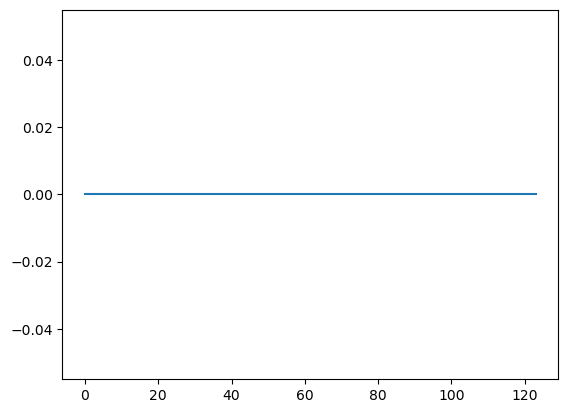

In [12]:
time_lags, time_lags_err = cs_rebin.time_lag()
phase_lags, phase_lags_err = cs_rebin.phase_lag()

# time_lag = phase_lag / (2. * np.pi * freq)
plt.plot(time_lags - phase_lags / (2. * np.pi * cs_rebin.freq))
plt.show()

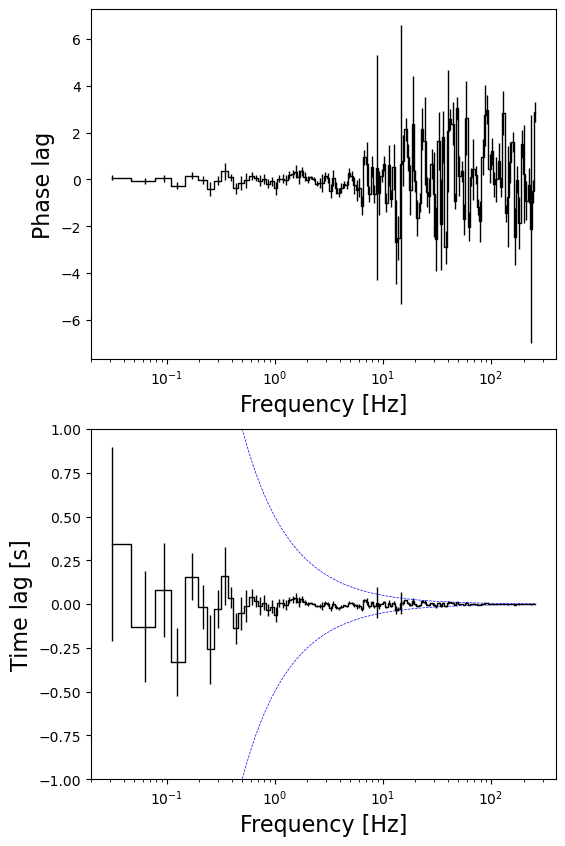

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(6,10))
axs[0].errorbar(cs_rebin.freq, phase_lags, yerr = phase_lags_err, ds = 'steps-mid', color = 'black', linewidth = 1.0)
axs[0].set_xscale('log')
axs[0].set_xlabel('Frequency [Hz]', fontsize = 16)
axs[0].set_ylabel('Phase lag', fontsize = 16)

axs[1].errorbar(cs_rebin.freq, time_lags, yerr = time_lags_err, ds = 'steps-mid', color = 'black', linewidth = 1.0)
axs[1].set_xscale('log')
axs[1].set_xlabel('Frequency [Hz]', fontsize = 16)
axs[1].set_ylabel('Time lag [s]', fontsize = 16)

axs[1].plot(cs_rebin.freq, np.pi/(2.0* np.pi * cs_rebin.freq), linestyle = '--', linewidth = 0.5, color = 'blue')
axs[1].plot(cs_rebin.freq, - np.pi/(2.0* np.pi * cs_rebin.freq), linestyle = '--', linewidth = 0.5, color = 'blue')
axs[1].set_ylim((-1, 1))

plt.show()